In [1]:
import pandas as pd 
from methods import Train, visualization,Samples
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score ,mean_squared_error
from tqdm import tqdm 
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
import numpy as np 
import warnings
import matplotlib.pyplot as plt 
from pmdarima import auto_arima

warnings.filterwarnings('ignore')
train = Train()
vs = visualization()
sp = Samples()

C:\Users\amine\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data 

In [2]:
data= pd.read_excel("Superstore_Sales.xls")

In [3]:
data.head() 

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2013-152156 2013-11-09 2013-11-12    Second Class    CG-12520   
1       2  CA-2013-152156 2013-11-09 2013-11-12    Second Class    CG-12520   
2       3  CA-2013-138688 2013-06-13 2013-06-17    Second Class    DV-13045   
3       4  US-2012-108966 2012-10-11 2012-10-18  Standard Class    SO-20335   
4       5  US-2012-108966 2012-10-11 2012-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [5]:
print("data informations:")
print()
start = data["Order Date"].min().date()
end = data["Order Date"].max().date()
print(f"data range : {start} -> {end}")
print(f"sample shape : {data.shape}")
number_ship_modes = len(data["Ship Mode"].unique())


data informations:

data range : 2011-01-04 -> 2014-12-31
sample shape : (9994, 21)


In [6]:
categorical_columns = ["Ship Mode","Segment","Country","City","State","Region","Category","Sub-Category","Product Name"]
print("data informations:")
print()
for column in categorical_columns:
    number = len(data[column].unique())
    print(f"Number of {column} : {number}")

data informations:

Number of Ship Mode : 4
Number of Segment : 3
Number of Country : 1
Number of City : 531
Number of State : 49
Number of Region : 4
Number of Category : 3
Number of Sub-Category : 17
Number of Product Name : 1850


# General forecasting 

## Transform the data

In [7]:
# m = monthly
general_data = sp.generalData(data,"m")
general_data.head()

Sales
2011-01-31  13946.229
2011-02-28   4810.558
2011-03-31  55691.009
2011-04-30  28295.345
2011-05-31  23648.287

In [8]:
#split data into training and testing splits (we'll need them later)

In [9]:
data_train , data_test = train.split_data(general_data,0.75)

In [10]:
print(f"Train size: {data_train.shape[0]}")
print(f"Test size: {data_test.shape[0]}")

Train size: 36
Test size: 12


## Explore the data 

### Sales over time (months)

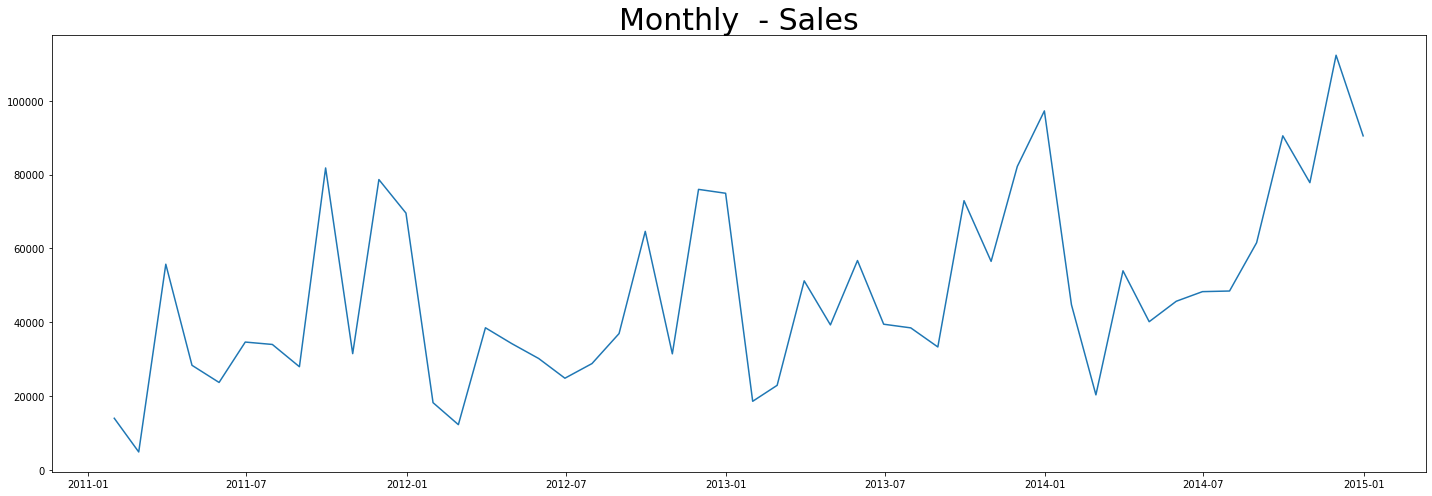

In [11]:
vs.lineplot(general_data,"Monthly")

### Examin the sationarity

#### decompose the data

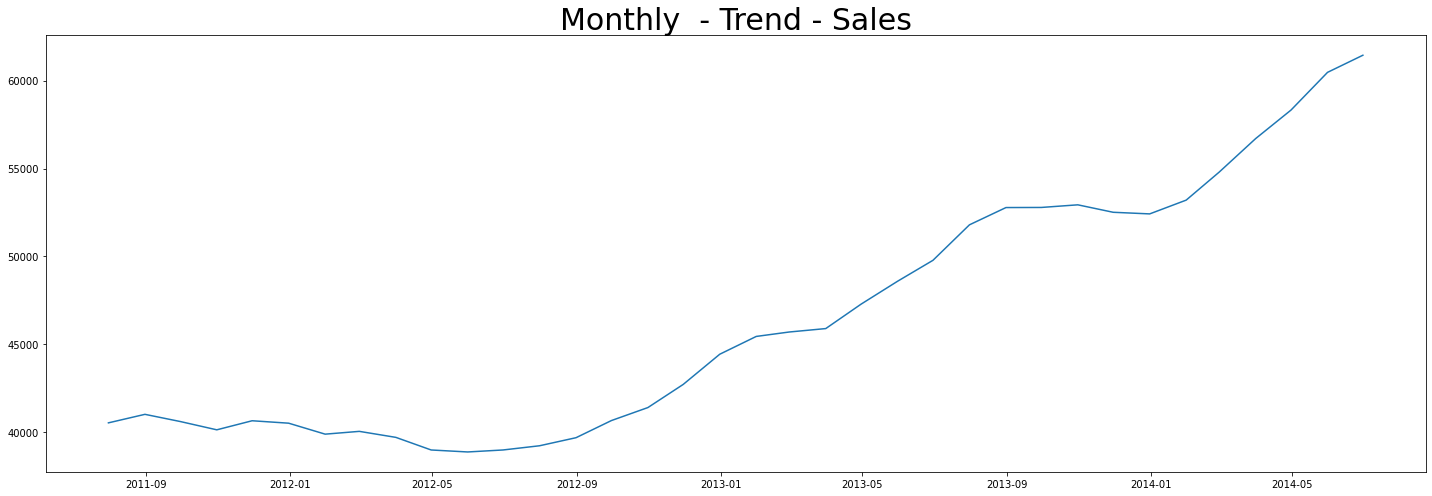

In [12]:
#trend 
vs.trend_plot(general_data,"Monthly")

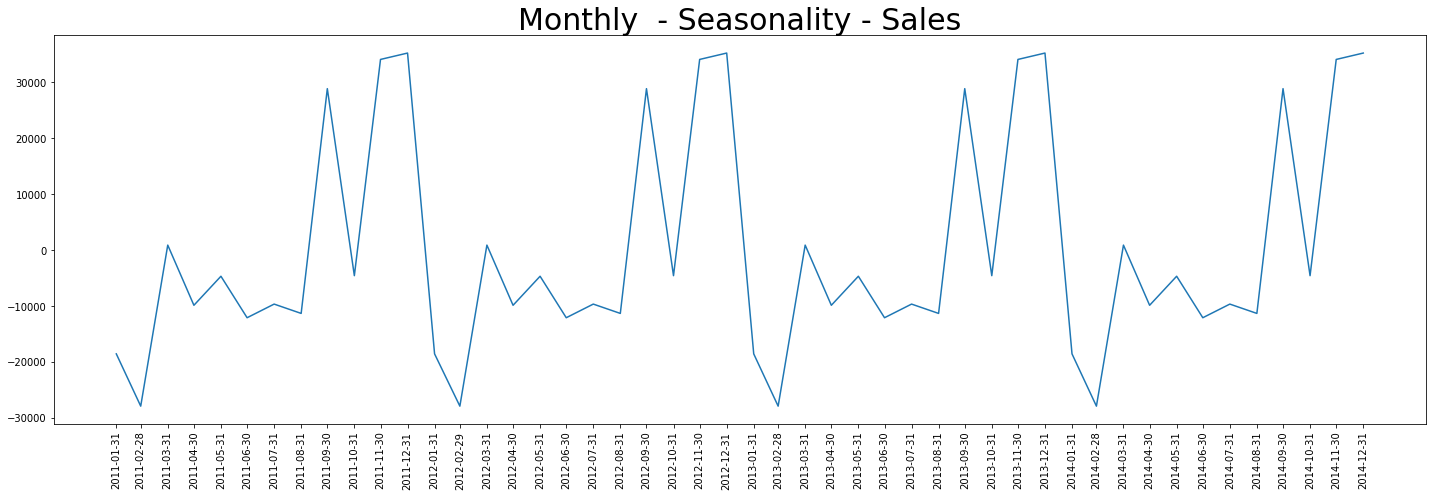

In [13]:
#Seasonality 
vs.seasonality_plot(general_data,"Monthly")

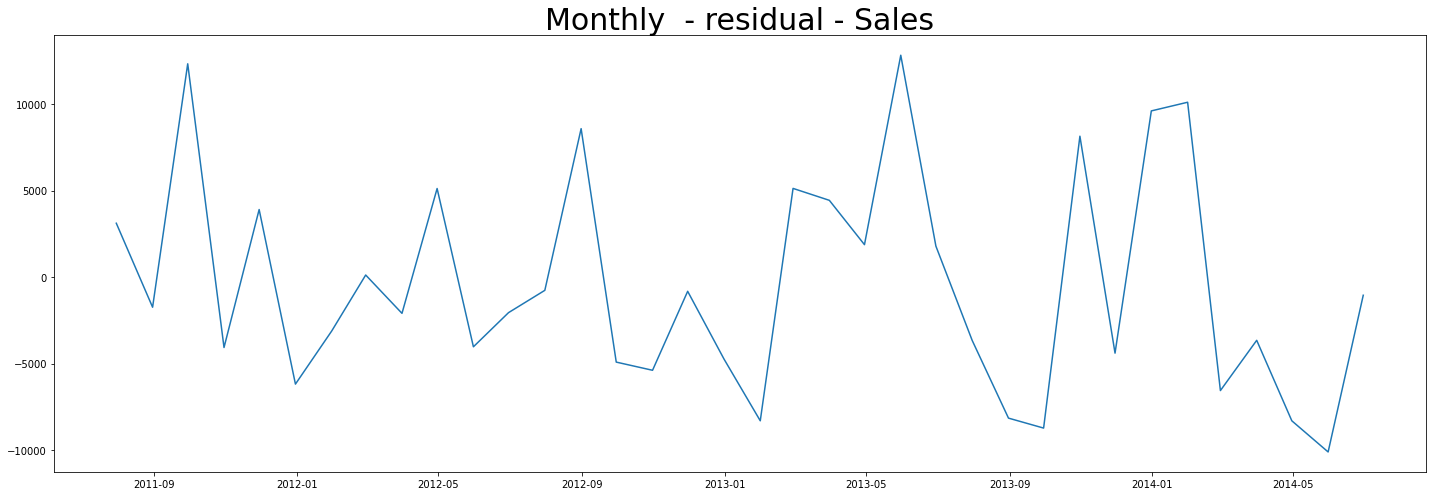

In [14]:
#Residuals 
vs.residual_plot(general_data,"Monthly")

#### ADF test (Augmented Dickey-Fuller test)

In [15]:
result = train.adf_test(general_data["Sales"])
result 

Statistical test  P-values  Lags used  Number of observations
0         -4.302935  0.000439          0                      47

H0: data is not stationnary                         
H1: data is stationnary                             
p value < 0.05 => reject H0 => so based on ADF test data is stationnary                      
(but let take a look in shorter horizons (using acf and pacf plot ))

### Calculate the ACF & PACF plots on the stationary data 

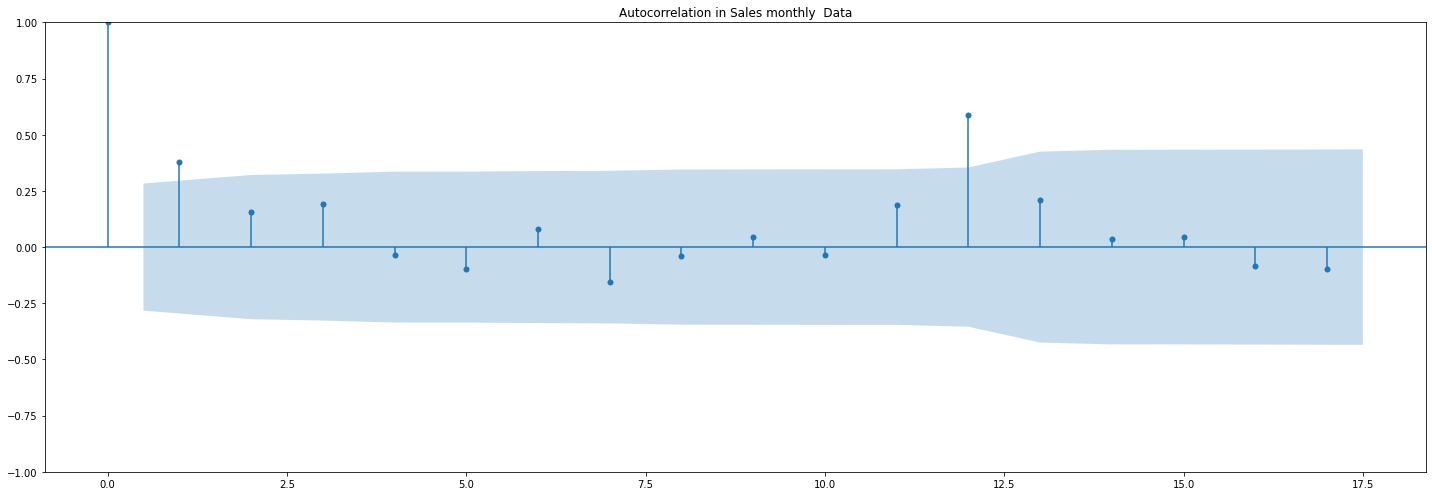

In [16]:
#ACF 
vs.acf_plot(general_data,"monthly")

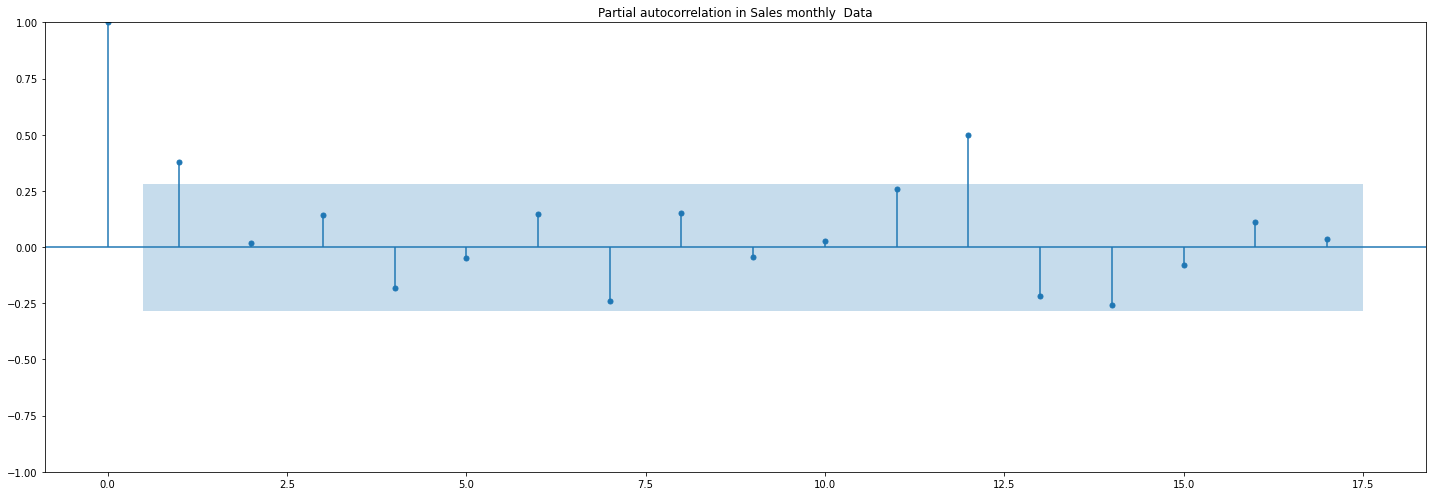

In [17]:
#PACF 
vs.pacf_plot(general_data,"monthly")

## ARIMA 

### Train multiple models 

we gonna automate ARIMA paramaters (using only the lag with a significant correlation) (similar to gridSearch)

In [18]:
models_arima = train.train_arima(general_data,0.75)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

ADF Statistic: -4.302935180048875
p-value: 0.0004390420862895829
acf [0, 1, 12]
pacf [0, 1, 7, 11, 12, 13, 14, 15, 16]
(ar,d,ma) : (0, 0, 0)
(ar,d,ma) : (0, 0, 1)
(ar,d,ma) : (0, 0, 12)
(ar,d,ma) : (1, 0, 0)
(ar,d,ma) : (1, 0, 1)
(ar,d,ma) : (1, 0, 12)
(ar,d,ma) : (7, 0, 0)
(ar,d,ma) : (7, 0, 1)
(ar,d,ma) : (7, 0, 12)
(ar,d,ma) : (11, 0, 0)
(ar,d,ma) : (11, 0, 1)
(ar,d,ma) : (11, 0, 12)
(ar,d,ma) : (12, 0, 0)
(ar,d,ma) : (12, 0, 1)
(ar,d,ma) : (12, 0, 12)
(ar,d,ma) : (13, 0, 0)
(ar,d,ma) : (13, 0, 1)
(ar,d,ma) : (13, 0, 12)
(ar,d,ma) : (14, 0, 0)
(ar,d,ma) : (14, 0, 1)
(ar,d,ma) : (14, 0, 12)
(ar,d,ma) : (15, 0, 0)
(ar,d,ma) : (15, 0, 1)
(ar,d,ma) : (15, 0, 12)
(ar,d,ma) : (16, 0, 0)
(ar,d,ma) : (16, 0, 1)
(ar,d,ma) : (16, 0, 12)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:53<00:00, 53.85s/it]


In [19]:
print("Our results:")
models_arima.head(5)

Our results:


Model Segment  ACF  d  PACF  \
0  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales    0  0     0   
1  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales    1  0     0   
2  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales   12  0     0   
3  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales    0  0     1   
4  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales    1  0     1   

        Order           MAE      MAPE          RMSE  R2_Score     MAE_train  \
0   (0, 0, 0)  22147.117752  0.340696  30817.378021 -0.495478  19627.813463   
1   (0, 0, 1)  22875.367438  0.356987  30950.580609 -0.508433  18964.650570   
2  (0, 0, 12)  26795.023306  0.397330  35990.127484 -1.039648  15174.124037   
3   (1, 0, 0)  23332.790980  0.375692  31249.289049 -0.537690  18989.376768   
4   (1, 0, 1)  23634.997319  0.397574  31680.445957 -0.580415  18783.200204   

   MAPE_train  R2_Score_train    RMSE_train  \
0    0.755736        0.000000  23033.252737   
1    0.697038        0.053323  22410.735442   
2    0.623168        0.403197  17793.881100   
3    0.700456        0.054599  22395.633276   
4    0.699737        0.057506  22361.174600   

                                              Y_test  \
0  2014-01-31     44703.1420
2014-02-28     20283...   
1  2014-01-31     44703.1420
2014-02-28     20283...   
2  2014-01-31     44703.1420
2014-02-28     20283...   
3  2014-01-31     44703.1420
2014-02-28     20283...   
4  2014-01-31     44703.1420
2014-02-28     20283...   

                                        Y_prediction  \
0  2014-01-31    43423.717697
2014-02-28    43423...   
1  2014-01-31    54721.562540
2014-02-28    43423...   
2  2014-01-31    53205.835865
2014-02-28    37816...   
3  2014-01-31    57373.833719
2014-02-28    47040...   
4  2014-01-31    60253.713383
2014-02-28    52669...   

                                  Y_prediction_train  
0  2011-01-31    43423.717697
2011-02-28    43423...  
1  2011-01-31    43423.717698
2011-02-28    36355...  
2  2011-01-31    43423.717747
2011-02-28    34359...  
3  2011-01-31    43423.717698
2011-02-28    35782...  
4  2011-01-31    43423.717720
2011-02-28    35324...

In [20]:
max_r2score_train = max(models_arima["R2_Score_train"])
max_r2score_test = max(models_arima["R2_Score"])
min_mape_train=min(models_arima["MAPE_train"])
min_mape_test = min(models_arima["MAPE"])
print(f"the hightest R2_score (on train data , to test how much the model fits the training data ): {max_r2score_train}")
print(f"the hightest R2_score on test data : {max_r2score_test}")
print()
print(f"the lowest mean absolute percentage error on trainset: {min_mape_train}")
print(f"the lowest mean absolute percentage error on test set: {min_mape_test}")


the hightest R2_score (on train data , to test how much the model fits the training data ): 0.621310742492378
the hightest R2_score on test data : 0.38209818883040014

the lowest mean absolute percentage error on trainset: 0.4733625267185262
the lowest mean absolute percentage error on test set: 0.256347867351916


In [21]:
print("the model that best fits the training set :")

models_arima[models_arima["R2_Score_train"] == max_r2score_train]

the model that best fits the training set :


Model Segment  ACF  d  PACF  \
25  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales    1  0    16   

         Order           MAE      MAPE          RMSE  R2_Score     MAE_train  \
25  (16, 0, 1)  16120.950262  0.277508  20831.330919  0.316682  10824.025256   

    MAPE_train  R2_Score_train    RMSE_train  \
25    0.473363        0.621311  14174.141556   

                                               Y_test  \
25  2014-01-31     44703.1420
2014-02-28     20283...   

                                         Y_prediction  \
25  2014-01-31    42751.685034
2014-02-28    35307...   

                                   Y_prediction_train  
25  2011-01-31    43423.717892
2011-02-28    39287...

In [22]:
print("The model with best performance on test set :")
models_arima[models_arima["R2_Score"] == max_r2score_test]

The model with best performance on test set :


Model Segment  ACF  d  PACF  \
12  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales    0  0    12   

         Order           MAE      MAPE          RMSE  R2_Score     MAE_train  \
12  (12, 0, 0)  16183.870802  0.256348  19809.133067  0.382098  12281.260775   

    MAPE_train  R2_Score_train    RMSE_train  \
12    0.509558        0.571178  15083.203632   

                                               Y_test  \
12  2014-01-31     44703.1420
2014-02-28     20283...   

                                         Y_prediction  \
12  2014-01-31    32588.926931
2014-02-28    24658...   

                                   Y_prediction_train  
12  2011-01-31    43423.717753
2011-02-28    39133...

but based on ACF and PACF we observed that the first lags in ACF and PACF are out of the significance band           
lets explore its performance 

In [23]:
models_arima.loc[(models_arima["ACF"] == 1) & (models_arima["PACF"] ==1) ]

Model Segment  ACF  d  PACF  \
4  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales    1  0     1   

       Order           MAE      MAPE          RMSE  R2_Score     MAE_train  \
4  (1, 0, 1)  23634.997319  0.397574  31680.445957 -0.580415  18783.200204   

   MAPE_train  R2_Score_train  RMSE_train  \
4    0.699737        0.057506  22361.1746   

                                              Y_test  \
4  2014-01-31     44703.1420
2014-02-28     20283...   

                                        Y_prediction  \
4  2014-01-31    60253.713383
2014-02-28    52669...   

                                  Y_prediction_train  
4  2011-01-31    43423.717720
2011-02-28    35324...

### Explore the performance of the top models 

#### Forecasts against Training:
 

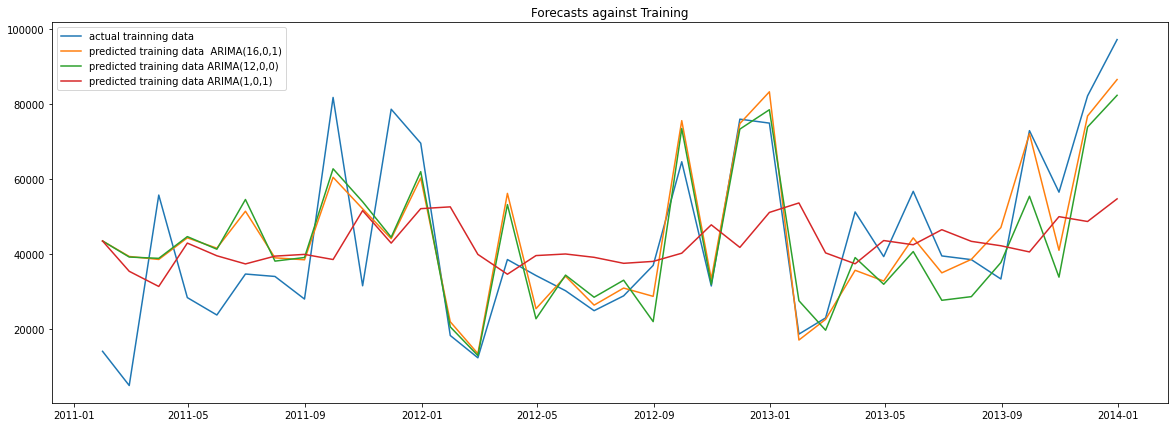

In [24]:
plt.title("Forecasts against Training")
plt.plot(data_train["Sales"],label="actual trainning data")
plt.plot(models_arima["Y_prediction_train"][25],label="predicted training data  ARIMA(16,0,1)")
plt.plot(models_arima["Y_prediction_train"][12],label="predicted training data ARIMA(12,0,0)")
plt.plot(models_arima["Y_prediction_train"][4],label="predicted training data ARIMA(1,0,1)")

plt.legend()

####  Forecasts against Test sets

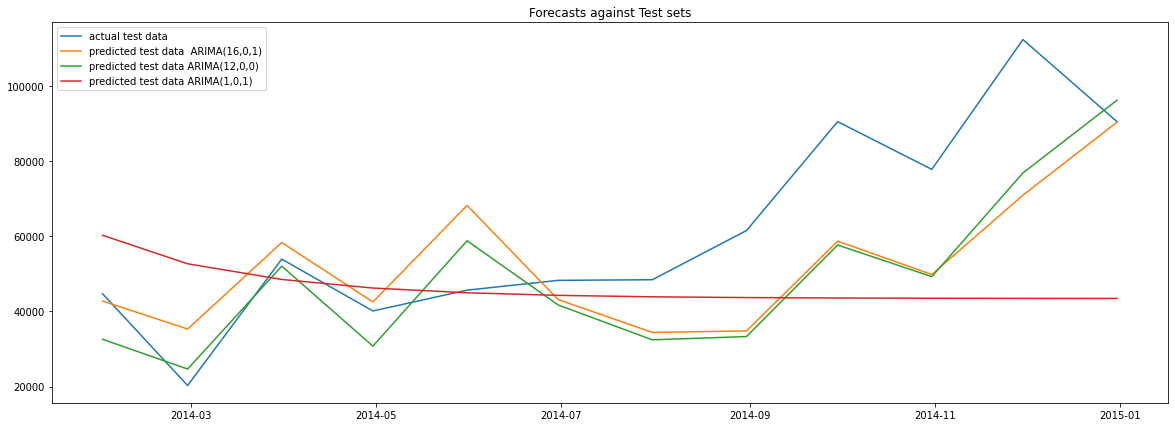

In [25]:
plt.title("Forecasts against Test sets")
plt.plot(data_test["Sales"],label="actual test data")
plt.plot(models_arima["Y_prediction"][25],label="predicted test data  ARIMA(16,0,1)")
plt.plot(models_arima["Y_prediction"][12],label="predicted test data ARIMA(12,0,0)")
plt.plot(models_arima["Y_prediction"][4],label="predicted test data ARIMA(1,0,1)")

plt.legend()

### Evaluate ARIMA

In [26]:
evaluation = {
    "Models":["ARIMA(1,0,1)","ARIMA(12,0,0)","ARIMA(16,0,1)"],
    "R2_score_train":[models_arima["R2_Score_train"][4],models_arima["R2_Score_train"][12],models_arima["R2_Score_train"][25]],
    "R2_score_test":[models_arima["R2_Score"][4],models_arima["R2_Score"][12],models_arima["R2_Score"][25]],
    "MAE_train":[models_arima["MAE_train"][4],models_arima["MAE_train"][12],models_arima["MAE_train"][25]],
    "MAE_test":[models_arima["MAE"][4],models_arima["MAE"][12],models_arima["MAE"][25]],
    "RMSE_train":[models_arima["RMSE_train"][4],models_arima["RMSE_train"][12],models_arima["RMSE_train"][25]],
    "RMSE_test":[models_arima["RMSE"][4],models_arima["RMSE"][12],models_arima["RMSE"][25]],
    "MAPE_train":[models_arima["MAPE_train"][4],models_arima["MAPE_train"][12],models_arima["MAPE_train"][25]],
    "MAPE_test":[models_arima["MAPE"][4],models_arima["MAPE"][12],models_arima["MAPE"][25]],
}
evaluation = pd.DataFrame(evaluation).set_index("Models")
evaluation

R2_score_train  R2_score_test     MAE_train      MAE_test  \
Models                                                                     
ARIMA(1,0,1)         0.057506      -0.580415  18783.200204  23634.997319   
ARIMA(12,0,0)        0.571178       0.382098  12281.260775  16183.870802   
ARIMA(16,0,1)        0.621311       0.316682  10824.025256  16120.950262   

                 RMSE_train     RMSE_test  MAPE_train  MAPE_test  
Models                                                            
ARIMA(1,0,1)   22361.174600  31680.445957    0.699737   0.397574  
ARIMA(12,0,0)  15083.203632  19809.133067    0.509558   0.256348  
ARIMA(16,0,1)  14174.141556  20831.330919    0.473363   0.277508

## SARIMA

StatsModels in Python We can't choose a  AR lag or MA lag that is greater than seasonal lag .     
so we can use only ar = [1,7,11] and ma =[1]

**identify the SARIMA(p,d,q)(P,D,Q,S) parameters :**                    
p = 1 , 7 or 11 (from ACF plot)                       
d = 0 (because we didnt differenciate our data)        
q = 1 (from PACF plot )  
S = 12 (base on seasonal plot)              
D = 1 (based on seasonal plot , there is a stable seasonal pattern)         
P >= 1 : beceause the PACF is positive at lag S (=12)              
Q >= 1 : beceause the ACF is positive at lag S

*NB: P + Q <= 2 (Rule of thumb)* 

### automate the process : (Train multiple models)

In [27]:
def initialize_sarima_dict():
    result = {
        'Model':[],
        'Segment':[],
        'ACF':[],
        'd':[],
        'PACF':[],
        'Order':[],
        "P":[],
        "D":[],
        "Q":[],
        "S":[],
        'MAE':[],
        'MAPE':[],
        'RMSE':[],
        'R2_Score':[],

        'MAE_train':[],
        'MAPE_train':[],
        'R2_Score_train':[],
        'RMSE_train':[],

        'Y_test':[],
        'Y_prediction':[],
        "Y_prediction_train":[], 
    }
    return result


In [28]:
def train_sarima(data_train,data_test,column_name,evaluation,p,d,q,upperP,D,upperQ,S):
    sarima_model = ARIMA(data_train,  
                            order = (p,d,q),
                            seasonal_order = (upperP,D,upperQ,S)
                            ).fit()
    #make forecasts 
    y_pred_train = sarima_model.predict()
    y_pred_test = sarima_model.forecast(len(data_test))

    #evaluate
    order = (p,d,q)
    
    #get train_subset(eliminet first S months)
    data_train = data_train[S:]
    y_pred_train = y_pred_train[S:]

    #evaluate training fit 
    mae_train = mean_absolute_error(data_train,y_pred_train)
    mape_train = mean_absolute_percentage_error(data_train,y_pred_train)
    r2score_train = r2_score(data_train,y_pred_train)
    rmse_train = mean_squared_error(data_train,y_pred_train,squared=False)

    #rolling forecast orgin(dynamic)
    mae_forecast = mean_absolute_error(data_test,y_pred_test)
    mape_forecast = mean_absolute_percentage_error(data_test,y_pred_test)
    r2score_forecast = r2_score(data_test,y_pred_test)
    rmse_forecast = mean_squared_error(data_test,y_pred_test,squared=False)

    #add row . (save model infos)
    evaluation['Model'].append(sarima_model)
    evaluation['Segment'].append(column_name)

    evaluation['ACF'].append(q)
    evaluation['d'].append(d)
    evaluation['PACF'].append(p)
    evaluation['Order'].append(order)
    evaluation['P'].append(upperP)
    evaluation['Q'].append(upperQ)
    evaluation['D'].append(D)
    evaluation['S'].append(S)

    evaluation['MAE'].append(mae_forecast)
    evaluation['MAPE'].append(mape_forecast)
    evaluation['R2_Score'].append(r2score_forecast)
    evaluation['RMSE'].append(rmse_forecast)


    evaluation['MAE_train'].append(mae_train)
    evaluation['MAPE_train'].append(mape_train)
    evaluation['R2_Score_train'].append(r2score_train)
    evaluation['RMSE_train'].append(rmse_train)
    
    evaluation['Y_test'].append(data_test)
    evaluation['Y_prediction'].append(y_pred_test)
    evaluation['Y_prediction_train'].append(y_pred_train)
    
    return pd.DataFrame(evaluation)

In [29]:
#initialize paramaters 
p_list= [0,1,7,11]
d= 0 
q= 1 
S= 12
D=1
upperP_list=[0,1,2]
Q_list=[0,1,2]
results_sarima = initialize_sarima_dict()
results_sarima = pd.DataFrame(results_sarima)
#train ARIMA 
for p in p_list:
    for upperP in upperP_list:
        for upperQ in Q_list:
            #contraint Q + P <=2
            if(upperP + upperQ <= 2):
                empty_dict = initialize_sarima_dict()
                #fit sarima model
                row = train_sarima(data_train["Sales"],data_test["Sales"],"Sales",empty_dict,p,d,q,upperP,D,upperQ,S)
                results_sarima = pd.concat([results_sarima,row],axis=0)
                


In [30]:
new_index = pd.Series([i for i in range(results_sarima.shape[0])])
new_index
results_sarima  = results_sarima.set_index(new_index)
results_sarima.head(5)


Model Segment  ACF    d  PACF  \
0  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales  1.0  0.0   0.0   
1  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales  1.0  0.0   0.0   
2  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales  1.0  0.0   0.0   
3  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales  1.0  0.0   0.0   
4  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales  1.0  0.0   0.0   

       Order    P    D    Q     S  ...      MAPE          RMSE  R2_Score  \
0  (0, 0, 1)  0.0  1.0  0.0  12.0  ...  0.218698  16776.366033  0.556816   
1  (0, 0, 1)  0.0  1.0  1.0  12.0  ...  0.216438  16945.120914  0.547855   
2  (0, 0, 1)  0.0  1.0  2.0  12.0  ...  0.235631  16992.819975  0.545306   
3  (0, 0, 1)  1.0  1.0  0.0  12.0  ...  0.216299  17039.431012  0.542808   
4  (0, 0, 1)  1.0  1.0  1.0  12.0  ...  0.267080  20714.433010  0.324330   

     MAE_train  MAPE_train  R2_Score_train    RMSE_train  \
0  9604.033028    0.238234        0.715988  11900.595661   
1  9430.524622    0.235910        0.730877  11584.460408   
2  7937.751452    0.212043        0.820133   9470.564637   
3  9327.947045    0.233905        0.736637  11459.827552   
4  8234.904328    0.209317        0.791649  10192.921132   

                                              Y_test  \
0  2014-01-31     44703.1420
2014-02-28     20283...   
1  2014-01-31     44703.1420
2014-02-28     20283...   
2  2014-01-31     44703.1420
2014-02-28     20283...   
3  2014-01-31     44703.1420
2014-02-28     20283...   
4  2014-01-31     44703.1420
2014-02-28     20283...   

                                        Y_prediction  \
0  2014-01-31    21315.86516
2014-02-28    22867....   
1  2014-01-31    22041.096465
2014-02-28    21996...   
2  2014-01-31    19599.207038
2014-02-28    23932...   
3  2014-01-31    22227.141629
2014-02-28    21729...   
4  2014-01-31    18684.944555
2014-02-28    21990...   

                                  Y_prediction_train  
0  2012-01-31    21489.696855
2012-02-29     4390...  
1  2012-01-31    21846.542567
2012-02-29     3862...  
2  2012-01-31    11519.461917
2012-02-29     4353...  
3  2012-01-31    21775.907534
2012-02-29     3698...  
4  2012-01-31    16367.950943
2012-02-29     4281...  

[5 rows x 21 columns]

### Explore the performance of the top models 

In [31]:
max_r2score_sarima_train = max(results_sarima["R2_Score_train"])
max_r2score_sarima_test = max(results_sarima["R2_Score"])
min_mape_sarima_train=min(results_sarima["MAPE_train"])
min_mape_sarima_test = min(results_sarima["MAPE"])
print(f"the hightest R2_score (on train data , to test how much the model fits the training data ): {max_r2score_sarima_train}")
print(f"the hightest R2_score on test data : {max_r2score_sarima_test}")
print()
print(f"the lowest mean absolute percentage error on trainset: {min_mape_sarima_train}")
print(f"the lowest mean absolute percentage error on test set: {min_mape_sarima_test}")


the hightest R2_score (on train data , to test how much the model fits the training data ): 0.8920357670221702
the hightest R2_score on test data : 0.7433493792977566

the lowest mean absolute percentage error on trainset: 0.16160390227808077
the lowest mean absolute percentage error on test set: 0.20528707298264692


In [32]:
print("the model that best fits the training set :")

results_sarima[results_sarima["R2_Score_train"] == max_r2score_sarima_train]

the model that best fits the training set :


Model Segment  ACF    d  PACF  \
21  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales  1.0  0.0  11.0   

         Order    P    D    Q     S  ...      MAPE         RMSE  R2_Score  \
21  (11, 0, 1)  1.0  1.0  0.0  12.0  ...  0.218682  13428.25399  0.716059   

      MAE_train  MAPE_train  R2_Score_train   RMSE_train  \
21  6100.436514    0.161604        0.892036  7337.374139   

                                               Y_test  \
21  2014-01-31     44703.1420
2014-02-28     20283...   

                                         Y_prediction  \
21  2014-01-31     26481.701069
2014-02-28     312...   

                                   Y_prediction_train  
21  2012-01-31    12299.623354
2012-02-29    13020...  

[1 rows x 21 columns]

In [33]:
print("The model with best performance on test set :")
results_sarima[results_sarima["R2_Score"] == max_r2score_sarima_test]

The model with best performance on test set :


Model Segment  ACF    d  PACF  \
9  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   Sales  1.0  0.0   1.0   

       Order    P    D    Q     S  ...      MAPE          RMSE  R2_Score  \
9  (1, 0, 1)  1.0  1.0  0.0  12.0  ...  0.205828  12766.648308  0.743349   

     MAE_train  MAPE_train  R2_Score_train  RMSE_train  \
9  6837.146239    0.167065        0.855312  8494.09819   

                                              Y_test  \
9  2014-01-31     44703.1420
2014-02-28     20283...   

                                        Y_prediction  \
9  2014-01-31     28487.875662
2014-02-28     301...   

                                  Y_prediction_train  
9  2012-01-31    20410.055811
2012-02-29    13521...  

[1 rows x 21 columns]

### Explore the performance of the top models 

#### Forecasts against Training:
 

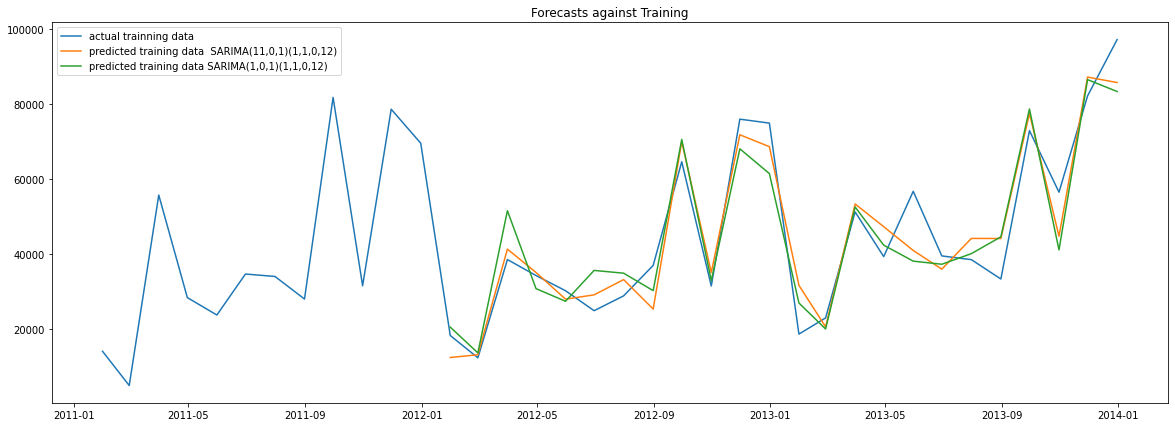

In [34]:
plt.title("Forecasts against Training")
plt.plot(data_train["Sales"],label="actual trainning data")
plt.plot(results_sarima["Y_prediction_train"][21],label="predicted training data  SARIMA(11,0,1)(1,1,0,12)")
plt.plot(results_sarima["Y_prediction_train"][9],label="predicted training data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

####  Forecasts against Test sets

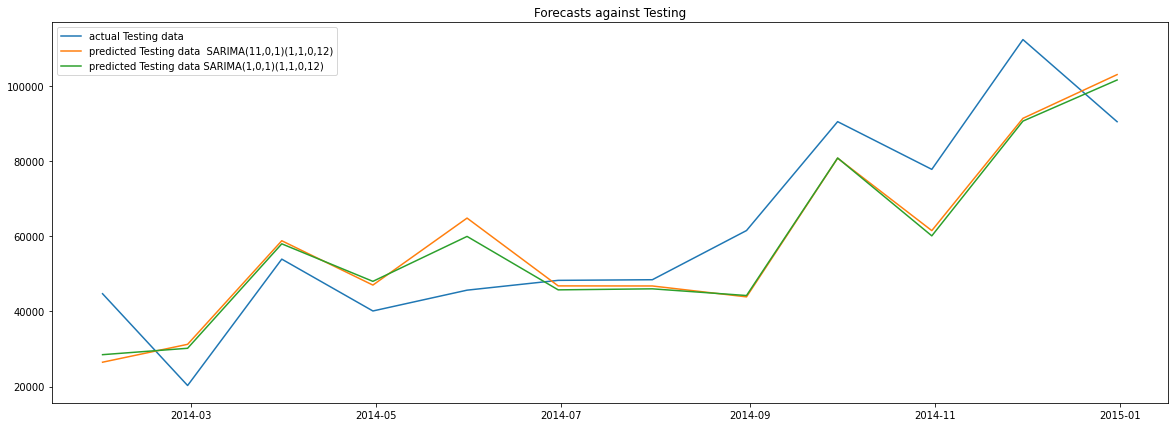

In [35]:
plt.title("Forecasts against Testing")
plt.plot(data_test["Sales"],label="actual Testing data")
plt.plot(results_sarima["Y_prediction"][21],label="predicted Testing data  SARIMA(11,0,1)(1,1,0,12)")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

### Evaluate SARIMA

In [36]:
evaluation_SARIMA = {
    "Models":["SARIMA(11,0,1)(1,1,0,12)","SARIMA(1,0,1)(1,1,0,12)"],
    "R2_score_train":[results_sarima["R2_Score_train"][21],results_sarima["R2_Score_train"][9]],
    "R2_score_test":[results_sarima["R2_Score"][21],results_sarima["R2_Score"][9]],
    "MAE_train":[results_sarima["MAE_train"][21],results_sarima["MAE_train"][9]],
    "MAE_test":[results_sarima["MAE"][21],results_sarima["MAE"][9]],
    "RMSE_train":[results_sarima["RMSE_train"][21],results_sarima["RMSE_train"][9]],
    "RMSE_test":[results_sarima["RMSE"][21],results_sarima["RMSE"][9]],
    "MAPE_train":[results_sarima["MAPE_train"][21],results_sarima["MAPE_train"][9]],
    "MAPE_test":[results_sarima["MAPE"][21],results_sarima["MAPE"][9]],
}
evaluation_SARIMA = pd.DataFrame(evaluation_SARIMA).set_index("Models")
evaluation_SARIMA

R2_score_train  R2_score_test    MAE_train  \
Models                                                                 
SARIMA(11,0,1)(1,1,0,12)        0.892036       0.716059  6100.436514   
SARIMA(1,0,1)(1,1,0,12)         0.855312       0.743349  6837.146239   

                              MAE_test   RMSE_train     RMSE_test  MAPE_train  \
Models                                                                          
SARIMA(11,0,1)(1,1,0,12)  11702.058017  7337.374139  13428.253990    0.161604   
SARIMA(1,0,1)(1,1,0,12)   11230.945070  8494.098190  12766.648308    0.167065   

                          MAPE_test  
Models                               
SARIMA(11,0,1)(1,1,0,12)   0.218682  
SARIMA(1,0,1)(1,1,0,12)    0.205828

In [37]:
import numpy as np 
np.sqrt(results_sarima["RMSE_train"][21])

85.65847382940096

## Auto ARIMA

### Find the best model's parameters

In [38]:
auto_arima = auto_arima(data_train["Sales"],m=12,
                                 max_order=None, max_p=12,max_d=4,max_q=12,
                                 max_P=4,max_D=2,max_Q=4,
                                 maxiter=500, alpha=0.05, n_jobs= -1,trend=[1,1,1,1])

In [39]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -400.754
Date:                  Sun, 23 Jun 2024   AIC                            813.507
Time:                          12:35:23   BIC                            823.008
Sample:                      01-31-2011   HQIC                           816.823
                           - 12-31-2013                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8098.0140   1.41e+04      0.575      0.565   -1.95e+04    3.57e+04
drift       7511.8488   4164.171      1.804      0.071    -649.777    1.57e+04
trend.2     -572.5466    339.955     -1.684      0.092   -1238.845      93.752
trend.3       11.5402      7.193      1.604      0.109      -2.558      25.639
ar.S.L12       0.4444      0.256      1.733      0.083      -0.058       0.947
sigma2      3.609e+08      0.094   3.86e+09      0.000    3.61e+08    3.61e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                 2.92
Prob(Q):                              0.52   Prob(JB):                         0.23
Heteroskedasticity (H):               0.28   Skew:                             0.58
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.94e+26. Standard errors may be unstable.
"""

**=> so based on auto_arima the best model is  ARIMA(1, 0, 0)(1, 0, 0)[12]**

In [40]:
best_auto_arima_model = ARIMA(data_train["Sales"], order=(1, 0, 0), seasonal_order=(1, 0, 0, 12)).fit()
y_pred_train_best_AAM= best_auto_arima_model.predict()
y_pred_test_best_AAM = best_auto_arima_model.forecast(len(data_test["Sales"]))



### Explore the performance of the top model


#### Forecasts against Training:


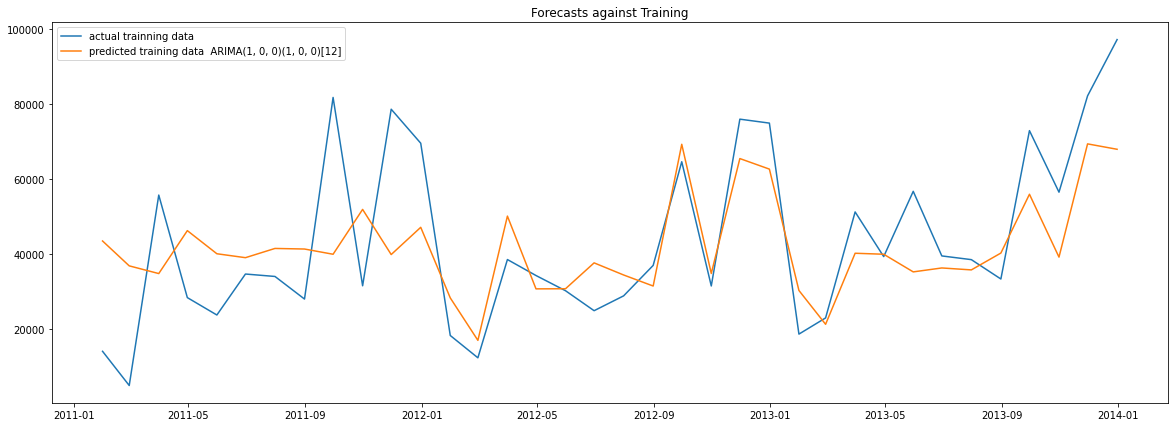

In [41]:
plt.title("Forecasts against Training")
plt.plot(data_train["Sales"],label="actual trainning data")
plt.plot(y_pred_train_best_AAM,label="predicted training data  ARIMA(1, 0, 0)(1, 0, 0)[12]")

plt.legend()

#### Forecasts against Test sets

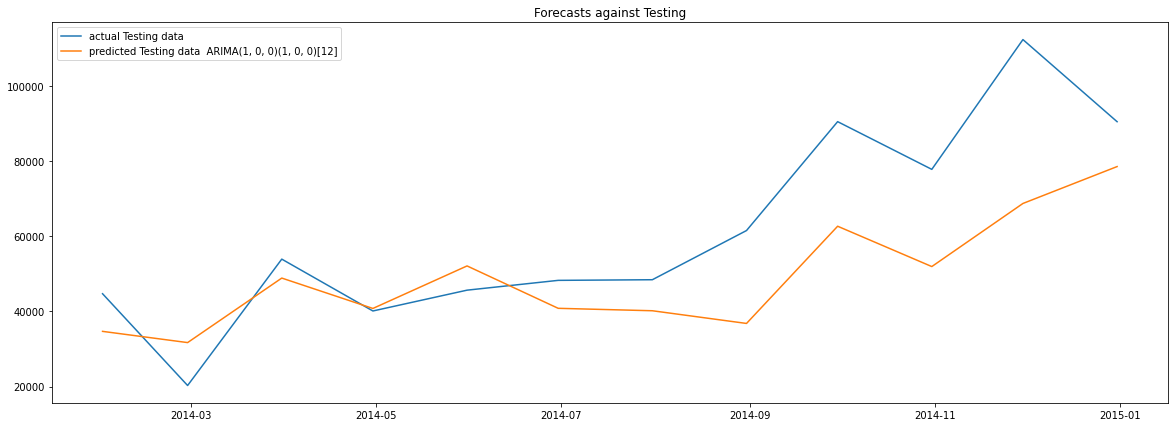

In [42]:
plt.title("Forecasts against Testing")
plt.plot(data_test["Sales"],label="actual Testing data")
plt.plot(y_pred_test_best_AAM,label="predicted Testing data  ARIMA(1, 0, 0)(1, 0, 0)[12]")

plt.legend()

### Evaluate auto_arima's result

In [43]:
#train
best_auto_arima_model_r2score_train = r2_score(data_train["Sales"],y_pred_train_best_AAM)
best_auto_arima_model_mae_train = mean_absolute_error(data_train["Sales"],y_pred_train_best_AAM)
best_auto_arima_model_mape_train = mean_absolute_percentage_error(data_train["Sales"],y_pred_train_best_AAM)
best_auto_arima_model_rmse_train = mean_squared_error(data_train["Sales"],y_pred_train_best_AAM)

#test 
best_auto_arima_model_r2score_test = r2_score(data_test["Sales"],y_pred_test_best_AAM)
best_auto_arima_model_mae_test = mean_absolute_error(data_test["Sales"],y_pred_test_best_AAM)
best_auto_arima_model_mape_test = mean_absolute_percentage_error(data_test["Sales"],y_pred_test_best_AAM)
best_auto_arima_model_rmse_test = mean_squared_error(data_test["Sales"],y_pred_test_best_AAM)


In [44]:
evaluation_best_auto_arima_model = {
    "Models":["ARIMA(1, 0, 0)(1, 0, 0)[12]"],
    "R2_score_train":[best_auto_arima_model_r2score_train],
    "R2_score_test":[best_auto_arima_model_r2score_test],
    "MAE_train":[best_auto_arima_model_mae_train],
    "MAE_test":[best_auto_arima_model_mae_test],
    "RMSE_train":[best_auto_arima_model_rmse_train],
    "RMSE_test":[best_auto_arima_model_rmse_test],
    "MAPE_train":[best_auto_arima_model_mape_train],
    "MAPE_test":[best_auto_arima_model_mape_test],
}
evaluation_best_auto_arima_model = pd.DataFrame(evaluation_best_auto_arima_model).set_index("Models")
evaluation_best_auto_arima_model

R2_score_train  R2_score_test     MAE_train  \
Models                                                                     
ARIMA(1, 0, 0)(1, 0, 0)[12]        0.447579       0.406889  13514.789728   

                                 MAE_test    RMSE_train     RMSE_test  \
Models                                                                  
ARIMA(1, 0, 0)(1, 0, 0)[12]  15270.009035  2.930763e+08  3.766580e+08   

                             MAPE_train  MAPE_test  
Models                                              
ARIMA(1, 0, 0)(1, 0, 0)[12]    0.517657   0.243752

### Conclusion

=> We conclude that our function (train_Saarima) has better performance than auto_arima. Best model so far
is SSARIMA(11,0,1)(1,1,0,12)

## SES (simple exponential smoothing)

### Transform data to a single TimeSeries 

In [45]:
from darts import TimeSeries


In [46]:
series = general_data.copy()
series["Months"] = series.index
series = TimeSeries.from_dataframe(series,"Months",'Sales')


In [47]:
train, val = series.split_before(data_test.index[0]) 


### check seasonality using darts labrary

In [48]:
from darts.utils.statistics import check_seasonality

In [49]:
check_seasonality(series,max_lag=120)

(True, 3)

### Train the SES model

In [50]:
from darts.models import ExponentialSmoothing

The StatsForecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [51]:
model_ses = ExponentialSmoothing().fit(train)

In [52]:
predictions_ses_test = model_ses.predict(len(val),num_samples=1000)

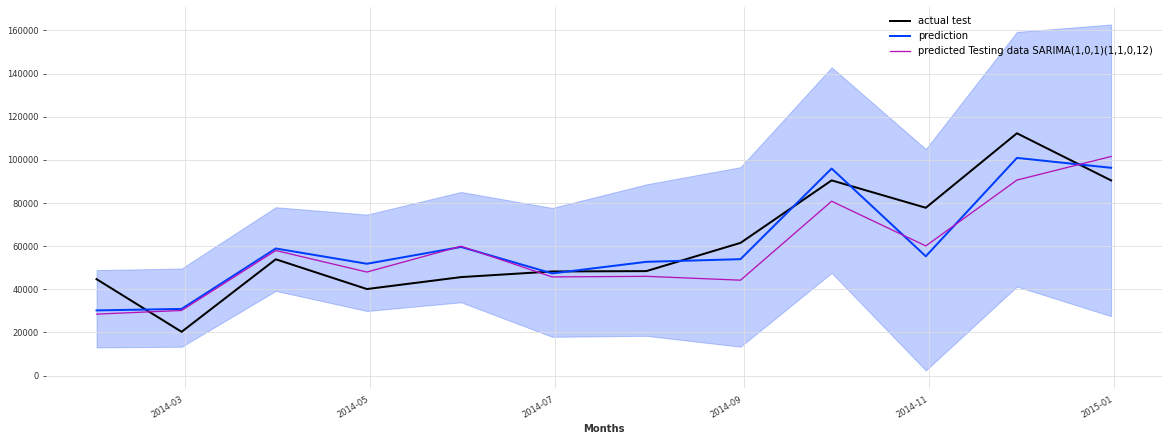

In [53]:
#plt.plot(val,label="real test")
val.plot(label="actual test")
predictions_ses_test.plot(label="prediction")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")
plt.legend()

### Evaluate SES results 

In [54]:
from darts.metrics import mae,mape,r2_score,rmse

In [55]:
#test 
ses_model_r2score_test = r2_score(predictions_ses_test,series)
ses_model_mae_test = mae(predictions_ses_test,series)
ses_model_mape_test = mape(predictions_ses_test,series)
ses_model_rmse_test = rmse(predictions_ses_test,series)


In [56]:
evaluation_ses_model = {
    "Models":["SES"],
    "R2_score_test":[ses_model_r2score_test],
    "MAE_test":[ses_model_mae_test],
    "RMSE_test":[ses_model_rmse_test],
    "MAPE_test":[ses_model_mape_test],
}
evaluation_ses_model = pd.DataFrame(evaluation_ses_model).set_index("Models")
evaluation_ses_model

R2_score_test     MAE_test     RMSE_test  MAPE_test
Models                                                     
SES          0.770233  9486.114864  11021.648422   18.72872

## Theta algorithm

### Train the Theta model

In [57]:
from darts.models import Theta

In [58]:
model_theta = Theta()
model_theta.fit(train)
prediction_theta = model_theta.predict(len(val))

### Evaluate Theta results

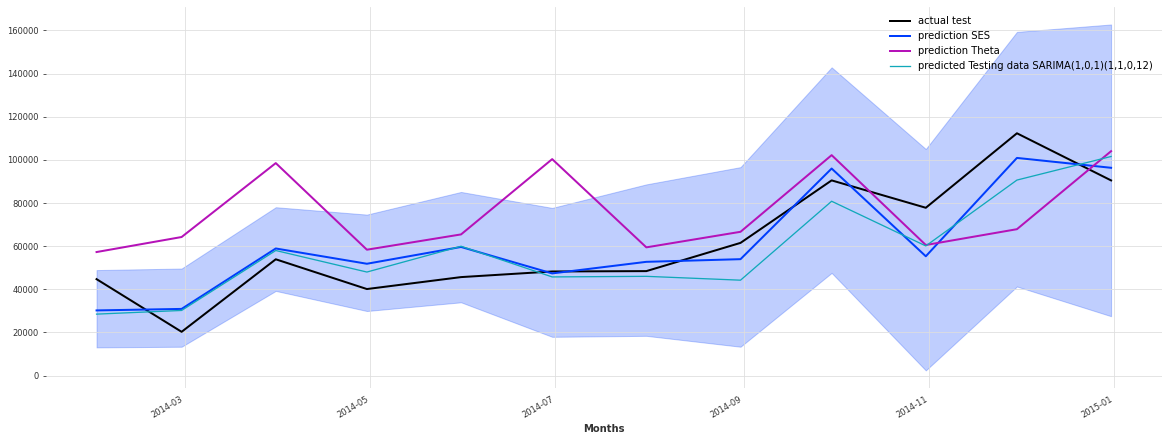

In [59]:
val.plot(label="actual test")
predictions_ses_test.plot(label="prediction SES")
prediction_theta.plot(label="prediction Theta")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")
plt.legend()

In [60]:
#test 
theta_model_r2score_test = r2_score(prediction_theta,series)
theta_model_mae_test = mae(prediction_theta,series)
theta_model_mape_test = mape(prediction_theta,series)
theta_model_rmse_test = rmse(prediction_theta,series)


In [61]:
evaluation_theta_model = {
    "Models":["Theta"],
    "R2_score_test":[theta_model_r2score_test],
    "MAE_test":[theta_model_mae_test],
    "RMSE_test":[theta_model_rmse_test],
    "MAPE_test":[theta_model_mape_test],
}
evaluation_theta_model = pd.DataFrame(evaluation_theta_model).set_index("Models")
evaluation_theta_model

R2_score_test     MAE_test     RMSE_test  MAPE_test
Models                                                     
Theta       -1.474407  24530.23595  29238.453618  32.817128

## auto_arima by darts library

### Train the darts auto_arima model

In [62]:
from darts.models import AutoARIMA

In [63]:
#seasonality = 3
darts_aarima = AutoARIMA(m=3, #seasonality
                         seasonal = True,
                         test= "adf",
                         d=None,
                         start_p = 0 , start_q = 0,
                         max_p = 12 , max_q = 12,
                         D=None,
                         start_P = 0 , start_Q = 0,
                         trace = True,
                         error_action = "ignore",
                         suppress_warnings = True,
                         stepwise = True
                        )
darts_aarima.fit(train)
predictions_darts_aarima = darts_aarima.predict(len(val))


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[3]             : AIC=829.693, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[3]             : AIC=811.519, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[3]             : AIC=800.121, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[3]             : AIC=798.733, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[3]             : AIC=799.656, Time=0.12 sec
 ARIMA(0,2,1)(1,0,1)[3]             : AIC=inf, Time=0.67 sec
 ARIMA(1,2,1)(0,0,0)[3]             : AIC=794.822, Time=0.07 sec
 ARIMA(1,2,1)(1,0,0)[3]             : AIC=795.858, Time=0.16 sec
 ARIMA(1,2,1)(0,0,1)[3]             : AIC=796.205, Time=0.15 sec
 ARIMA(1,2,1)(1,0,1)[3]             : AIC=793.861, Time=0.33 sec
 ARIMA(1,2,1)(2,0,1)[3]             : AIC=796.142, Time=0.39 sec
 ARIMA(1,2,1)(1,0,2)[3]             : AIC=795.691, Time=0.82 sec
 ARIMA(1,2,1)(0,0,2)[3]             : AIC=797.026, Time=0.28 sec
 ARIMA(1,2,1)(2,0,0)[3]             : AIC=795.768, Time=0.22 sec
 ARIMA(1,2,1)(2,0,2)[3]             : AIC=795.885, 

In [64]:
#seasonality 12
darts_aarima_12 = AutoARIMA(m=12, #seasonality
                         seasonal = True,
                         test= "adf",
                         d=None,
                         start_p = 0 , start_q = 0,
                         max_p = 12 , max_q = 12,
                         D=None,
                         start_P = 0 , start_Q = 0,
                         trace = True,
                         error_action = "ignore",
                         suppress_warnings = True,
                         stepwise = True
                        )
darts_aarima_12.fit(train)
predictions_darts_aarima_12 = darts_aarima_12.predict(len(val))


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=829.693, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=802.832, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=814.396, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=804.832, Time=0.13 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=804.832, Time=0.10 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=806.502, Time=0.06 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=806.831, Time=0.14 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=810.386, Time=0.22 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=792.117, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=802.986, Time=0.05 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=794.117, Time=0.22 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=794.117, Time=0.32 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=795.274, Time=0.16 sec
 ARIMA(2,2,0)(2,0,1)[12]             

### Evaluate darts auto arima 

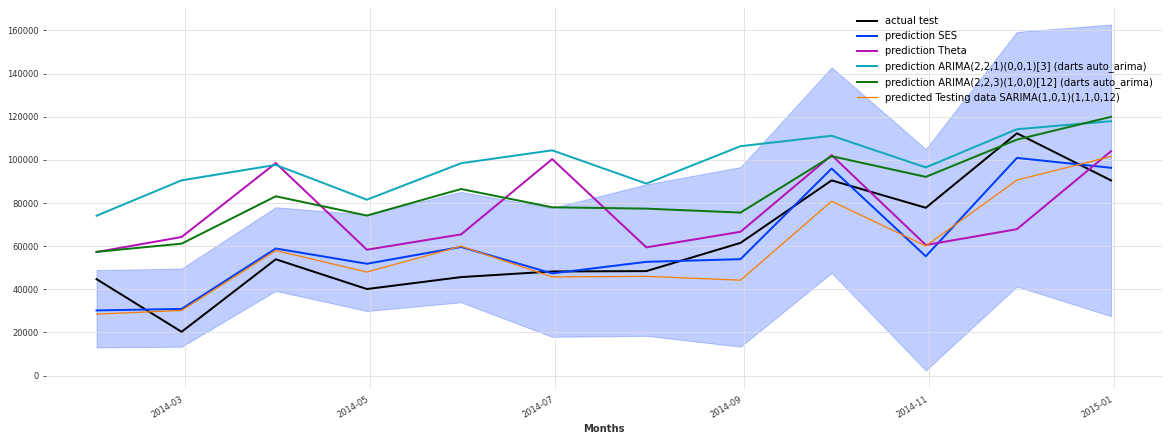

In [65]:
val.plot(label="actual test")
predictions_ses_test.plot(label="prediction SES")
prediction_theta.plot(label="prediction Theta")
predictions_darts_aarima.plot(label="prediction ARIMA(2,2,1)(0,0,1)[3] (darts auto_arima)")
predictions_darts_aarima_12.plot(label="prediction ARIMA(2,2,3)(1,0,0)[12] (darts auto_arima)")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")
plt.legend()

In [66]:
#test ARIMA(2,2,1)(0,0,1)[3]
aarima_r2score_test = r2_score(predictions_darts_aarima,series)
aarima_mae_test = mae(predictions_darts_aarima,series)
aarima_mape_test = mape(predictions_darts_aarima,series)
aarima_rmse_test = rmse(predictions_darts_aarima,series)


#test ARIMA(2,2,3)(1,0,0)[12]  
aarima_r2score_test_12 = r2_score(predictions_darts_aarima_12,series)
aarima_mae_test_12 = mae(predictions_darts_aarima_12,series)
aarima_mape_test_12 = mape(predictions_darts_aarima_12,series)
aarima_rmse_test_12 = rmse(predictions_darts_aarima_12,series)


In [67]:
evaluation_darts_aarima_model = {
    "Models":["ARIMA(2,2,1)(0,0,1)[3]","ARIMA(2,2,3)(1,0,0)[12]"],
    "R2_score_test":[aarima_r2score_test,aarima_r2score_test_12],
    "MAE_test":[aarima_mae_test,aarima_mae_test_12],
    "RMSE_test":[aarima_rmse_test,aarima_rmse_test_12],
    "MAPE_test":[aarima_mape_test,aarima_mape_test_12],
}
evaluation_darts_aarima_model = pd.DataFrame(evaluation_darts_aarima_model).set_index("Models")
evaluation_darts_aarima_model

R2_score_test      MAE_test     RMSE_test  MAPE_test
Models                                                                       
ARIMA(2,2,1)(0,0,1)[3]       -9.689964  37326.878565  41393.297301  39.246918
ARIMA(2,2,3)(1,0,0)[12]      -1.275564  24030.764008  26837.410485  30.431073

## Linear Regression by darts library

### Train linear regression model

In [68]:
from darts.models import LinearRegressionModel


In [69]:
#lag = 12
model_lr = LinearRegressionModel(lags=12,
                                output_chunk_length=1,
                                )
model_lr.fit(train)
prediction_lr = model_lr.predict(len(val))



In [70]:
#lag = 24
model_lr_24 = LinearRegressionModel(lags=24,
                                output_chunk_length=1,
                                )
model_lr_24.fit(train)
prediction_lr_24 = model_lr_24.predict(len(val))



### Evaluate Linear regression model 

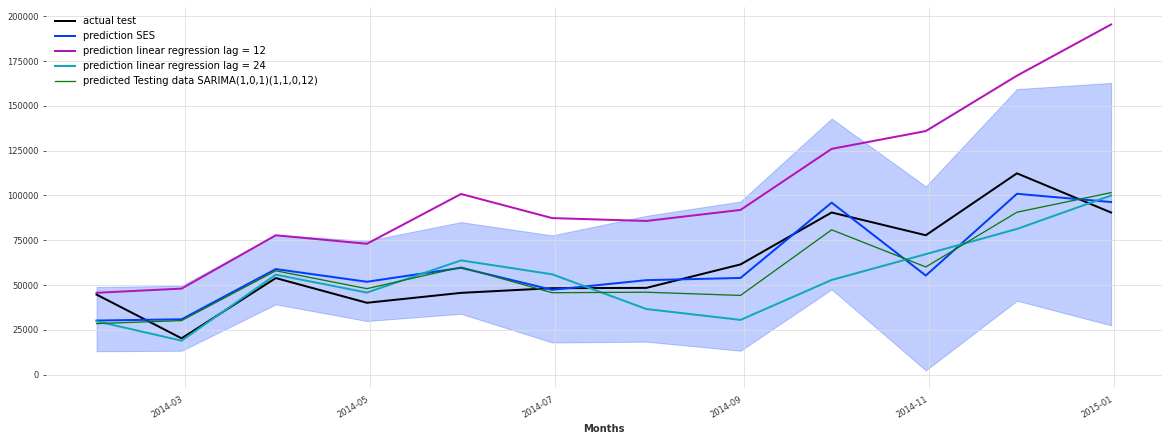

In [71]:
val.plot(label="actual test")
predictions_ses_test.plot(label="prediction SES")
prediction_lr.plot(label="prediction linear regression lag = 12")
prediction_lr_24.plot(label="prediction linear regression lag = 24")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")
plt.legend()

In [72]:
#test lag = 12
lr_r2score_test = r2_score(prediction_lr,series)
lr_mae_test = mae(prediction_lr,series)
lr_mape_test = mape(prediction_lr,series)
lr_rmse_test = rmse(prediction_lr,series)


#test lag = 24
lr_r2score_test_24 = r2_score(prediction_lr_24,series)
lr_mae_test_24 = mae(prediction_lr_24,series)
lr_mape_test_24 = mape(prediction_lr_24,series)
lr_rmse_test_24 = rmse(prediction_lr_24,series)


In [73]:
evaluation_lr_model = {
    "Models":["LR,lag=12","LR,lag=24"],
    "R2_score_test":[lr_r2score_test, lr_r2score_test_24],
    "MAE_test":[lr_mae_test, lr_mae_test_24],
    "RMSE_test":[lr_rmse_test, lr_rmse_test_24],
    "MAPE_test":[lr_mape_test, lr_mape_test_24],
}
evaluation_lr_model = pd.DataFrame(evaluation_lr_model).set_index("Models")
evaluation_lr_model

R2_score_test      MAE_test     RMSE_test  MAPE_test
Models                                                         
LR,lag=12      -0.228606  41703.699097  48233.488788  39.084772
LR,lag=24       0.261670  15091.531078  18985.499836  31.905839

**in this linear regression model we used  output_chunk_length = 1 which means we used the last 12 or 24 months to predict the next month 
but what would happen if we use output_chunk_length = 12 , wich means we used the last 12 or 24 months to predict the next 
12 months**

### Train linear regression model version 2

In [74]:
#lag = 12
model_lr_v2 = LinearRegressionModel(lags=12,
                                output_chunk_length=12,
                                )
model_lr_v2.fit(train)
prediction_lr_v2 = model_lr_v2.predict(len(val))



In [75]:
#lag = 24
model_lr_24_v2 = LinearRegressionModel(lags=24,
                                output_chunk_length=12,
                                )
model_lr_24_v2.fit(train)
prediction_lr_24_v2 = model_lr_24_v2.predict(len(val))



In [76]:
#lag = 3
model_lr_3_v2 = LinearRegressionModel(lags=3,
                                output_chunk_length=12,
                                )
model_lr_3_v2.fit(train)
prediction_lr_3_v2 = model_lr_3_v2.predict(len(val))



### Evaluate Linear regression model v2

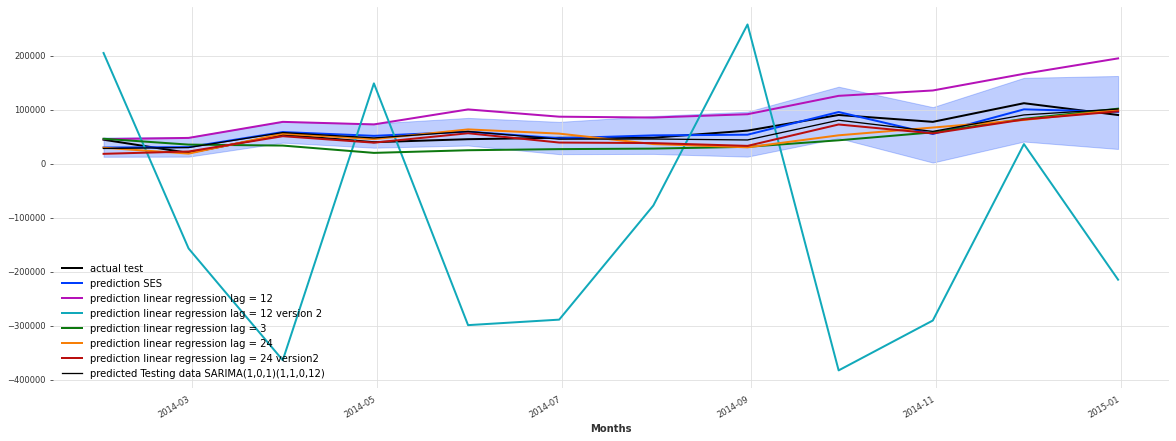

In [77]:
val.plot(label="actual test")
predictions_ses_test.plot(label="prediction SES")
prediction_lr.plot(label="prediction linear regression lag = 12")
prediction_lr_v2.plot(label="prediction linear regression lag = 12 version 2")
prediction_lr_3_v2.plot(label="prediction linear regression lag = 3 ")
prediction_lr_24.plot(label="prediction linear regression lag = 24")
prediction_lr_24_v2.plot(label="prediction linear regression lag = 24 version2")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")
plt.legend()

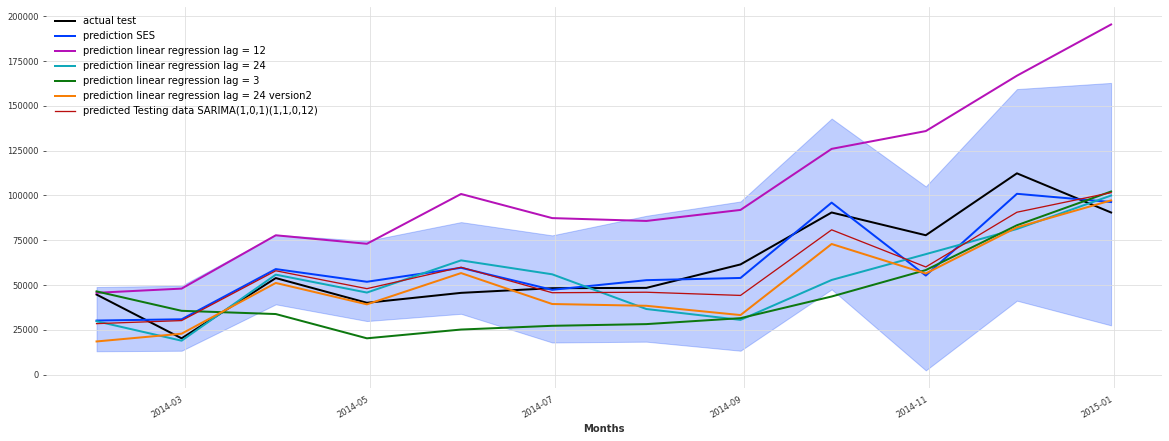

In [78]:
val.plot(label="actual test")
predictions_ses_test.plot(label="prediction SES")
prediction_lr.plot(label="prediction linear regression lag = 12")
prediction_lr_24.plot(label="prediction linear regression lag = 24")
prediction_lr_3_v2.plot(label="prediction linear regression lag = 3 ")

prediction_lr_24_v2.plot(label="prediction linear regression lag = 24 version2")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")
plt.legend()

In [79]:
#test lag = 12
lr_r2score_test_v2 = r2_score(prediction_lr_v2,series)
lr_mae_test_v2 = mae(prediction_lr_v2,series)
lr_mape_test_v2 = mape(prediction_lr_v2,series)
lr_rmse_test_v2 = rmse(prediction_lr_v2,series)


#test lag = 24
lr_r2score_test_24_v2 = r2_score(prediction_lr_24_v2,series)
lr_mae_test_24_v2 = mae(prediction_lr_24_v2,series)
lr_mape_test_24_v2 = mape(prediction_lr_24_v2,series)
lr_rmse_test_24_v2 = rmse(prediction_lr_24_v2,series)

#test lag = 24
lr_r2score_test_3_v2 = r2_score(prediction_lr_3_v2,series)
lr_mae_test_3_v2 = mae(prediction_lr_3_v2,series)
lr_mape_test_3_v2 = mape(prediction_lr_3_v2,series)
lr_rmse_test_3_v2 = rmse(prediction_lr_3_v2,series)


In [80]:
evaluation_lr_model_v2 = {
    "Models":["LR,lag=12,v2","LR,lag=24,v2","lR,lag=3,v2"],
    "R2_score_test":[lr_r2score_test_v2, lr_r2score_test_24_v2,lr_r2score_test_3_v2],
    "MAE_test":[lr_mae_test_v2, lr_mae_test_24_v2,lr_mae_test_3_v2],
    "RMSE_test":[lr_rmse_test_v2, lr_rmse_test_24_v2,lr_rmse_test_3_v2],
    "MAPE_test":[lr_mape_test_v2, lr_mape_test_24_v2,lr_mape_test_3_v2],
}
evaluation_lr_model_v2 = pd.DataFrame(evaluation_lr_model_v2).set_index("Models")
evaluation_lr_model_v2

R2_score_test       MAE_test      RMSE_test   MAPE_test
Models                                                               
LR,lag=12,v2      -0.716584  257510.193941  286980.706372  120.819638
LR,lag=24,v2       0.436841   13853.908533   17114.254366   34.848904
lR,lag=3,v2        0.023775   21302.025956   23719.791011   59.636532

## Machine learning 

### feature creation 

In [81]:
ml_data = general_data.copy()
ml_data.head()

Sales
2011-01-31  13946.229
2011-02-28   4810.558
2011-03-31  55691.009
2011-04-30  28295.345
2011-05-31  23648.287

In [82]:
ml_data["quarter"] = ml_data.index.quarter
ml_data["month"] = ml_data.index.month
ml_data["year"] = ml_data.index.year

Previously, using the pacf and acf plots, we observed that the first lag (in both acf and pacf) had a significant correlation, so we're going to add the previous month's sales to our data as a feature.

In [83]:
ml_data["previous_month"] = ml_data["Sales"].shift(+1) 


In [84]:
#our result : 
ml_data.head()

Sales  quarter  month  year  previous_month
2011-01-31  13946.229        1      1  2011             NaN
2011-02-28   4810.558        1      2  2011       13946.229
2011-03-31  55691.009        1      3  2011        4810.558
2011-04-30  28295.345        2      4  2011       55691.009
2011-05-31  23648.287        2      5  2011       28295.345

We got a null value in the first row of the "previous_month" column. We're going to use the average of sales in December to fill this value. 

In [85]:
ml_data.loc[ml_data.index.month == 12 ]

Sales  quarter  month  year  previous_month
2011-12-31  69545.6205        4     12  2011      78628.7167
2012-12-31  74919.5212        4     12  2012      75972.5635
2013-12-31  97237.4170        4     12  2013      82192.3228
2014-12-31  90474.6008        4     12  2014     112326.4710

In [86]:
#calculate the average
average_december = ml_data.loc[ml_data.index.month == 12 ]["Sales"].mean()
average_december

83044.289875

In [87]:
#filling the null value 

In [88]:
ml_data.isna().sum()

Sales             0
quarter           0
month             0
year              0
previous_month    1
dtype: int64

In [89]:
ml_data.fillna(average_december,inplace=True)

In [90]:
ml_data.head()

Sales  quarter  month  year  previous_month
2011-01-31  13946.229        1      1  2011    83044.289875
2011-02-28   4810.558        1      2  2011    13946.229000
2011-03-31  55691.009        1      3  2011     4810.558000
2011-04-30  28295.345        2      4  2011    55691.009000
2011-05-31  23648.287        2      5  2011    28295.345000

In [91]:
#### without previous month 

In [92]:
ml_data2 = ml_data.drop("previous_month",axis=1)
ml_data2.head()

Sales  quarter  month  year
2011-01-31  13946.229        1      1  2011
2011-02-28   4810.558        1      2  2011
2011-03-31  55691.009        1      3  2011
2011-04-30  28295.345        2      4  2011
2011-05-31  23648.287        2      5  2011

### create train and test dataset

In [93]:
ml_data_train = ml_data.iloc[:int(ml_data.shape[0]*0.75)] 
ml_data_test = ml_data.iloc[int(ml_data.shape[0]*0.75):]
print(f"train size {ml_data_train.shape[0]}")
print(f"test size {ml_data_test.shape[0]}")

train size 36
test size 12


In [94]:
#xtrain,y_train
x_train = ml_data_train.drop("Sales",axis=1)
y_train = ml_data_train["Sales"]

#xtest,y_test
x_test = ml_data_test.drop("Sales",axis=1)
y_test = ml_data_test["Sales"]


In [95]:
print(f"x_train's shape: {x_train.shape}")
print(f"x_test's shape: {x_test.shape}")      

x_train's shape: (36, 4)
x_test's shape: (12, 4)


In [96]:
#### without previous 

In [97]:
ml_data_train2 = ml_data2.iloc[:int(ml_data2.shape[0]*0.75)] 
ml_data_test2 = ml_data2.iloc[int(ml_data2.shape[0]*0.75):]
print(f"train size {ml_data_train2.shape[0]}")
print(f"test size {ml_data_test2.shape[0]}")

train size 36
test size 12


In [98]:
#xtrain,y_train
x_train2 = ml_data_train2.drop("Sales",axis=1)
y_train2 = ml_data_train2["Sales"]

#xtest,y_test
x_test2 = ml_data_test2.drop("Sales",axis=1)
y_test2 = ml_data_test2["Sales"]


### XGboost regressor

#### train models 

In [99]:
import xgboost as xgb 

In [100]:
xgb_model = xgb.XGBRegressor(n_estimators=1000000 ,
                            early_stopping_rounds = 4000,
                            learning_rate=0.001)
xgb_model.fit(x_train,y_train,
             eval_set=[(x_train,y_train),(x_test,y_test)],
             verbose= 10000)

[0]	validation_0-rmse:49111.40360	validation_1-rmse:66106.44463
[10000]	validation_0-rmse:223.57997	validation_1-rmse:18423.13776
[12966]	validation_0-rmse:60.39003	validation_1-rmse:18432.51329


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=4000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [101]:
print("Features imortance:")
pd.DataFrame(data = xgb_model.feature_importances_,
            index = xgb_model.feature_names_in_,
            columns=["importance"])

Features imortance:


importance
quarter           0.079890
month             0.823684
year              0.045479
previous_month    0.050947

#### forecast on test

In [102]:
ml_data_test["prediction_full_features"] = xgb_model.predict(x_test)

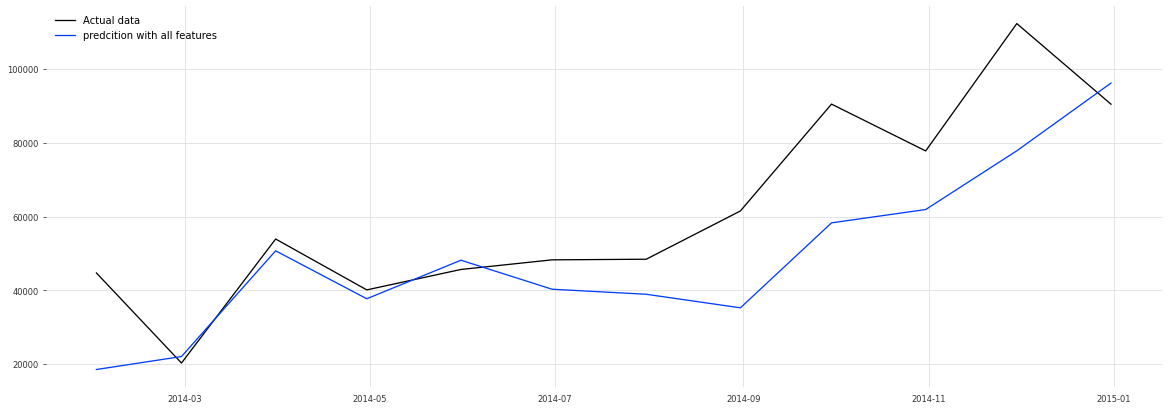

In [103]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["prediction_full_features"],label="predcition with all features")
plt.legend()

We observed that the first 5 predictions were very close. so rolling forecasts may return better forecasts.

#### Rolling forecast

In [104]:
train_features = ['quarter', 'month', 'year', 'previous_month']
test_features ='Sales'
#### rolling foreacast 
test_set_range= list(data_test.index)
#test_set_range.insert(0,data_train.index[-1])
#predictions 
y_pred_xgb = []
xgb_model_roll = xgb.XGBRegressor(n_estimators=1000000 ,
                        early_stopping_rounds = 4000,
                        learning_rate=0.001)
ml_data_train_roll = ml_data_train.copy()
prev_sale = ml_data_test.loc[ml_data_test.index[0]][test_features] 
for i in tqdm(range(x_test.shape[0])):
    x_train_roll, y_train_roll = ml_data_train_roll.drop("Sales",axis=1),ml_data_train_roll["Sales"]
    #x_train_roll , y_train_roll = ml_data.loc[:stop_date][train_features], ml_data.loc[:stop_date][test_features]
    x_test_roll = ml_data_test.loc[ml_data_test.index[i]][train_features].to_frame().transpose()
    if(i!=0):
        x_test_roll["previous_month"] = prev_sale
    
    #retrain the model
    xgb_model_roll.fit(x_train_roll,y_train_roll,
                     eval_set=[(x_train_roll,y_train_roll)],
                      verbose = False)
    pred = xgb_model_roll.predict(x_test_roll)
    y_pred_xgb.append(pred[0])
    
    #insert the predicted row with in the training data 
    x_test_roll["Sales"] = ml_data_test.loc[ml_data_test.index[i]][test_features]

    ml_data_train_roll = pd.concat([ml_data_train_roll,x_test_roll],axis=0)
    prev_sale = pred
    

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [06:09<00:00, 30.83s/it]


In [105]:
ml_data_test["y_pred_xgb_rolling"]=y_pred_xgb

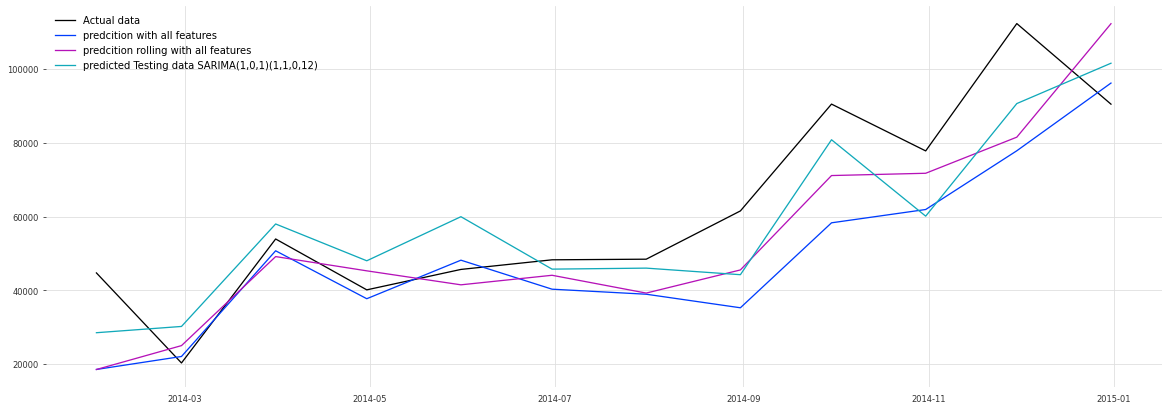

In [106]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["prediction_full_features"],label="predcition with all features")
plt.plot(ml_data_test["y_pred_xgb_rolling"],label="predcition rolling with all features")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

In [107]:
print("Features imortance:")
pd.DataFrame(data = xgb_model_roll.feature_importances_,
            index = xgb_model_roll.feature_names_in_,
            columns=["importance"])

Features imortance:


importance
quarter           0.021787
month             0.839823
year              0.086483
previous_month    0.051906

In [108]:
#####without previous month 

In [109]:
train_features = ['quarter', 'month', 'year']
ml_data_train[train_features].head() 

quarter  month  year
2011-01-31        1      1  2011
2011-02-28        1      2  2011
2011-03-31        1      3  2011
2011-04-30        2      4  2011
2011-05-31        2      5  2011

In [110]:
train_features = ['quarter', 'month', 'year']
test_features ='Sales'
#### rolling foreacast 
test_set_range= list(data_test.index)
#test_set_range.insert(0,data_train.index[-1])
#predictions 
y_pred_xgb_2 = []
xgb_model_roll = xgb.XGBRegressor(n_estimators=1000000 ,
                        early_stopping_rounds = 4000,
                        learning_rate=0.001)
ml_data_train_roll = ml_data_train2.copy()
#prev_sale = ml_data_test.loc[ml_data_test.index[0]][test_features] 
for i in tqdm(range(x_test.shape[0])):
    x_train_roll, y_train_roll = ml_data_train_roll.drop("Sales",axis=1),ml_data_train_roll["Sales"]
    #x_train_roll , y_train_roll = ml_data.loc[:stop_date][train_features], ml_data.loc[:stop_date][test_features]
    x_test_roll = ml_data_test.loc[ml_data_test.index[i]][train_features].to_frame().transpose()
    #if(i!=0):
    #    x_test_roll["previous_month"] = prev_sale
    
    #retrain the model
    xgb_model_roll.fit(x_train_roll,y_train_roll,
                     eval_set=[(x_train_roll,y_train_roll)],
                      verbose = False)
    pred = xgb_model_roll.predict(x_test_roll)
    y_pred_xgb_2.append(pred[0])
    
    #insert the predicted row with in the training data 
    x_test_roll["Sales"] = ml_data_test.loc[ml_data_test.index[i]][test_features]

    ml_data_train_roll = pd.concat([ml_data_train_roll,x_test_roll],axis=0)
    #prev_sale = pred
    

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [06:31<00:00, 32.60s/it]


In [111]:
ml_data_test["y_pred_xgb_rolling_2"]=y_pred_xgb_2

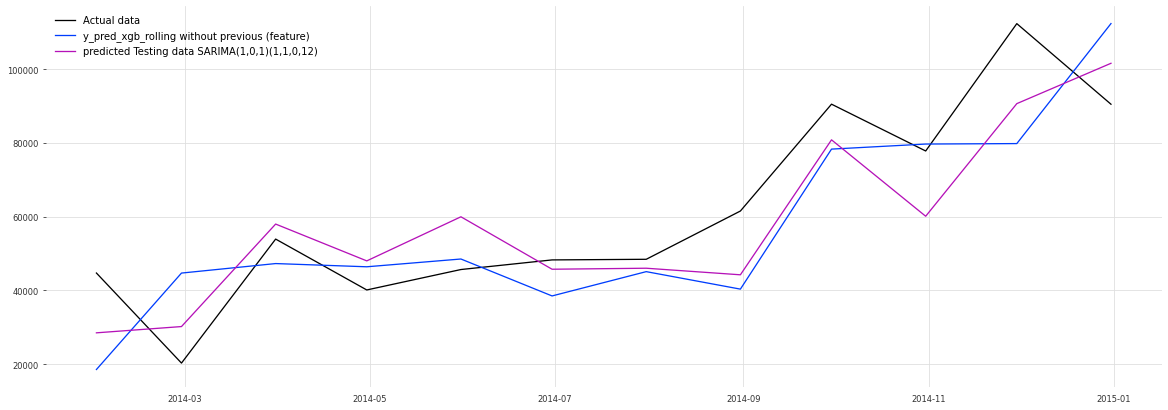

In [112]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["y_pred_xgb_rolling_2"],label="y_pred_xgb_rolling without previous (feature)")
#plt.plot(ml_data_test["y_pred_xgb_rolling"],label="predcition rolling with all features")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

In [113]:
print("Features imortance 2:")
pd.DataFrame(data = xgb_model_roll.feature_importances_,
            index = xgb_model_roll.feature_names_in_,
            columns=["importance"])

Features imortance 2:


importance
quarter    0.148078
month      0.770633
year       0.081289

#### evaluate xgboost regressor

based on the most important features , we'll drop the quarter feature 

In [114]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score ,mean_squared_error


In [115]:
#test lag = 12
xgb_r2score_test = r2_score(ml_data_test["Sales"], ml_data_test["prediction_full_features"])
xgb_mae_test = mean_absolute_error(ml_data_test["Sales"], ml_data_test["prediction_full_features"])
xgb_mape_test = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["prediction_full_features"])
xgb_rmse_test = mean_squared_error(ml_data_test["Sales"], ml_data_test["prediction_full_features"])


#test lag = 24
xgb_r2score_test_rolling = r2_score(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling"])
xgb_mae_test_rolling = mean_absolute_error(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling"])
xgb_mape_test_rolling = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling"])
xgb_rmse_test_rolling = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling"])


In [116]:
#without previous 
xgb_r2score_test_rolling_2 = r2_score(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling_2"])
xgb_mae_test_rolling_2 = mean_absolute_error(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling_2"])
xgb_mape_test_rolling_2 = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling_2"])
xgb_rmse_test_rolling_2  = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_xgb_rolling_2"])


In [117]:
evaluation_xgb_model = {
    "Models":["xgb normal","xgb rolling","xgb rolling 2"],
    "R2_score_test":[xgb_r2score_test, xgb_r2score_test_rolling,xgb_r2score_test_rolling_2],
    "MAE_test":[xgb_mae_test, xgb_mae_test_rolling,xgb_mae_test_rolling_2],
    "RMSE_test":[xgb_rmse_test, xgb_rmse_test_rolling,xgb_rmse_test_rolling_2],
    "MAPE_test":[xgb_mape_test, xgb_mape_test_rolling,xgb_mape_test_rolling_2],
}
evaluation_xgb_model = pd.DataFrame(evaluation_xgb_model).set_index("Models")
evaluation_xgb_model

R2_score_test      MAE_test     RMSE_test  MAPE_test
Models                                                             
xgb normal          0.466453  14006.995454  3.388316e+08   0.213764
xgb rolling         0.610246  12704.546376  2.475156e+08   0.205903
xgb rolling 2       0.525637  14091.497517  3.012469e+08   0.286398

### Random Forest regressor

#### model rfr

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
rfr_model = RandomForestRegressor(n_estimators=10000)
rfr_model.fit(x_train,y_train)

RandomForestRegressor(n_estimators=10000)

In [120]:
####  forecast on testset

In [121]:
ml_data_test["y_pred_rfr_regressor"] = rfr_model.predict(x_test)

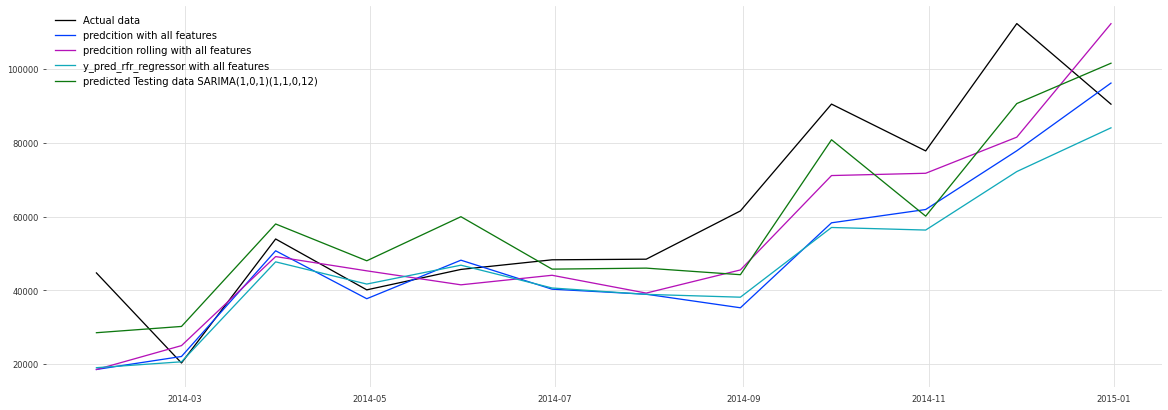

In [122]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["prediction_full_features"],label="predcition with all features")
plt.plot(ml_data_test["y_pred_xgb_rolling"],label="predcition rolling with all features")
plt.plot(ml_data_test["y_pred_rfr_regressor"],label="y_pred_rfr_regressor with all features")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

#### Rolling forecast

In [123]:
train_features = ['quarter', 'month', 'year', 'previous_month']
test_features ='Sales'
#### rolling foreacast 
test_set_range= list(data_test.index)
#test_set_range.insert(0,data_train.index[-1])
#predictions 
y_pred_rfr = []
rfr_model = RandomForestRegressor(n_estimators=10000)

ml_data_train_roll = ml_data_train.copy()
prev_sale = ml_data_test.loc[ml_data_test.index[0]][test_features] 
for i in tqdm(range(x_test.shape[0])):
    x_train_roll, y_train_roll = ml_data_train_roll.drop("Sales",axis=1),ml_data_train_roll["Sales"]
    #x_train_roll , y_train_roll = ml_data.loc[:stop_date][train_features], ml_data.loc[:stop_date][test_features]
    x_test_roll = ml_data_test.loc[ml_data_test.index[i]][train_features].to_frame().transpose()
    if(i!=0):
        x_test_roll["previous_month"] = prev_sale
    
    #retrain the model
    rfr_model.fit(x_train_roll,y_train_roll)
    
    pred = rfr_model.predict(x_test_roll)
    y_pred_rfr.append(pred[0])
    
    #insert the predicted row with in the training data 
    x_test_roll["Sales"] = ml_data_test.loc[ml_data_test.index[i]][test_features]

    ml_data_train_roll = pd.concat([ml_data_train_roll,x_test_roll],axis=0)
    prev_sale = pred
    

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:55<00:00, 24.62s/it]


In [124]:
ml_data_test["y_pred_rfr_rolling"]=y_pred_rfr

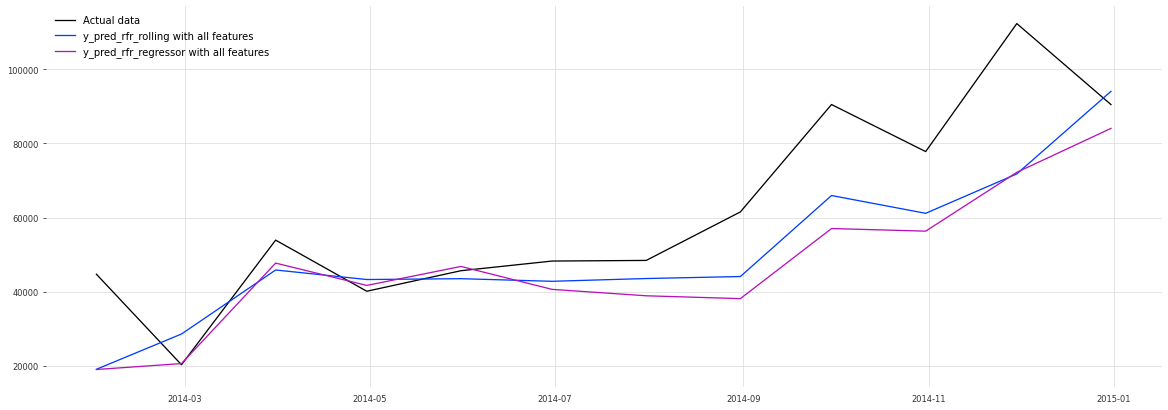

In [125]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["y_pred_rfr_rolling"],label="y_pred_rfr_rolling with all features")
#plt.plot(ml_data_test["y_pred_xgb_rolling"],label="predcition rolling with all features")
plt.plot(ml_data_test["y_pred_rfr_regressor"],label="y_pred_rfr_regressor with all features")
#plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

#### evaluate random forest regressor

In [126]:
#test lag = 12
rfr_r2score_test = r2_score(ml_data_test["Sales"], ml_data_test["y_pred_rfr_regressor"])
rfr_mae_test = mean_absolute_error(ml_data_test["Sales"], ml_data_test["y_pred_rfr_regressor"])
rfr_mape_test = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_rfr_regressor"])
rfr_rmse_test = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_rfr_regressor"])


#test lag = 24
rfr_r2score_test_rolling = r2_score(ml_data_test["Sales"], ml_data_test["y_pred_rfr_rolling"])
rfr_mae_test_rolling = mean_absolute_error(ml_data_test["Sales"], ml_data_test["y_pred_rfr_rolling"])
rfr_mape_test_rolling = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_rfr_rolling"])
rfr_rmse_test_rolling = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_rfr_rolling"])


In [127]:
evaluation_rfr_model = {
    "Models":["rfr normal","rfr rolling"],
    "R2_score_test":[rfr_r2score_test, rfr_r2score_test_rolling],
    "MAE_test":[rfr_mae_test, rfr_mae_test_rolling],
    "RMSE_test":[rfr_rmse_test, rfr_rmse_test_rolling],
    "MAPE_test":[rfr_mape_test, rfr_mape_test_rolling],
}
evaluation_rfr_model = pd.DataFrame(evaluation_rfr_model).set_index("Models")
evaluation_rfr_model

R2_score_test      MAE_test     RMSE_test  MAPE_test
Models                                                           
rfr normal        0.392189  14750.156216  3.859934e+08   0.214972
rfr rolling       0.514341  13368.272388  3.084201e+08   0.220105

### Linear regression 

#### model

In [128]:
from sklearn.linear_model import LinearRegression

In [129]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)

LinearRegression()

####  forecast on testset

In [130]:
ml_data_test["y_pred_lr"] = lr_model.predict(x_test)

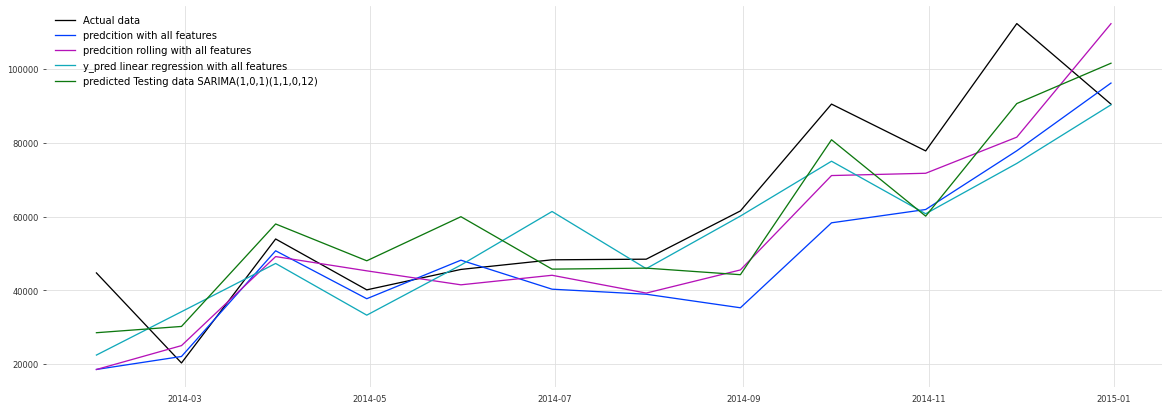

In [131]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["prediction_full_features"],label="predcition with all features")
plt.plot(ml_data_test["y_pred_xgb_rolling"],label="predcition rolling with all features")
plt.plot(ml_data_test["y_pred_lr"],label="y_pred linear regression with all features")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

#### Rolling forecast

In [132]:
train_features = ['quarter', 'month', 'year', 'previous_month']
test_features ='Sales'
#### rolling foreacast 
test_set_range= list(data_test.index)
#test_set_range.insert(0,data_train.index[-1])
#predictions 
y_pred_lr = []
lr_model = LinearRegression()

ml_data_train_roll = ml_data_train.copy()
prev_sale = ml_data_test.loc[ml_data_test.index[0]][test_features] 
for i in tqdm(range(x_test.shape[0])):
    x_train_roll, y_train_roll = ml_data_train_roll.drop("Sales",axis=1),ml_data_train_roll["Sales"]
    #x_train_roll , y_train_roll = ml_data.loc[:stop_date][train_features], ml_data.loc[:stop_date][test_features]
    x_test_roll = ml_data_test.loc[ml_data_test.index[i]][train_features].to_frame().transpose()
    if(i!=0):
        x_test_roll["previous_month"] = prev_sale
    
    #retrain the model
    lr_model.fit(x_train_roll,y_train_roll)
    
    pred = lr_model.predict(x_test_roll)
    y_pred_lr.append(pred[0])
    
    #insert the predicted row with in the training data 
    x_test_roll["Sales"] = ml_data_test.loc[ml_data_test.index[i]][test_features]

    ml_data_train_roll = pd.concat([ml_data_train_roll,x_test_roll],axis=0)
    prev_sale = pred
    

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.80it/s]


In [133]:
ml_data_test["y_pred_lr_rolling"]=y_pred_lr

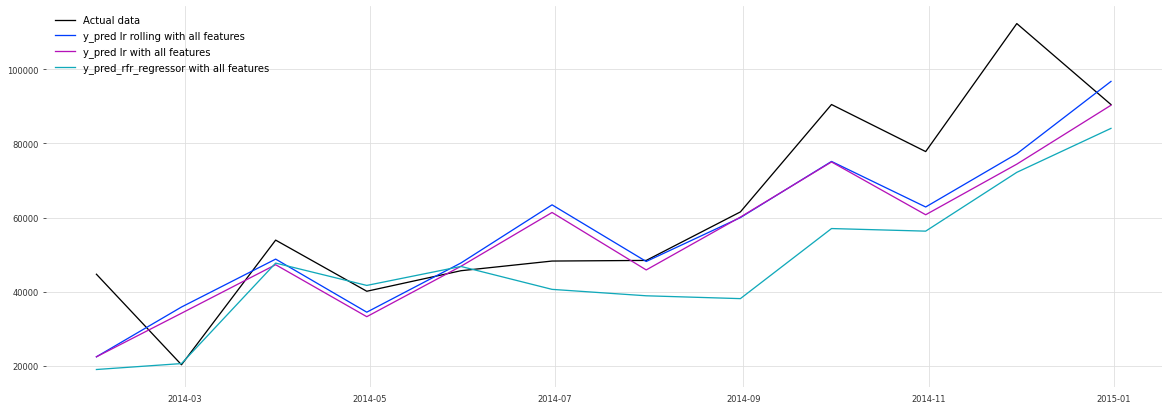

In [134]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["y_pred_lr_rolling"],label="y_pred lr rolling with all features")
plt.plot(ml_data_test["y_pred_lr"],label="y_pred lr with all features")
#plt.plot(ml_data_test["y_pred_xgb_rolling"],label="predcition rolling with all features")
plt.plot(ml_data_test["y_pred_rfr_regressor"],label="y_pred_rfr_regressor with all features")
#plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

#### Evaluate lr

In [135]:
#test lag = 12
lr_r2score_test = r2_score(ml_data_test["Sales"], ml_data_test["y_pred_lr"])
lr_mae_test = mean_absolute_error(ml_data_test["Sales"], ml_data_test["y_pred_lr"])
lr_mape_test = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_lr"])
lr_rmse_test = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_lr"])


#test lag = 24
lr_r2score_test_rolling = r2_score(ml_data_test["Sales"], ml_data_test["y_pred_lr_rolling"])
lr_mae_test_rolling = mean_absolute_error(ml_data_test["Sales"], ml_data_test["y_pred_lr_rolling"])
lr_mape_test_rolling = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_lr_rolling"])
lr_rmse_test_rolling = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_lr_rolling"])


In [136]:
evaluation_lr_model = {
    "Models":["rfr normal","rfr rolling"],
    "R2_score_test":[lr_r2score_test, lr_r2score_test_rolling],
    "MAE_test":[lr_mae_test, lr_mae_test_rolling],
    "RMSE_test":[lr_rmse_test, lr_rmse_test_rolling],
    "MAPE_test":[lr_mape_test, lr_mape_test_rolling],
}
evaluation_lr_model = pd.DataFrame(evaluation_lr_model).set_index("Models")
evaluation_lr_model

R2_score_test      MAE_test     RMSE_test  MAPE_test
Models                                                           
rfr normal        0.615397  11547.233942  2.442441e+08   0.215073
rfr rolling       0.637116  11613.265428  2.304515e+08   0.219678

### KNN

#### model

In [137]:
from sklearn.neighbors import KNeighborsRegressor

In [138]:
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(x_train,y_train )

KNeighborsRegressor(n_neighbors=3)

In [139]:
ml_data_test["y_pred_knn_regressor"] = knn_model.predict(x_test)

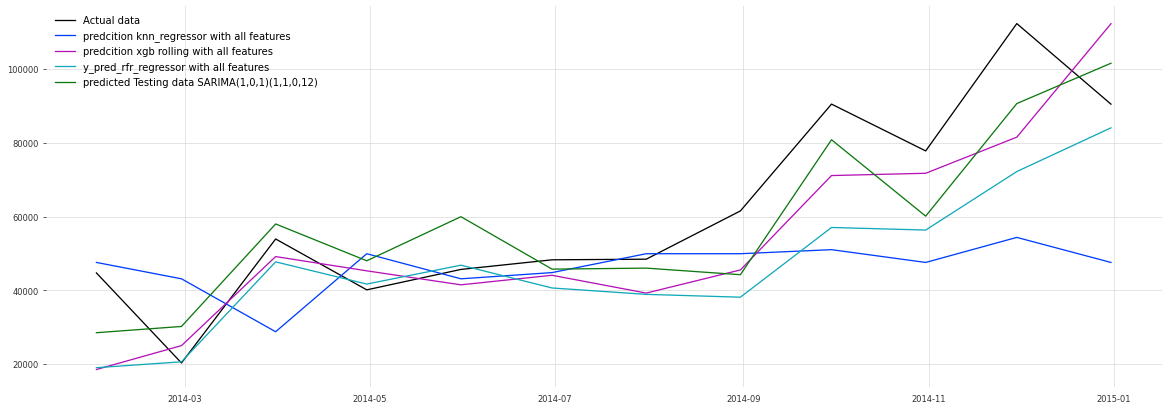

In [140]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["y_pred_knn_regressor"],label="predcition knn_regressor with all features")
plt.plot(ml_data_test["y_pred_xgb_rolling"],label="predcition xgb rolling with all features")
plt.plot(ml_data_test["y_pred_rfr_regressor"],label="y_pred_rfr_regressor with all features")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend()

#### Rolling forecast 

In [141]:
train_features = ['quarter', 'month', 'year', 'previous_month']
test_features ='Sales'
#### rolling foreacast 
test_set_range= list(data_test.index)
#test_set_range.insert(0,data_train.index[-1])
#predictions 
y_pred_knn = []
knn_model = KNeighborsRegressor(n_neighbors=3)

ml_data_train_roll = ml_data_train.copy()
prev_sale = ml_data_test.loc[ml_data_test.index[0]][test_features] 
for i in tqdm(range(x_test.shape[0])):
    x_train_roll, y_train_roll = ml_data_train_roll.drop("Sales",axis=1),ml_data_train_roll["Sales"]
    #x_train_roll , y_train_roll = ml_data.loc[:stop_date][train_features], ml_data.loc[:stop_date][test_features]
    x_test_roll = ml_data_test.loc[ml_data_test.index[i]][train_features].to_frame().transpose()
    if(i!=0):
        x_test_roll["previous_month"] = prev_sale
    
    #retrain the model
    knn_model.fit(x_train_roll,y_train_roll)
    
    pred = knn_model.predict(x_test_roll)
    y_pred_knn.append(pred[0])
    
    #insert the predicted row with in the training data 
    x_test_roll["Sales"] = ml_data_test.loc[ml_data_test.index[i]][test_features]

    ml_data_train_roll = pd.concat([ml_data_train_roll,x_test_roll],axis=0)
    prev_sale = pred
    

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 77.29it/s]


In [142]:
ml_data_test["y_pred_knn_rolling"]=y_pred_knn

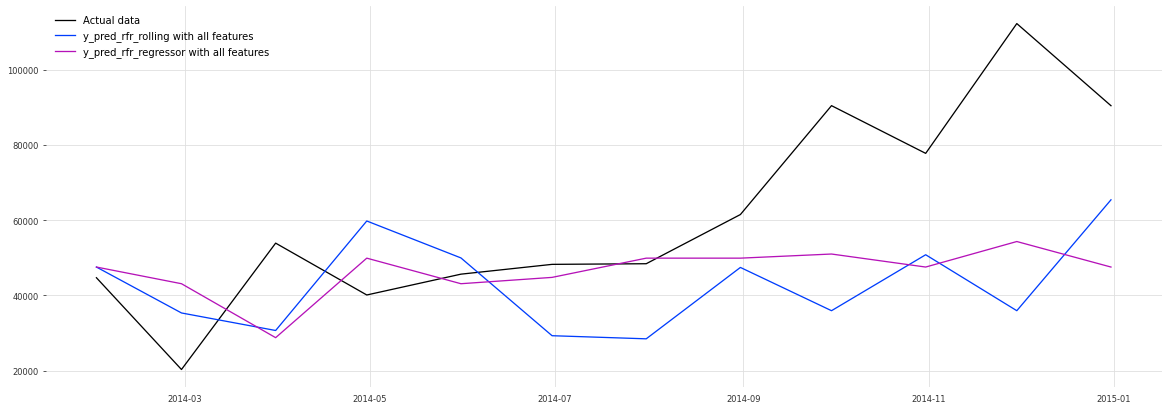

In [143]:
plt.plot(ml_data_test["Sales"],label="Actual data")
plt.plot(ml_data_test["y_pred_knn_rolling"],label="y_pred_rfr_rolling with all features")
plt.plot(ml_data_test["y_pred_knn_regressor"],label="y_pred_rfr_regressor with all features")

plt.legend()

#### evaluate knn regressor

In [144]:
#test lag = 12
knn_r2score_test = r2_score(ml_data_test["Sales"],ml_data_test["y_pred_knn_regressor"])
knn_mae_test = mean_absolute_error(ml_data_test["Sales"],ml_data_test["y_pred_knn_regressor"])
knn_mape_test = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_knn_regressor"])
knn_rmse_test = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_knn_regressor"])


#test lag = 24
knn_r2score_test_rolling = r2_score(ml_data_test["Sales"],ml_data_test["y_pred_knn_rolling"])
knn_mae_test_rolling = mean_absolute_error(ml_data_test["Sales"], ml_data_test["y_pred_knn_rolling"])
knn_mape_test_rolling = mean_absolute_percentage_error(ml_data_test["Sales"], ml_data_test["y_pred_knn_rolling"])
knn_rmse_test_rolling = mean_squared_error(ml_data_test["Sales"], ml_data_test["y_pred_knn_rolling"])


In [145]:
evaluation_knn_model = {
    "Models":["knn normal","knn rolling"],
    "R2_score_test":[knn_r2score_test, knn_r2score_test_rolling],
    "MAE_test":[knn_mae_test, knn_mae_test_rolling],
    "RMSE_test":[knn_rmse_test, knn_rmse_test_rolling],
    "MAPE_test":[knn_mape_test, knn_mape_test_rolling],
}
evaluation_knn_model = pd.DataFrame(evaluation_knn_model).set_index("Models")
evaluation_knn_model

R2_score_test      MAE_test     RMSE_test  MAPE_test
Models                                                           
knn normal       -0.193145  20863.752822  7.577127e+08   0.338539
knn rolling      -0.614889  25096.141961  1.025544e+09   0.396945

### LSTM 2

#### train lstm

In [602]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.losses import mean_squared_error as mse
from tensorflow.keras.metrics import R2Score , RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import keras 

In [436]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [542]:
# define generator 
n_input = 12 
n_features = 1 
generator = TimeseriesGenerator(data_train["Sales"],data_train['Sales'], length=n_input,batch_size=1)
#we are using the last 12 month to predict the next month 

In [543]:
keras.utils.set_random_seed(812)

model_lstm = Sequential()
model_lstm.add(InputLayer((n_input,n_features)))
model_lstm.add(Bidirectional(LSTM(200,activation='relu',return_sequences=False, kernel_regularizer=l2(0.001),
                                         recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))))

#model_lstm.add(Dropout(0.3))
#model_lstm.add(LSTM(120,activation='relu',return_sequences=False, kernel_regularizer=l2(0.001)))
model_lstm.add(Dense(100,activation='relu', kernel_regularizer=l2(0.001)))
#model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(4,activation='relu', kernel_regularizer=l2(0.001)))



model_lstm.add(Dense(1))
#model_lstm.compile(loss="mean_squared_error",optimizer="adam",metrics=["mape"])
model_lstm.compile(loss="mean_squared_error",optimizer=Adam(0.001),metrics=["mape"])
#model_lstm.compile(loss="mean_squared_error",optimizer=Adam(0.00001),metrics=[R2Score(),RootMeanSquaredError()])
model_lstm.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_35 (Bidirect  (None, 400)               323200    
 ional)                                                          
                                                                 
 dense_83 (Dense)            (None, 100)               40100     
                                                                 
 dense_84 (Dense)            (None, 4)                 404       
                                                                 
 dense_85 (Dense)            (None, 1)                 5         
                                                                 
Total params: 363709 (1.39 MB)
Trainable params: 363709 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [544]:
ES = EarlyStopping(monitor="loss", verbose=1,
                      patience=500, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=200, min_lr=0.00001)

In [545]:
model_lstm.fit(generator,epochs=2000,callbacks=[ES,reduce_lr])

Epoch 1/2000
24/24 [==============================] - 3s 15ms/step - loss: 1409591168.0000 - mape: 71.7327 - lr: 0.0010
Epoch 2/2000
24/24 [==============================] - 0s 17ms/step - loss: 614746432.0000 - mape: 44.7556 - lr: 0.0010
Epoch 3/2000
24/24 [==============================] - 0s 16ms/step - loss: 388791712.0000 - mape: 48.1209 - lr: 0.0010
Epoch 4/2000
24/24 [==============================] - 0s 17ms/step - loss: 332789120.0000 - mape: 41.7964 - lr: 0.0010
Epoch 5/2000
24/24 [==============================] - 0s 18ms/step - loss: 518077344.0000 - mape: 41.5482 - lr: 0.0010
Epoch 6/2000
24/24 [==============================] - 0s 14ms/step - loss: 357614112.0000 - mape: 38.4751 - lr: 0.0010
Epoch 7/2000
24/24 [==============================] - 0s 17ms/step - loss: 521841696.0000 - mape: 46.9321 - lr: 0.0010
Epoch 8/2000
24/24 [==============================] - 0s 14ms/step - loss: 271747040.0000 - mape: 37.1060 - lr: 0.0010
Epoch 9/2000
24/24 [===========================

24/24 [==============================] - 0s 14ms/step - loss: 146188320.0000 - mape: 24.9038 - lr: 0.0010
Epoch 138/2000
24/24 [==============================] - 0s 15ms/step - loss: 184786240.0000 - mape: 31.5797 - lr: 0.0010
Epoch 139/2000
24/24 [==============================] - 0s 14ms/step - loss: 94855512.0000 - mape: 19.0342 - lr: 0.0010
Epoch 140/2000
24/24 [==============================] - 0s 14ms/step - loss: 102724328.0000 - mape: 20.3649 - lr: 0.0010
Epoch 141/2000
24/24 [==============================] - 0s 15ms/step - loss: 72728760.0000 - mape: 16.3979 - lr: 0.0010
Epoch 142/2000
24/24 [==============================] - 0s 14ms/step - loss: 50889308.0000 - mape: 17.3049 - lr: 0.0010
Epoch 143/2000
24/24 [==============================] - 0s 14ms/step - loss: 54661932.0000 - mape: 14.3799 - lr: 0.0010
Epoch 144/2000
24/24 [==============================] - 0s 14ms/step - loss: 41420608.0000 - mape: 11.4964 - lr: 0.0010
Epoch 145/2000
24/24 [==============================

Epoch 206/2000
24/24 [==============================] - 0s 14ms/step - loss: 3263802.0000 - mape: 3.9472 - lr: 0.0010
Epoch 207/2000
24/24 [==============================] - 0s 14ms/step - loss: 8655728.0000 - mape: 6.5121 - lr: 0.0010
Epoch 208/2000
24/24 [==============================] - 0s 14ms/step - loss: 18587618.0000 - mape: 9.2765 - lr: 0.0010
Epoch 209/2000
24/24 [==============================] - 0s 14ms/step - loss: 12020977.0000 - mape: 7.7854 - lr: 0.0010
Epoch 210/2000
24/24 [==============================] - 0s 14ms/step - loss: 9575611.0000 - mape: 7.0154 - lr: 0.0010
Epoch 211/2000
24/24 [==============================] - 0s 14ms/step - loss: 8925280.0000 - mape: 6.9606 - lr: 0.0010
Epoch 212/2000
24/24 [==============================] - 0s 14ms/step - loss: 4415804.5000 - mape: 4.5748 - lr: 0.0010
Epoch 213/2000
24/24 [==============================] - 0s 15ms/step - loss: 2460429.0000 - mape: 3.9167 - lr: 0.0010
Epoch 214/2000
24/24 [==============================] 

24/24 [==============================] - 0s 14ms/step - loss: 695275.7500 - mape: 1.5063 - lr: 0.0010
Epoch 345/2000
24/24 [==============================] - 0s 14ms/step - loss: 492297.3750 - mape: 1.5749 - lr: 0.0010
Epoch 346/2000
24/24 [==============================] - 0s 14ms/step - loss: 294729.7188 - mape: 1.3396 - lr: 0.0010
Epoch 347/2000
24/24 [==============================] - 0s 14ms/step - loss: 174514.7344 - mape: 0.6869 - lr: 0.0010
Epoch 348/2000
24/24 [==============================] - 0s 14ms/step - loss: 213287.7656 - mape: 0.8961 - lr: 0.0010
Epoch 349/2000
24/24 [==============================] - 0s 14ms/step - loss: 1349091.6250 - mape: 2.7177 - lr: 0.0010
Epoch 350/2000
24/24 [==============================] - 0s 14ms/step - loss: 623721.0000 - mape: 1.6879 - lr: 0.0010
Epoch 351/2000
24/24 [==============================] - 0s 14ms/step - loss: 980306.9375 - mape: 2.2443 - lr: 0.0010
Epoch 352/2000
24/24 [==============================] - 0s 14ms/step - loss: 9

Epoch 483/2000
24/24 [==============================] - 0s 14ms/step - loss: 664762.5000 - mape: 1.6848 - lr: 0.0010
Epoch 484/2000
24/24 [==============================] - 0s 15ms/step - loss: 679477.6875 - mape: 1.6379 - lr: 0.0010
Epoch 485/2000
24/24 [==============================] - 0s 14ms/step - loss: 578011.6875 - mape: 1.0908 - lr: 0.0010
Epoch 486/2000
24/24 [==============================] - 0s 14ms/step - loss: 373788.6562 - mape: 1.3176 - lr: 0.0010
Epoch 487/2000
24/24 [==============================] - 0s 15ms/step - loss: 352088.0938 - mape: 1.1832 - lr: 0.0010
Epoch 488/2000
24/24 [==============================] - 0s 14ms/step - loss: 222476.2656 - mape: 0.9038 - lr: 0.0010
Epoch 489/2000
24/24 [==============================] - 0s 14ms/step - loss: 105857.5859 - mape: 0.7475 - lr: 0.0010
Epoch 490/2000
24/24 [==============================] - 0s 16ms/step - loss: 120204.9609 - mape: 0.7284 - lr: 0.0010
Epoch 491/2000
24/24 [==============================] - 0s 18ms/

24/24 [==============================] - 0s 15ms/step - loss: 122502.8359 - mape: 0.7256 - lr: 0.0010
Epoch 623/2000
24/24 [==============================] - 0s 14ms/step - loss: 92934.2500 - mape: 0.5808 - lr: 0.0010
Epoch 624/2000
24/24 [==============================] - 0s 14ms/step - loss: 209703.5625 - mape: 0.9083 - lr: 0.0010
Epoch 625/2000
24/24 [==============================] - 0s 15ms/step - loss: 162995.0156 - mape: 0.7430 - lr: 0.0010
Epoch 626/2000
24/24 [==============================] - 0s 15ms/step - loss: 344591.9375 - mape: 1.0274 - lr: 0.0010
Epoch 627/2000
24/24 [==============================] - 0s 15ms/step - loss: 585424.5000 - mape: 1.5881 - lr: 0.0010
Epoch 628/2000
24/24 [==============================] - 0s 15ms/step - loss: 592290.8125 - mape: 1.8163 - lr: 0.0010
Epoch 629/2000
24/24 [==============================] - 0s 15ms/step - loss: 374704.3750 - mape: 1.6530 - lr: 0.0010
Epoch 630/2000
24/24 [==============================] - 0s 15ms/step - loss: 606

Epoch 692/2000
24/24 [==============================] - 0s 14ms/step - loss: 3267851.0000 - mape: 4.5397 - lr: 0.0010
Epoch 693/2000
24/24 [==============================] - 0s 15ms/step - loss: 5463571.5000 - mape: 5.4441 - lr: 0.0010
Epoch 694/2000
24/24 [==============================] - 0s 15ms/step - loss: 4043964.7500 - mape: 4.0116 - lr: 0.0010
Epoch 695/2000
24/24 [==============================] - 0s 15ms/step - loss: 3372097.7500 - mape: 3.6221 - lr: 0.0010
Epoch 696/2000
24/24 [==============================] - 0s 14ms/step - loss: 8049254.5000 - mape: 5.7518 - lr: 0.0010
Epoch 697/2000
24/24 [==============================] - 0s 14ms/step - loss: 6502532.0000 - mape: 6.3079 - lr: 0.0010
Epoch 698/2000
24/24 [==============================] - 0s 15ms/step - loss: 2416982.7500 - mape: 3.0657 - lr: 0.0010
Epoch 699/2000
24/24 [==============================] - 0s 15ms/step - loss: 668624.5625 - mape: 1.9781 - lr: 0.0010
Epoch 700/2000
24/24 [==============================] - 0

24/24 [==============================] - 0s 15ms/step - loss: 531.1899 - mape: 0.0625 - lr: 1.0000e-04
Epoch 830/2000
24/24 [==============================] - 0s 15ms/step - loss: 528.9359 - mape: 0.0629 - lr: 1.0000e-04
Epoch 831/2000
24/24 [==============================] - 0s 15ms/step - loss: 495.3885 - mape: 0.0577 - lr: 1.0000e-04
Epoch 832/2000
24/24 [==============================] - 0s 15ms/step - loss: 445.5514 - mape: 0.0558 - lr: 1.0000e-04
Epoch 833/2000
24/24 [==============================] - 0s 15ms/step - loss: 393.5446 - mape: 0.0523 - lr: 1.0000e-04
Epoch 834/2000
24/24 [==============================] - 0s 15ms/step - loss: 392.5312 - mape: 0.0526 - lr: 1.0000e-04
Epoch 835/2000
24/24 [==============================] - 0s 14ms/step - loss: 346.1543 - mape: 0.0490 - lr: 1.0000e-04
Epoch 836/2000
24/24 [==============================] - 0s 15ms/step - loss: 363.4061 - mape: 0.0503 - lr: 1.0000e-04
Epoch 837/2000
24/24 [==============================] - 0s 15ms/step - 

24/24 [==============================] - 0s 14ms/step - loss: 42291.8516 - mape: 0.5019 - lr: 1.0000e-04
Epoch 968/2000
24/24 [==============================] - 0s 15ms/step - loss: 27093.8594 - mape: 0.3329 - lr: 1.0000e-04
Epoch 969/2000
24/24 [==============================] - 0s 14ms/step - loss: 27982.4707 - mape: 0.3757 - lr: 1.0000e-04
Epoch 970/2000
24/24 [==============================] - 0s 14ms/step - loss: 16503.6035 - mape: 0.3008 - lr: 1.0000e-04
Epoch 971/2000
24/24 [==============================] - 0s 15ms/step - loss: 24864.1406 - mape: 0.3521 - lr: 1.0000e-04
Epoch 972/2000
24/24 [==============================] - 0s 14ms/step - loss: 34915.2344 - mape: 0.3850 - lr: 1.0000e-04
Epoch 973/2000
24/24 [==============================] - 0s 14ms/step - loss: 48386.8477 - mape: 0.5269 - lr: 1.0000e-04
Epoch 974/2000
24/24 [==============================] - 0s 15ms/step - loss: 21747.6426 - mape: 0.2726 - lr: 1.0000e-04
Epoch 975/2000
24/24 [==============================] -

24/24 [==============================] - 0s 14ms/step - loss: 10128.3877 - mape: 0.2246 - lr: 1.0000e-04
Epoch 1105/2000
24/24 [==============================] - 0s 15ms/step - loss: 29271.6172 - mape: 0.2553 - lr: 1.0000e-04
Epoch 1106/2000
24/24 [==============================] - 0s 15ms/step - loss: 55503.8750 - mape: 0.5627 - lr: 1.0000e-04
Epoch 1107/2000
24/24 [==============================] - 0s 14ms/step - loss: 89593.6562 - mape: 0.7001 - lr: 1.0000e-04
Epoch 1108/2000
24/24 [==============================] - 0s 15ms/step - loss: 633197.5000 - mape: 1.3153 - lr: 1.0000e-04
Epoch 1109/2000
24/24 [==============================] - 0s 15ms/step - loss: 487860.2500 - mape: 1.4589 - lr: 1.0000e-04
Epoch 1110/2000
24/24 [==============================] - 0s 15ms/step - loss: 116931.5547 - mape: 0.7401 - lr: 1.0000e-04
Epoch 1111/2000
24/24 [==============================] - 0s 15ms/step - loss: 117756.3203 - mape: 0.7193 - lr: 1.0000e-04
Epoch 1112/2000
24/24 [=====================

Epoch 1173/2000
24/24 [==============================] - 0s 14ms/step - loss: 36609.2461 - mape: 0.3631 - lr: 1.0000e-04
Epoch 1174/2000
24/24 [==============================] - 0s 15ms/step - loss: 44810.0039 - mape: 0.4556 - lr: 1.0000e-04
Epoch 1175/2000
24/24 [==============================] - 0s 14ms/step - loss: 60371.0039 - mape: 0.5700 - lr: 1.0000e-04
Epoch 1176/2000
24/24 [==============================] - 0s 14ms/step - loss: 56588.0117 - mape: 0.5429 - lr: 1.0000e-04
Epoch 1177/2000
24/24 [==============================] - 0s 14ms/step - loss: 39087.3242 - mape: 0.4799 - lr: 1.0000e-04
Epoch 1178/2000
24/24 [==============================] - 0s 14ms/step - loss: 52857.0938 - mape: 0.3951 - lr: 1.0000e-04
Epoch 1179/2000
24/24 [==============================] - 0s 14ms/step - loss: 78359.8750 - mape: 0.6112 - lr: 1.0000e-04
Epoch 1180/2000
24/24 [==============================] - 0s 14ms/step - loss: 135236.8594 - mape: 0.6915 - lr: 1.0000e-04
Epoch 1181/2000
24/24 [========

24/24 [==============================] - 0s 14ms/step - loss: 3869.6189 - mape: 0.1244 - lr: 1.0000e-04
Epoch 1242/2000
24/24 [==============================] - 0s 14ms/step - loss: 1347.1620 - mape: 0.0692 - lr: 1.0000e-04
Epoch 1243/2000
24/24 [==============================] - 0s 14ms/step - loss: 1073.9984 - mape: 0.0844 - lr: 1.0000e-04
Epoch 1244/2000
24/24 [==============================] - 0s 14ms/step - loss: 730.0115 - mape: 0.0658 - lr: 1.0000e-04
Epoch 1245/2000
24/24 [==============================] - 0s 14ms/step - loss: 847.8625 - mape: 0.0723 - lr: 1.0000e-04
Epoch 1246/2000
24/24 [==============================] - 0s 14ms/step - loss: 1147.0127 - mape: 0.0674 - lr: 1.0000e-04
Epoch 1247/2000
24/24 [==============================] - 0s 14ms/step - loss: 1819.0049 - mape: 0.0919 - lr: 1.0000e-04
Epoch 1248/2000
24/24 [==============================] - 0s 14ms/step - loss: 4636.7646 - mape: 0.1356 - lr: 1.0000e-04
Epoch 1249/2000
24/24 [==============================] - 0

24/24 [==============================] - 0s 14ms/step - loss: 1860.9301 - mape: 0.1113 - lr: 1.0000e-04
Epoch 1310/2000
24/24 [==============================] - 0s 14ms/step - loss: 900.1915 - mape: 0.0678 - lr: 1.0000e-04
Epoch 1311/2000
24/24 [==============================] - 0s 14ms/step - loss: 767.1829 - mape: 0.0595 - lr: 1.0000e-04
Epoch 1312/2000
24/24 [==============================] - 0s 14ms/step - loss: 273.5435 - mape: 0.0347 - lr: 1.0000e-04
Epoch 1313/2000
24/24 [==============================] - 0s 14ms/step - loss: 757.7661 - mape: 0.0604 - lr: 1.0000e-04
Epoch 1314/2000
24/24 [==============================] - 0s 14ms/step - loss: 745.0906 - mape: 0.0469 - lr: 1.0000e-04
Epoch 1315/2000
24/24 [==============================] - 0s 14ms/step - loss: 515.0034 - mape: 0.0517 - lr: 1.0000e-04
Epoch 1316/2000
24/24 [==============================] - 0s 14ms/step - loss: 287.2209 - mape: 0.0441 - lr: 1.0000e-04
Epoch 1317/2000
24/24 [==============================] - 0s 13m

24/24 [==============================] - 0s 14ms/step - loss: 4.7580 - mape: 0.0045 - lr: 1.0000e-05
Epoch 1447/2000
24/24 [==============================] - 0s 14ms/step - loss: 4.4934 - mape: 0.0042 - lr: 1.0000e-05
Epoch 1448/2000
24/24 [==============================] - 0s 14ms/step - loss: 5.0764 - mape: 0.0045 - lr: 1.0000e-05
Epoch 1449/2000
24/24 [==============================] - 0s 14ms/step - loss: 4.0964 - mape: 0.0041 - lr: 1.0000e-05
Epoch 1450/2000
24/24 [==============================] - 0s 15ms/step - loss: 3.8455 - mape: 0.0039 - lr: 1.0000e-05
Epoch 1451/2000
24/24 [==============================] - 0s 14ms/step - loss: 3.4829 - mape: 0.0038 - lr: 1.0000e-05
Epoch 1452/2000
24/24 [==============================] - 0s 14ms/step - loss: 3.3205 - mape: 0.0036 - lr: 1.0000e-05
Epoch 1453/2000
24/24 [==============================] - 0s 14ms/step - loss: 3.1544 - mape: 0.0036 - lr: 1.0000e-05
Epoch 1454/2000
24/24 [==============================] - 0s 14ms/step - loss: 2.

24/24 [==============================] - 0s 14ms/step - loss: 25.0852 - mape: 0.0109 - lr: 1.0000e-05
Epoch 1585/2000
24/24 [==============================] - 0s 15ms/step - loss: 25.4528 - mape: 0.0118 - lr: 1.0000e-05
Epoch 1586/2000
24/24 [==============================] - 0s 14ms/step - loss: 22.2592 - mape: 0.0108 - lr: 1.0000e-05
Epoch 1587/2000
24/24 [==============================] - 0s 14ms/step - loss: 21.4485 - mape: 0.0105 - lr: 1.0000e-05
Epoch 1588/2000
24/24 [==============================] - 0s 14ms/step - loss: 20.6038 - mape: 0.0104 - lr: 1.0000e-05
Epoch 1589/2000
24/24 [==============================] - 0s 14ms/step - loss: 18.8669 - mape: 0.0102 - lr: 1.0000e-05
Epoch 1590/2000
24/24 [==============================] - 0s 14ms/step - loss: 18.2270 - mape: 0.0098 - lr: 1.0000e-05
Epoch 1591/2000
24/24 [==============================] - 0s 15ms/step - loss: 18.0905 - mape: 0.0093 - lr: 1.0000e-05
Epoch 1592/2000
24/24 [==============================] - 0s 15ms/step - 

Epoch 1654/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.8868 - mape: 0.0015 - lr: 1.0000e-05
Epoch 1655/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.8089 - mape: 0.0015 - lr: 1.0000e-05
Epoch 1656/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.8287 - mape: 0.0015 - lr: 1.0000e-05
Epoch 1657/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.9742 - mape: 0.0017 - lr: 1.0000e-05
Epoch 1658/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.8321 - mape: 0.0016 - lr: 1.0000e-05
Epoch 1659/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.7192 - mape: 0.0014 - lr: 1.0000e-05
Epoch 1660/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.6919 - mape: 0.0014 - lr: 1.0000e-05
Epoch 1661/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.6344 - mape: 0.0013 - lr: 1.0000e-05
Epoch 1662/2000
24/24 [==============================] - 0s 14ms

24/24 [==============================] - 0s 15ms/step - loss: 3.5348 - mape: 0.0044 - lr: 1.0000e-05
Epoch 1791/2000
24/24 [==============================] - 0s 15ms/step - loss: 10.9303 - mape: 0.0077 - lr: 1.0000e-05
Epoch 1792/2000
24/24 [==============================] - 0s 15ms/step - loss: 36.1541 - mape: 0.0117 - lr: 1.0000e-05
Epoch 1793/2000
24/24 [==============================] - 0s 15ms/step - loss: 127.4490 - mape: 0.0147 - lr: 1.0000e-05
Epoch 1794/2000
24/24 [==============================] - 0s 14ms/step - loss: 184.3365 - mape: 0.0184 - lr: 1.0000e-05
Epoch 1795/2000
24/24 [==============================] - 0s 14ms/step - loss: 90.3730 - mape: 0.0154 - lr: 1.0000e-05
Epoch 1796/2000
24/24 [==============================] - 0s 15ms/step - loss: 91.5859 - mape: 0.0146 - lr: 1.0000e-05
Epoch 1797/2000
24/24 [==============================] - 0s 14ms/step - loss: 27.7575 - mape: 0.0134 - lr: 1.0000e-05
Epoch 1798/2000
24/24 [==============================] - 0s 14ms/step -

24/24 [==============================] - 0s 15ms/step - loss: 256.4967 - mape: 0.0266 - lr: 1.0000e-05
Epoch 1929/2000
24/24 [==============================] - 0s 15ms/step - loss: 218.3091 - mape: 0.0283 - lr: 1.0000e-05
Epoch 1930/2000
24/24 [==============================] - 0s 14ms/step - loss: 485.6749 - mape: 0.0465 - lr: 1.0000e-05
Epoch 1931/2000
24/24 [==============================] - 0s 14ms/step - loss: 168.0258 - mape: 0.0265 - lr: 1.0000e-05
Epoch 1932/2000
24/24 [==============================] - 0s 14ms/step - loss: 121.6105 - mape: 0.0208 - lr: 1.0000e-05
Epoch 1933/2000
24/24 [==============================] - 0s 14ms/step - loss: 141.8774 - mape: 0.0272 - lr: 1.0000e-05
Epoch 1934/2000
24/24 [==============================] - 0s 15ms/step - loss: 67.7494 - mape: 0.0148 - lr: 1.0000e-05
Epoch 1935/2000
24/24 [==============================] - 0s 14ms/step - loss: 62.4062 - mape: 0.0144 - lr: 1.0000e-05
Epoch 1936/2000
24/24 [==============================] - 0s 14ms/s

24/24 [==============================] - 0s 15ms/step - loss: 0.1792 - mape: 2.6756e-04 - lr: 1.0000e-05
Epoch 1998/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.2077 - mape: 4.3995e-04 - lr: 1.0000e-05
Epoch 1999/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.2415 - mape: 4.8555e-04 - lr: 1.0000e-05
Epoch 2000/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.1963 - mape: 3.7893e-04 - lr: 1.0000e-05


#### forecast on test 

In [552]:
#last 12 month 
last_train_batch = data_train[:12]
last_train_batch = last_train_batch.to_numpy()
#get the generator shape (1,12,1)
current_batch = last_train_batch.reshape((1,n_input,n_features)) 
current_batch.shape

#y_pred 
y_pred_lstm =  []
for i in range(len(data_test)):
    #prediction 
    current_pred = model_lstm.predict(current_batch)[0]
    
    #save the prediction
    y_pred_lstm.append(current_pred)
    
    #take one step foreward (add the current pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [555]:
ml_data_test["y_pred_lstm"] = y_pred_lstm 

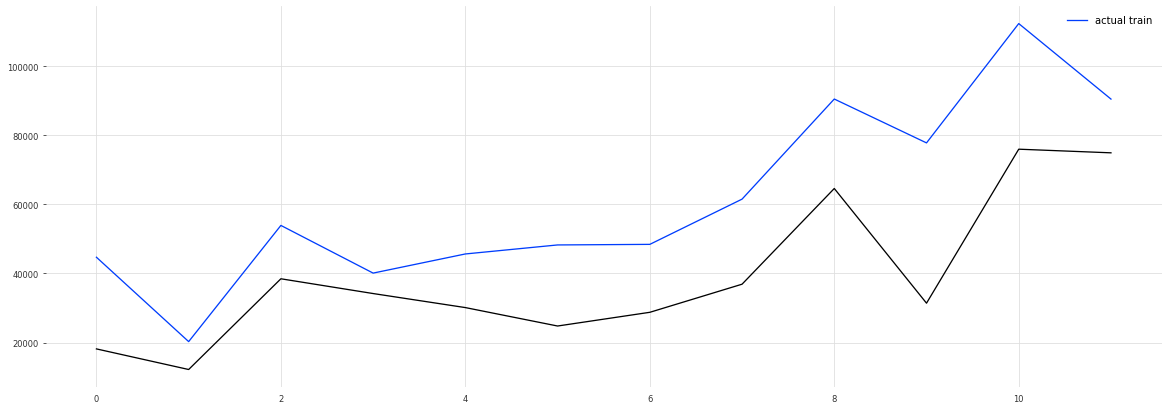

In [556]:
plt.plot(y_pred_lstm) 
plt.plot(data_test.to_numpy(),label="actual train")
plt.legend() 

In [557]:
mean_absolute_percentage_error(y_test, y_pred_lstm), r2_score(y_test , y_pred_lstm)

(0.369640842426902, 0.05359974508444154)

#### forecast on train

In [558]:
#last 12 month 
last_train_batch = data_train[:12]
last_train_batch = last_train_batch.to_numpy()
#get the generator shape (1,12,1)
current_batch = last_train_batch.reshape((1,n_input,n_features)) 
current_batch.shape

#y_pred 
y_pred_lstm_train =  []
for i in range(len(data_train)):
    #prediction 
    current_pred = model_lstm.predict(current_batch)[0]
    
    #save the prediction
    y_pred_lstm_train.append(current_pred)
    
    #take one step foreward (add the current pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [562]:
ml_data_train["y_pred_lstm_train"] = y_pred_lstm_train

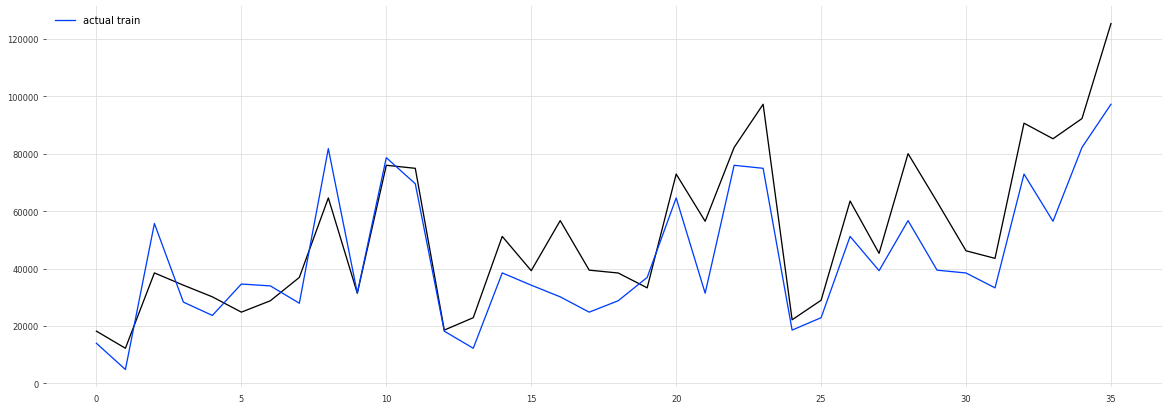

In [559]:
plt.plot(y_pred_lstm_train) 
plt.plot(data_train.to_numpy(),label="actual train")
plt.legend() 

In [594]:
mean_absolute_percentage_error(data_train["Sales"], y_pred_lstm_train), r2_score(data_train["Sales"] , y_pred_lstm_train)

(0.32897593375894935, 0.6286672559813002)

#### Evaluate lstm

In [595]:
#test
lstm_r2score_test = r2_score(y_test,ml_data_test["y_pred_lstm"])
lstm_mae_test = mean_absolute_error(ml_data_test["Sales"] , ml_data_test["y_pred_lstm"])
lstm_mape_test = mean_absolute_percentage_error(ml_data_test["Sales"] , ml_data_test["y_pred_lstm"])
lstm_rmse_test = mean_squared_error(ml_data_test["Sales"] , ml_data_test["y_pred_lstm"])

#train
lstm_r2score_train = r2_score(ml_data_train["Sales"],ml_data_train["y_pred_lstm_train"])
lstm_mae_train = mean_absolute_error(ml_data_train["Sales"],ml_data_train["y_pred_lstm_train"])
lstm_mape_train = mean_absolute_percentage_error(ml_data_train["Sales"],ml_data_train["y_pred_lstm_train"])
lstm_rmse_train = mean_squared_error(ml_data_train["Sales"],ml_data_train["y_pred_lstm_train"])


In [596]:
evaluation_lstm_model = {
    "Models":["lstm"],
    "R2_score_train":[lstm_r2score_train],
    "R2_score_test":[lstm_r2score_test],
    "MAE_train":[lstm_mae_train],
    "MAE_test":[lstm_mae_test],
    "RMSE_train":[lstm_rmse_train],
    "RMSE_test":[lstm_rmse_test],
    "MAPE_train":[lstm_mape_train],
    "MAPE_test":[lstm_mape_test],
}
evaluation_lstm_model = pd.DataFrame(evaluation_lstm_model).set_index("Models")
evaluation_lstm_model

R2_score_train  R2_score_test     MAE_train      MAE_test  \
Models                                                              
lstm          0.628667         0.0536  11488.084605  21950.868795   

          RMSE_train     RMSE_test  MAPE_train  MAPE_test  
Models                                                     
lstm    1.970034e+08  6.010164e+08    0.328976   0.369641

### LSTM on scaled data

#### Data scaling 


In [564]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [565]:
#create new_data
data_train_scaled = data_train.copy()
data_test_scaled = data_test.copy()


In [566]:
scaler.fit(data_train)

MinMaxScaler()

In [567]:
#standarize the data
data_train_scaled = scaler.transform(data_train_scaled)
data_test_scaled = scaler.transform(data_test_scaled)

#### Train lstm 

In [568]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [572]:
# define generator 
n_input = 12 
n_features = 1 
generator_scaled = TimeseriesGenerator(data_train_scaled,data_train_scaled, length=n_input,batch_size=1)
#we are using the last 12 month to predict the next month 

In [573]:
keras.utils.set_random_seed(812)


keras.utils.set_random_seed(812)

lstm_model_scaled = Sequential()
lstm_model_scaled.add(InputLayer((n_input,n_features)))
lstm_model_scaled.add(Bidirectional(LSTM(200,activation='relu',return_sequences=False, kernel_regularizer=l2(0.001),
                                         recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))))

lstm_model_scaled.add(Dense(100,activation='relu', kernel_regularizer=l2(0.001)))
lstm_model_scaled.add(Dense(4,activation='relu', kernel_regularizer=l2(0.001)))



lstm_model_scaled.add(Dense(1))
lstm_model_scaled.compile(loss="mean_squared_error",optimizer=Adam(0.001),metrics=["mape"])


In [574]:
ES_scaled = EarlyStopping(monitor='loss', verbose=1,
                      patience=100, restore_best_weights=True
)
reduce_lr_scaled = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=50, min_lr=0.000001)


In [575]:
lstm_model_scaled.fit(generator_scaled,epochs=1000,callbacks=[ES_scaled,reduce_lr_scaled])

Epoch 1/1000
24/24 [==============================] - 3s 16ms/step - loss: 0.8812 - mape: 78.6125 - lr: 0.0010
Epoch 2/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.6146 - mape: 60.6031 - lr: 0.0010
Epoch 3/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.5083 - mape: 70.7961 - lr: 0.0010
Epoch 4/1000
24/24 [==============================] - 0s 16ms/step - loss: 0.4646 - mape: 69.4467 - lr: 0.0010
Epoch 5/1000
24/24 [==============================] - 0s 17ms/step - loss: 0.4292 - mape: 61.5976 - lr: 0.0010
Epoch 6/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.3989 - mape: 67.0134 - lr: 0.0010
Epoch 7/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.3751 - mape: 70.4061 - lr: 0.0010
Epoch 8/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.3562 - mape: 64.3945 - lr: 0.0010
Epoch 9/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.3340 - mape: 56.5204 - lr: 0.0010
E

Epoch 147/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0230 - mape: 31.6156 - lr: 0.0010
Epoch 148/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0239 - mape: 36.3618 - lr: 0.0010
Epoch 149/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0222 - mape: 32.0025 - lr: 0.0010
Epoch 150/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0265 - mape: 37.3127 - lr: 0.0010
Epoch 151/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0218 - mape: 26.8876 - lr: 0.0010
Epoch 152/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0227 - mape: 34.0772 - lr: 0.0010
Epoch 153/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0231 - mape: 31.6323 - lr: 0.0010
Epoch 154/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0231 - mape: 31.2868 - lr: 0.0010
Epoch 155/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0206 - mape: 31.0

24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2345 - lr: 1.0000e-05
Epoch 288/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1989 - lr: 1.0000e-05
Epoch 289/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0196 - mape: 28.2366 - lr: 1.0000e-05
Epoch 290/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0196 - mape: 28.3405 - lr: 1.0000e-05
Epoch 291/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.3116 - lr: 1.0000e-05
Epoch 292/1000
24/24 [==============================] - 0s 16ms/step - loss: 0.0195 - mape: 28.3602 - lr: 1.0000e-05
Epoch 293/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.3762 - lr: 1.0000e-05
Epoch 294/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.3179 - lr: 1.0000e-05
Epoch 295/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.

24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2241 - lr: 1.0000e-06
Epoch 428/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.2260 - lr: 1.0000e-06
Epoch 429/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2517 - lr: 1.0000e-06
Epoch 430/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.2359 - lr: 1.0000e-06
Epoch 431/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2357 - lr: 1.0000e-06
Epoch 432/1000
24/24 [==============================] - 0s 16ms/step - loss: 0.0195 - mape: 28.2291 - lr: 1.0000e-06
Epoch 433/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2233 - lr: 1.0000e-06
Epoch 434/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.2258 - lr: 1.0000e-06
Epoch 435/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.

24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.2124 - lr: 1.0000e-06
Epoch 568/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2133 - lr: 1.0000e-06
Epoch 569/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2266 - lr: 1.0000e-06
Epoch 570/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.2068 - lr: 1.0000e-06
Epoch 571/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1980 - lr: 1.0000e-06
Epoch 572/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1977 - lr: 1.0000e-06
Epoch 573/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.2273 - lr: 1.0000e-06
Epoch 574/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.2150 - lr: 1.0000e-06
Epoch 575/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.

24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1909 - lr: 1.0000e-06
Epoch 708/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1953 - lr: 1.0000e-06
Epoch 709/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1956 - lr: 1.0000e-06
Epoch 710/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1898 - lr: 1.0000e-06
Epoch 711/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1802 - lr: 1.0000e-06
Epoch 712/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1879 - lr: 1.0000e-06
Epoch 713/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.2108 - lr: 1.0000e-06
Epoch 714/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1994 - lr: 1.0000e-06
Epoch 715/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.

24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1806 - lr: 1.0000e-06
Epoch 848/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1806 - lr: 1.0000e-06
Epoch 849/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1763 - lr: 1.0000e-06
Epoch 850/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1770 - lr: 1.0000e-06
Epoch 851/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1916 - lr: 1.0000e-06
Epoch 852/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1914 - lr: 1.0000e-06
Epoch 853/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1787 - lr: 1.0000e-06
Epoch 854/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1757 - lr: 1.0000e-06
Epoch 855/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.

24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1640 - lr: 1.0000e-06
Epoch 988/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1771 - lr: 1.0000e-06
Epoch 989/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1661 - lr: 1.0000e-06
Epoch 990/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1865 - lr: 1.0000e-06
Epoch 991/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1683 - lr: 1.0000e-06
Epoch 992/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.0195 - mape: 28.1541 - lr: 1.0000e-06
Epoch 993/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1682 - lr: 1.0000e-06
Epoch 994/1000
24/24 [==============================] - 0s 14ms/step - loss: 0.0195 - mape: 28.1632 - lr: 1.0000e-06
Epoch 995/1000
24/24 [==============================] - 0s 15ms/step - loss: 0.

#### forecast on test

In [579]:
#last 12 month 
last_train_batch = data_train_scaled[-12:]
#get the generator shape (1,12,1)
current_batch = last_train_batch.reshape((1,n_input,n_features)) 
current_batch.shape

#y_pred 
y_pred_scaled =  []
for i in range(len(data_test_scaled)):
    #prediction 
    current_pred = lstm_model_scaled.predict(current_batch)[0]
    
    #save the prediction
    y_pred_scaled.append(current_pred)
    
    #take one step foreward (add the current pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [597]:
y_pred_reversed = scaler.inverse_transform(y_pred_scaled)
y_test_reversed = scaler.inverse_transform(data_test_scaled)
ml_data_test["y_pred_lstm_scaled"] = y_pred_reversed 

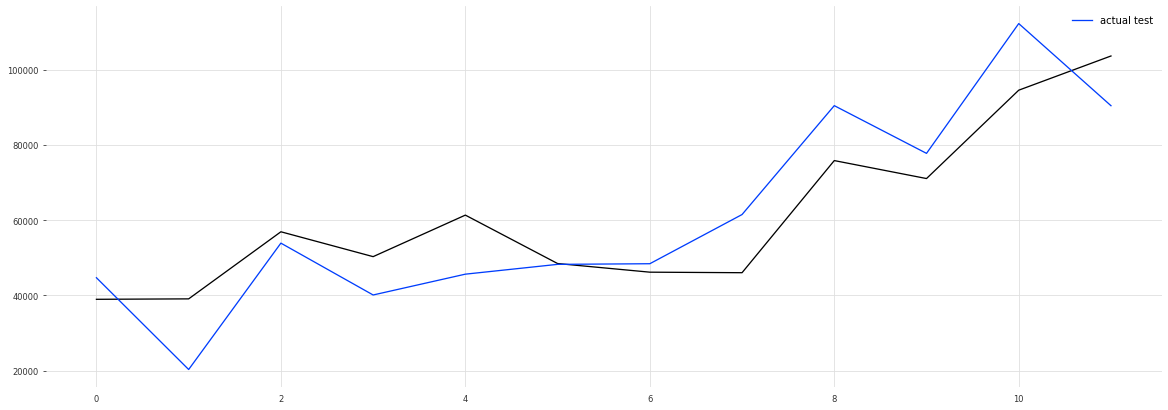

In [582]:

plt.plot(y_pred_reversed) 
plt.plot(y_test_reversed,label="actual test")
plt.legend() 

In [583]:
mean_absolute_percentage_error(y_test_reversed , y_pred_reversed), r2_score(y_test_reversed , y_pred_reversed)

(0.2136429849241549, 0.7718621109447332)

#### forecast on Train


In [584]:
#last 12 month 
last_train_batch = data_train_scaled[:12]
#get the generator shape (1,12,1)
current_batch = last_train_batch.reshape((1,n_input,n_features)) 
current_batch.shape

#y_pred 
y_pred_scaled_train =  []
#for i in range(len(data_train_scaled[12:])):
for i in range(len(data_train_scaled)):
    #prediction 
    current_pred = lstm_model_scaled.predict(current_batch)[0]
    
    #save the prediction
    y_pred_scaled_train.append(current_pred)
    
    #take one step foreward (add the current pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 31ms/step


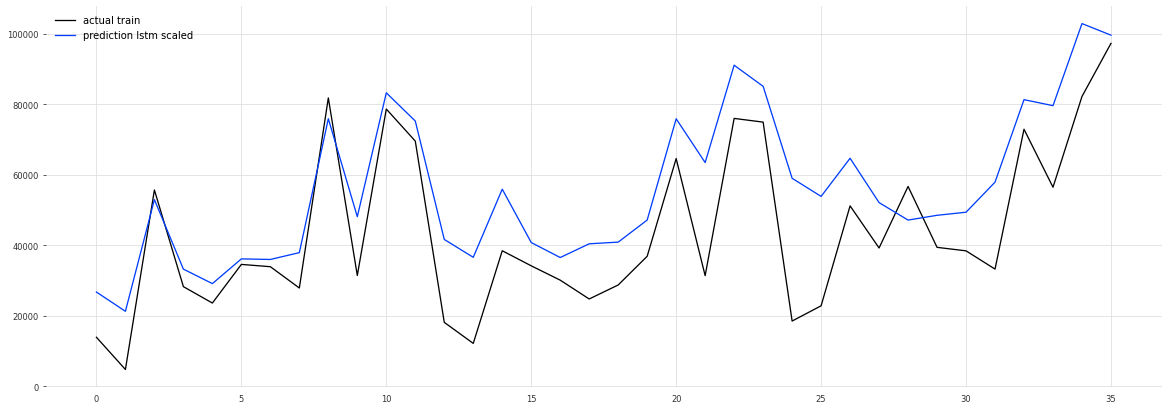

In [598]:
#pred
y_pred_train_reversed = scaler.inverse_transform(y_pred_scaled_train)
#y_train
y_train_reversed = scaler.inverse_transform(data_train_scaled)

ml_data_train["y_pred_scaled_lstm_train"] = y_pred_train_reversed 
plt.plot(y_train_reversed,label="actual train")
plt.plot(y_pred_reversed_train,label = "prediction lstm scaled")
plt.legend()

In [593]:
mean_absolute_percentage_error(y_train_reversed , y_pred_train_reversed), r2_score(y_train_reversed , y_pred_train_reversed)

(0.5382105769020075, 0.5092028271261082)

#### Evaluate lstm

In [600]:
#test
lstm_r2score_test_scaled = r2_score(y_test,ml_data_test["y_pred_lstm_scaled"])
lstm_mae_test_scaled = mean_absolute_error(ml_data_test["Sales"] , ml_data_test["y_pred_lstm_scaled"])
lstm_mape_test_scaled = mean_absolute_percentage_error(ml_data_test["Sales"] , ml_data_test["y_pred_lstm_scaled"])
lstm_rmse_test_scaled = mean_squared_error(ml_data_test["Sales"] , ml_data_test["y_pred_lstm_scaled"])

#train
lstm_r2score_train_scaled = r2_score(ml_data_train["Sales"],ml_data_train["y_pred_scaled_lstm_train"])
lstm_mae_train_scaled = mean_absolute_error(ml_data_train["Sales"],ml_data_train["y_pred_scaled_lstm_train"])
lstm_mape_train_scaled = mean_absolute_percentage_error(ml_data_train["Sales"],ml_data_train["y_pred_scaled_lstm_train"])
lstm_rmse_train_scaled = mean_squared_error(ml_data_train["Sales"],ml_data_train["y_pred_scaled_lstm_train"])


In [601]:
evaluation_lstm_model_scaled = {
    "Models":["lstm scaled"],
    "R2_score_train":[lstm_r2score_train_scaled],
    "R2_score_test":[lstm_r2score_test_scaled],
    "MAE_train":[lstm_mae_train_scaled],
    "MAE_test":[lstm_mae_test_scaled],
    "RMSE_train":[lstm_rmse_train_scaled],
    "RMSE_test":[lstm_rmse_test_scaled],
    "MAPE_train":[lstm_mape_train_scaled],
    "MAPE_test":[lstm_mape_test_scaled],
}
evaluation_lstm_model_scaled = pd.DataFrame(evaluation_lstm_model_scaled).set_index("Models")
evaluation_lstm_model_scaled

R2_score_train  R2_score_test     MAE_train     MAE_test  \
Models                                                                  
lstm scaled        0.509203       0.771862  13345.963589  10306.87348   

               RMSE_train     RMSE_test  MAPE_train  MAPE_test  
Models                                                          
lstm scaled  2.603830e+08  1.448802e+08    0.538211   0.213643

## Prophet

### prophet_data

In [181]:
train = Train()
vs = visualization()
sp = Samples()

In [182]:
prophet_data = general_data.reset_index()
prophet_data.columns = ["ds","y"]
prophet_data.head()

ds          y
0 2011-01-31  13946.229
1 2011-02-28   4810.558
2 2011-03-31  55691.009
3 2011-04-30  28295.345
4 2011-05-31  23648.287

In [183]:
data_train_prophet , data_test_prophet = train.split_data(prophet_data,0.75)

### train model

In [184]:
from prophet import Prophet
warnings.filterwarnings('ignore')


In [185]:
prophet_model = Prophet()
prophet_model.fit(data_train_prophet)

13:01:59 - cmdstanpy - INFO - Chain [1] start processing
13:01:59 - cmdstanpy - INFO - Chain [1] done processing


### explore performance 

In [186]:
y_pred_prophet_test = prophet_model.predict(data_test_prophet)
y_pred_prophet_train = prophet_model.predict(data_train_prophet) 

In [187]:
y_pred_prophet_test

ds         trend    yhat_lower     yhat_upper   trend_lower  \
0  2014-01-31  52503.431802  21900.307786   34548.042852  52491.911921   
1  2014-02-28  53089.209144  17680.527003   30395.651108  53054.769260   
2  2014-03-31  53737.748345  59306.595647   71264.207118  53673.110468   
3  2014-04-30  54365.366926  39155.104054   51630.813998  54265.032318   
4  2014-05-31  55013.906127  41247.773643   54015.233183  54868.766714   
5  2014-06-30  55641.524708  41266.407070   54163.561453  55448.983794   
6  2014-07-31  56290.063909  40927.715135   53959.851374  56044.063847   
7  2014-08-31  56938.603110  38076.701920   50136.468206  56637.753984   
8  2014-09-30  57566.221691  84047.370505   96267.050079  57214.256214   
9  2014-10-31  58214.760892  46320.481910   59058.996287  57802.382415   
10 2014-11-30  58842.379473  87836.767853  100504.198479  58357.156612   
11 2014-12-31  59490.918674  87096.080439   99816.163295  58934.674052   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   52511.797284   -24108.199333         -24108.199333         -24108.199333   
1   53116.337255   -29110.609582         -29110.609582         -29110.609582   
2   53789.725206    11487.422760          11487.422760          11487.422760   
3   54453.172713    -8661.713539          -8661.713539          -8661.713539   
4   55141.530618    -7754.571834          -7754.571834          -7754.571834   
5   55818.425312    -7980.308292          -7980.308292          -7980.308292   
6   56510.680466    -8610.095196          -8610.095196          -8610.095196   
7   57213.284257   -13024.994277         -13024.994277         -13024.994277   
8   57894.788979    32734.986408          32734.986408          32734.986408   
9   58607.839507    -5632.071311          -5632.071311          -5632.071311   
10  59308.784866    34932.047982          34932.047982          34932.047982   
11  60020.974597    33835.652315          33835.652315          33835.652315   

          yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -24108.199333 -24108.199333 -24108.199333                   0.0   
1  -29110.609582 -29110.609582 -29110.609582                   0.0   
2   11487.422760  11487.422760  11487.422760                   0.0   
3   -8661.713539  -8661.713539  -8661.713539                   0.0   
4   -7754.571834  -7754.571834  -7754.571834                   0.0   
5   -7980.308292  -7980.308292  -7980.308292                   0.0   
6   -8610.095196  -8610.095196  -8610.095196                   0.0   
7  -13024.994277 -13024.994277 -13024.994277                   0.0   
8   32734.986408  32734.986408  32734.986408                   0.0   
9   -5632.071311  -5632.071311  -5632.071311                   0.0   
10  34932.047982  34932.047982  34932.047982                   0.0   
11  33835.652315  33835.652315  33835.652315                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                          0.0                         0.0  28395.232468  
1                          0.0                         0.0  23978.599562  
2                          0.0                         0.0  65225.171105  
3                          0.0                         0.0  45703.653387  
4                          0.0                         0.0  47259.334293  
5                          0.0                         0.0  47661.216416  
6                          0.0                         0.0  47679.968713  
7                          0.0                         0.0  43913.608833  
8                          0.0                         0.0  90301.208099  
9                          0.0                         0.0  52582.689580  
10                         0.0                         0.0  93774.427455  
11                         0.0                         0.0  93326.570989

#### forecast on testset 

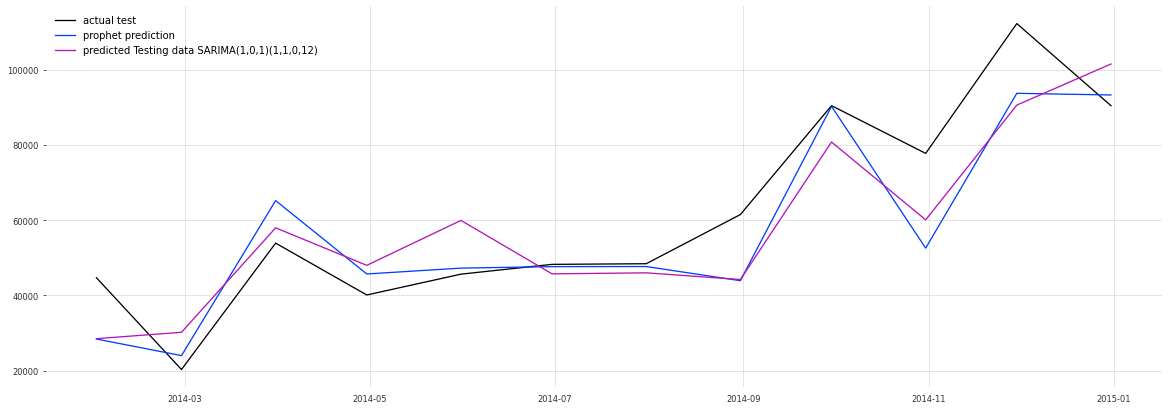

In [188]:
plt.plot(data_test_prophet.set_index("ds")['y'],label = "actual test")
plt.plot(y_pred_prophet_test.set_index("ds")['yhat'],label = "prophet prediction")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend() 

#### forecast on trainset 

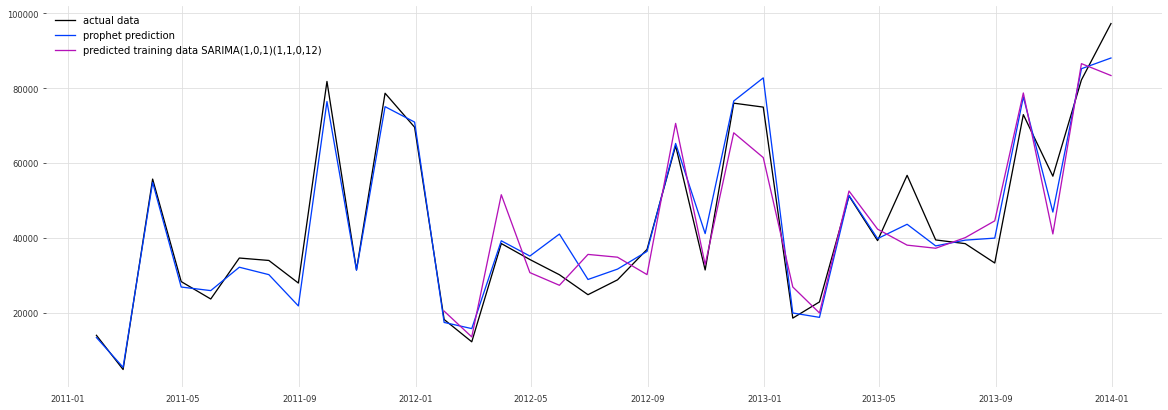

In [189]:
plt.plot(data_train_prophet.set_index("ds")['y'],label = "actual data")
plt.plot(y_pred_prophet_train.set_index("ds")['yhat'],label = "prophet prediction")
plt.plot(results_sarima["Y_prediction_train"][9],label="predicted training data SARIMA(1,0,1)(1,1,0,12)")

plt.legend() 

In [190]:
pd.concat([results_sarima["Y_prediction_train"][9],results_sarima["Y_prediction_train"][9]],axis=0).shape[0]

48

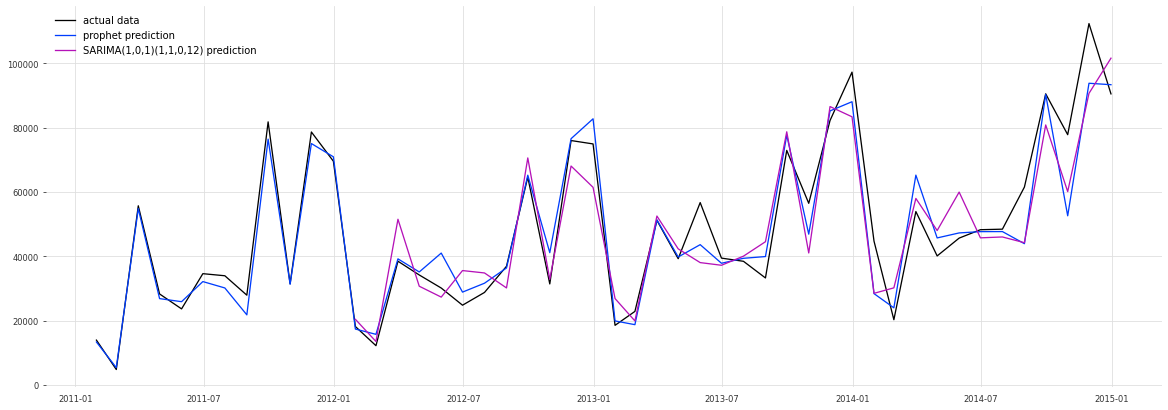

In [191]:
full_data = general_data["Sales"]
full_pred_data_prophet = pd.concat([y_pred_prophet_train,y_pred_prophet_test],axis=0).set_index("ds")['yhat']
full_pred_data_sarima = pd.concat([results_sarima["Y_prediction_train"][9],results_sarima["Y_prediction"][9]],axis=0)

plt.plot(full_data,label = "actual data")
plt.plot(full_pred_data_prophet,label = "prophet prediction")
plt.plot(full_pred_data_sarima,label="SARIMA(1,0,1)(1,1,0,12) prediction")

plt.legend()

### Evaluate prophet

In [192]:
#test
prophet_r2score_test = r2_score(data_test_prophet.set_index("ds")['y'],y_pred_prophet_test.set_index("ds")['yhat'])
prophet_mae_test = mean_absolute_error(data_test_prophet.set_index("ds")['y'] , y_pred_prophet_test.set_index("ds")['yhat'])
prophet_mape_test = mean_absolute_percentage_error(data_test_prophet.set_index("ds")['y'] , y_pred_prophet_test.set_index("ds")['yhat'])
prophet_rmse_test = mean_squared_error(data_test_prophet.set_index("ds")['y'] , y_pred_prophet_test.set_index("ds")['yhat'],squared=False)

#train
prophet_r2score_train = r2_score(data_train_prophet.set_index("ds")['y'], y_pred_prophet_train.set_index("ds")['yhat'])
prophet_mae_train = mean_absolute_error(data_train_prophet.set_index("ds")['y'], y_pred_prophet_train.set_index("ds")['yhat'])
prophet_mape_train = mean_absolute_percentage_error(data_train_prophet.set_index("ds")['y'], y_pred_prophet_train.set_index("ds")['yhat'])
prophet_rmse_train = mean_squared_error(data_train_prophet.set_index("ds")['y'], y_pred_prophet_train.set_index("ds")['yhat'],squared=False)


In [193]:
evaluation_prophet_model = {
    "Models":["Prophet"],
    "R2_score_train":[prophet_r2score_train],
    "R2_score_test":[prophet_r2score_test],
    "MAE_train":[prophet_mae_train],
    "MAE_test":[prophet_mae_test],
    "RMSE_train":[prophet_rmse_train],
    "RMSE_test":[prophet_rmse_test],
    "MAPE_train":[prophet_mape_train],
    "MAPE_test":[prophet_mape_test],
}
evaluation_prophet_model = pd.DataFrame(evaluation_prophet_model).set_index("Models")
evaluation_prophet_model

R2_score_train  R2_score_test    MAE_train     MAE_test   RMSE_train  \
Models                                                                          
Prophet        0.954472       0.771645  3514.996649  8689.211198  4914.649843   

            RMSE_test  MAPE_train  MAPE_test  
Models                                        
Prophet  12042.344072     0.09562   0.147361

In [194]:
pd.concat([evaluation_prophet_model,evaluation_SARIMA],axis=0) 

R2_score_train  R2_score_test    MAE_train  \
Models                                                                 
Prophet                         0.954472       0.771645  3514.996649   
SARIMA(11,0,1)(1,1,0,12)        0.892036       0.716059  6100.436514   
SARIMA(1,0,1)(1,1,0,12)         0.855312       0.743349  6837.146239   

                              MAE_test   RMSE_train     RMSE_test  MAPE_train  \
Models                                                                          
Prophet                    8689.211198  4914.649843  12042.344072    0.095620   
SARIMA(11,0,1)(1,1,0,12)  11702.058017  7337.374139  13428.253990    0.161604   
SARIMA(1,0,1)(1,1,0,12)   11230.945070  8494.098190  12766.648308    0.167065   

                          MAPE_test  
Models                               
Prophet                    0.147361  
SARIMA(11,0,1)(1,1,0,12)   0.218682  
SARIMA(1,0,1)(1,1,0,12)    0.205828

## Neural Prophet

In [195]:
#!pip install captum

from neuralprophet import NeuralProphet

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


### train model

In [196]:
neuralprophet_model = NeuralProphet()
neuralprophet_model.fit(data_train_prophet,freq='M',epochs=300)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [97.222]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8


Training: |                                                                                      | 0/? [00:00<…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (5) is too small than the required number                     for the learning rate finder (203). The results might not be optimal.


Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: |                                                                                      | 0/? [00:00<…

train_loss  reg_loss           MAE          RMSE      Loss  RegLoss  \
0      0.576601       0.0  66055.007812  78161.195312  0.568585      0.0   
1      0.546444       0.0  65255.726562  76609.328125  0.558355      0.0   
2      0.522759       0.0  61907.750000  73915.914062  0.524516      0.0   
3      0.498709       0.0  57918.320312  68703.906250  0.474571      0.0   
4      0.472351       0.0  57100.070312  67472.382812  0.469975      0.0   
..          ...       ...           ...           ...       ...      ...   
295    0.005884       0.0   4735.492188   5506.465820  0.006817      0.0   
296    0.005883       0.0   4212.630859   5122.612793  0.005747      0.0   
297    0.005882       0.0   4343.882324   5290.363770  0.006061      0.0   
298    0.005888       0.0   4226.879883   5246.337891  0.005761      0.0   
299    0.005890       0.0   4303.228027   5340.196777  0.005991      0.0   

     epoch  
0        0  
1        1  
2        2  
3        3  
4        4  
..     ...  
295    295  
296    296  
297    297  
298    298  
299    299  

[300 rows x 7 columns]

In [197]:
y_pred_neuralprophet_test = neuralprophet_model.predict(data_test_prophet)
y_pred_neuralprophet_train = neuralprophet_model.predict(data_train_prophet) 

INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [97.222]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to [97.222]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M


Predicting: |                                                                                    | 0/? [00:00<…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


#### forecast on testset 

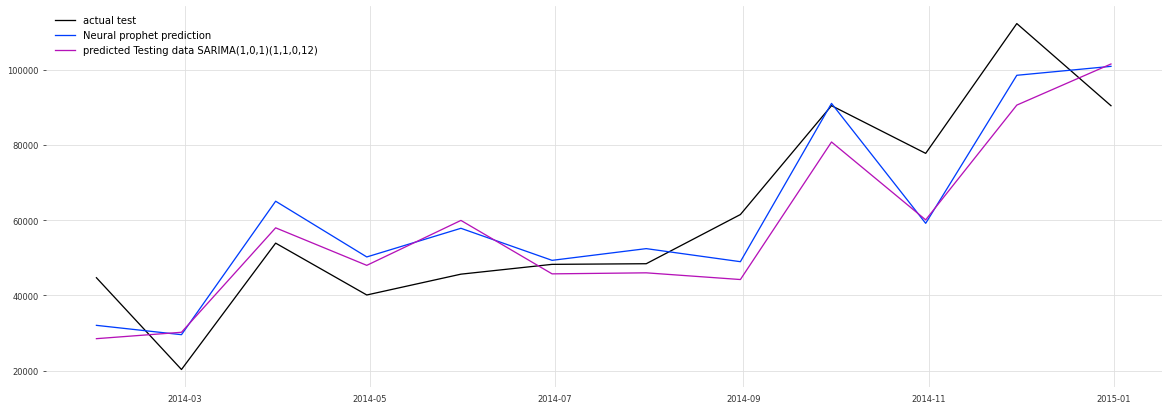

In [198]:
plt.plot(data_test_prophet.set_index("ds")['y'],label = "actual test")
plt.plot(y_pred_neuralprophet_test.set_index("ds")['yhat1'],label = "Neural prophet prediction")
plt.plot(results_sarima["Y_prediction"][9],label="predicted Testing data SARIMA(1,0,1)(1,1,0,12)")

plt.legend() 

#### forecast on trainset 

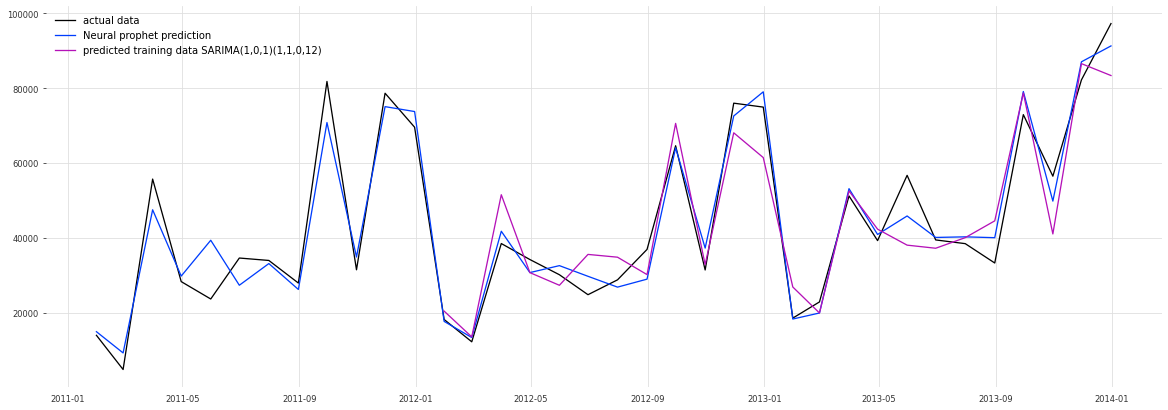

In [199]:
plt.plot(data_train_prophet.set_index("ds")['y'],label = "actual data")
plt.plot(y_pred_neuralprophet_train.set_index("ds")['yhat1'],label = "Neural prophet prediction")
plt.plot(results_sarima["Y_prediction_train"][9],label="predicted training data SARIMA(1,0,1)(1,1,0,12)")

plt.legend() 

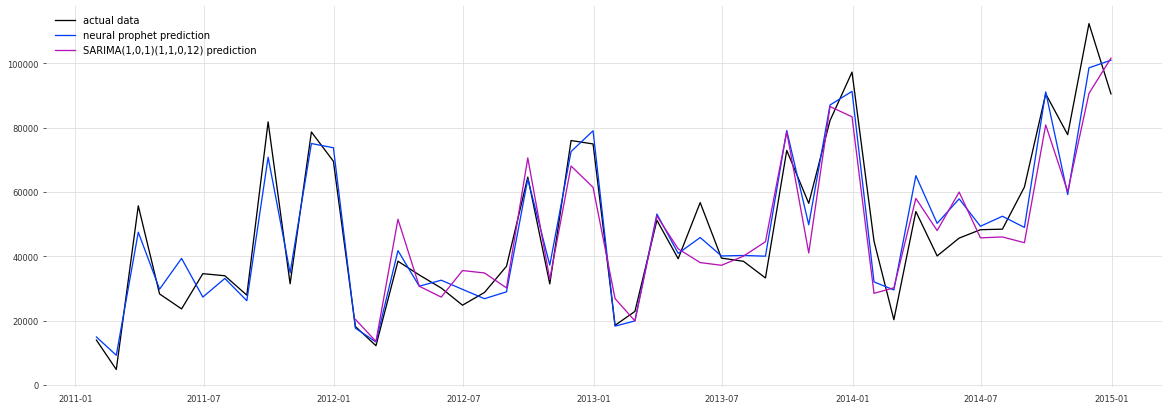

In [200]:
full_data = general_data["Sales"]
full_pred_data_neuralprophet = pd.concat([y_pred_neuralprophet_train,y_pred_neuralprophet_test],axis=0).set_index("ds")['yhat1']
full_pred_data_sarima = pd.concat([results_sarima["Y_prediction_train"][9],results_sarima["Y_prediction"][9]],axis=0)

plt.plot(full_data,label = "actual data")
plt.plot(full_pred_data_neuralprophet,label = "neural prophet prediction")
plt.plot(full_pred_data_sarima,label="SARIMA(1,0,1)(1,1,0,12) prediction")

plt.legend()

### Evaluate Neural Prophet

In [201]:
#test
neuralprophet_r2score_test = r2_score(data_test_prophet.set_index("ds")['y'],y_pred_neuralprophet_test.set_index("ds")['yhat1'])
neuralprophet_mae_test = mean_absolute_error(data_test_prophet.set_index("ds")['y'] , y_pred_neuralprophet_test.set_index("ds")['yhat1'])
neuralprophet_mape_test = mean_absolute_percentage_error(data_test_prophet.set_index("ds")['y'] , y_pred_neuralprophet_test.set_index("ds")['yhat1'])
neuralprophet_rmse_test = mean_squared_error(data_test_prophet.set_index("ds")['y'] , y_pred_neuralprophet_test.set_index("ds")['yhat1'],squared=False)

#train
neuralprophet_r2score_train = r2_score(data_train_prophet.set_index("ds")['y'], y_pred_neuralprophet_train.set_index("ds")['yhat1'])
neuralprophet_mae_train = mean_absolute_error(data_train_prophet.set_index("ds")['y'], y_pred_neuralprophet_train.set_index("ds")['yhat1'])
neuralprophet_mape_train = mean_absolute_percentage_error(data_train_prophet.set_index("ds")['y'], y_pred_neuralprophet_train.set_index("ds")['yhat1'])
neuralprophet_rmse_train = mean_squared_error(data_train_prophet.set_index("ds")['y'], y_pred_neuralprophet_train.set_index("ds")['yhat1'],squared=False)


In [202]:
evaluation_neuralprophet_model = {
    "Models":["Neural Prophet"],
    "R2_score_train":[neuralprophet_r2score_train],
    "R2_score_test":[neuralprophet_r2score_test],
    "MAE_train":[neuralprophet_mae_train],
    "MAE_test":[neuralprophet_mae_test],
    "RMSE_train":[neuralprophet_rmse_train],
    "RMSE_test":[neuralprophet_rmse_test],
    "MAPE_train":[neuralprophet_mape_train],
    "MAPE_test":[neuralprophet_mape_test],
}
evaluation_neuralprophet_model = pd.DataFrame(evaluation_neuralprophet_model).set_index("Models")
evaluation_neuralprophet_model

R2_score_train  R2_score_test    MAE_train     MAE_test  \
Models                                                                    
Neural Prophet        0.944283       0.810693  4245.915709  9707.271683   

                 RMSE_train     RMSE_test  MAPE_train  MAPE_test  
Models                                                            
Neural Prophet  5436.871599  10964.514707    0.129653   0.188317

In [203]:
pd.concat([evaluation_prophet_model,evaluation_neuralprophet_model,evaluation_SARIMA],axis=0) 

R2_score_train  R2_score_test    MAE_train  \
Models                                                                 
Prophet                         0.954472       0.771645  3514.996649   
Neural Prophet                  0.944283       0.810693  4245.915709   
SARIMA(11,0,1)(1,1,0,12)        0.892036       0.716059  6100.436514   
SARIMA(1,0,1)(1,1,0,12)         0.855312       0.743349  6837.146239   

                              MAE_test   RMSE_train     RMSE_test  MAPE_train  \
Models                                                                          
Prophet                    8689.211198  4914.649843  12042.344072    0.095620   
Neural Prophet             9707.271683  5436.871599  10964.514707    0.129653   
SARIMA(11,0,1)(1,1,0,12)  11702.058017  7337.374139  13428.253990    0.161604   
SARIMA(1,0,1)(1,1,0,12)   11230.945070  8494.098190  12766.648308    0.167065   

                          MAPE_test  
Models                               
Prophet                    0.147361  
Neural Prophet             0.188317  
SARIMA(11,0,1)(1,1,0,12)   0.218682  
SARIMA(1,0,1)(1,1,0,12)    0.205828

# Using Percentage change (Normalization of Data)

## Transform the data

In [204]:
general_data.head()

Sales
2011-01-31  13946.229
2011-02-28   4810.558
2011-03-31  55691.009
2011-04-30  28295.345
2011-05-31  23648.287

In [205]:
general_data["Sales_pct_change"] = general_data["Sales"].pct_change()

In [206]:
general_data.head()

Sales  Sales_pct_change
2011-01-31  13946.229               NaN
2011-02-28   4810.558         -0.655064
2011-03-31  55691.009         10.576829
2011-04-30  28295.345         -0.491923
2011-05-31  23648.287         -0.164234

In [207]:
general_data2 = general_data[1:]

## Explore the data 

### Sales over time (months)

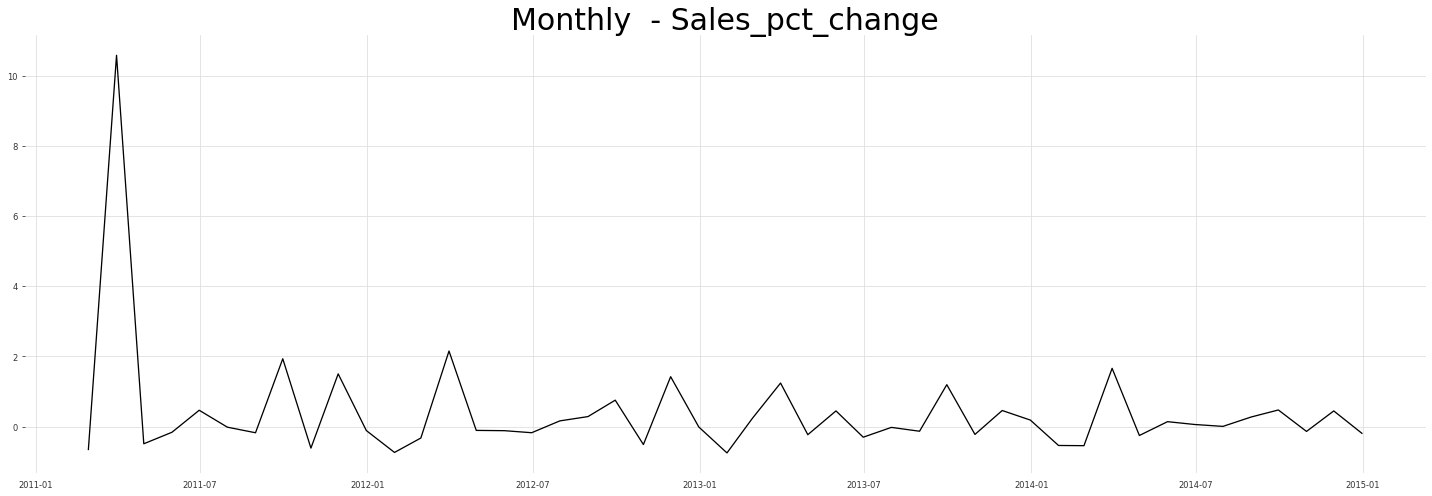

In [208]:
vs.lineplot(general_data.drop("Sales",axis=1),"Monthly")

### Identify outliers  

In [209]:
Q1 = general_data['Sales_pct_change'].quantile(0.25)
Q3 = general_data['Sales_pct_change'].quantile(0.75)
IQR = Q3 - Q1
print("IQR =",IQR)   

IQR = 0.6794344230190767


In [210]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
general_data['is_outlier'] = (general_data['Sales_pct_change'] < lower_bound) | (general_data['Sales_pct_change'] > upper_bound)


In [211]:
general_data.head()

Sales  Sales_pct_change  is_outlier
2011-01-31  13946.229               NaN       False
2011-02-28   4810.558         -0.655064       False
2011-03-31  55691.009         10.576829        True
2011-04-30  28295.345         -0.491923       False
2011-05-31  23648.287         -0.164234       False

In [212]:
general_data.is_outlier.value_counts()

is_outlier
False    43
True      5
Name: count, dtype: int64

So, we observe that there are 5 outliers . let's plot them to better understand if they are really outliers 

In [213]:
list_outliers = []
list_idx_outliers = []
for i,x in enumerate(general_data.is_outlier):
    if x :
        list_outliers.append(general_data["Sales_pct_change"][i])
        list_idx_outliers.append(general_data["Sales_pct_change"].index[i])
list_outliers = pd.Series(list_outliers)
list_outliers.index = list_idx_outliers
list_outliers

2011-03-31    10.576829
2011-09-30     1.930093
2011-11-30     1.499848
2012-03-31     2.150210
2014-03-31     1.657772
dtype: float64

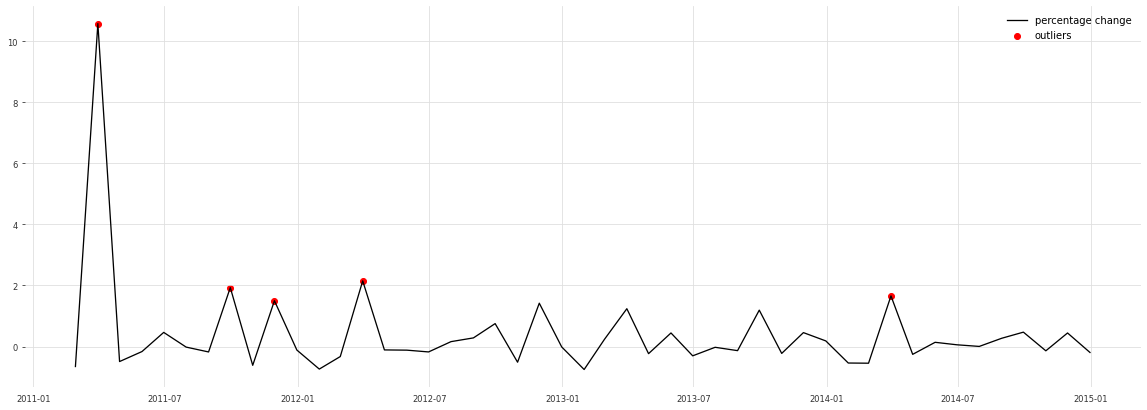

In [214]:
#Visualisation 
plt.plot(general_data["Sales_pct_change"],label="percentage change")
plt.scatter(list_outliers.index,list_outliers,label="outliers",color="r")
plt.legend()

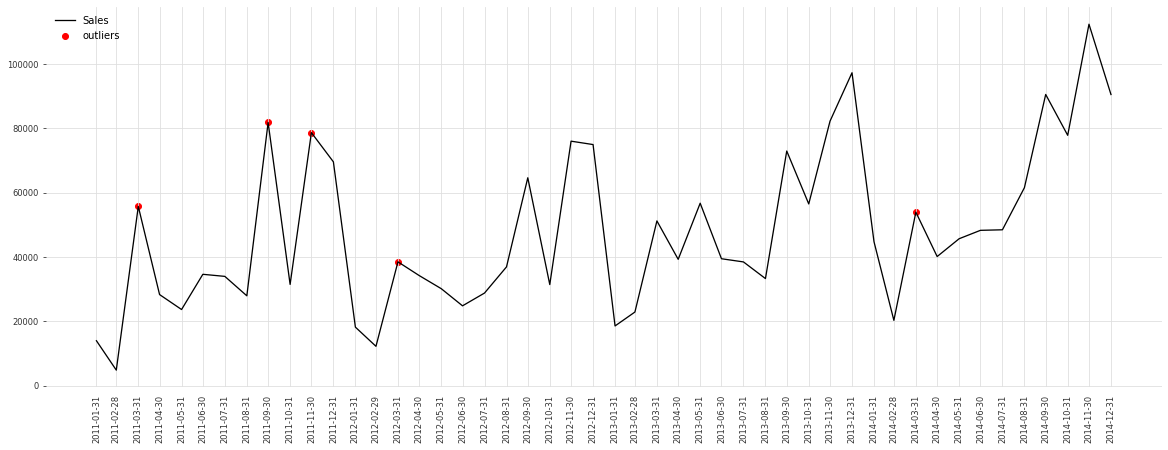

In [215]:
#visuliaze outliers in the real data 
outliers = [x for i,x in enumerate(general_data["Sales"]) if general_data["Sales"].index[i]  in list_outliers.index ]
outliers
#Visualisation 
plt.plot(general_data["Sales"],label="Sales")
plt.scatter(list_outliers.index,outliers,label="outliers",color="r")
plt.xticks(ticks=general_data.index,label=[general_data.index],rotation=90)
plt.legend()

=> the picks seem logical and seasonal. I won't consider them outliers.

### Examin the sationarity

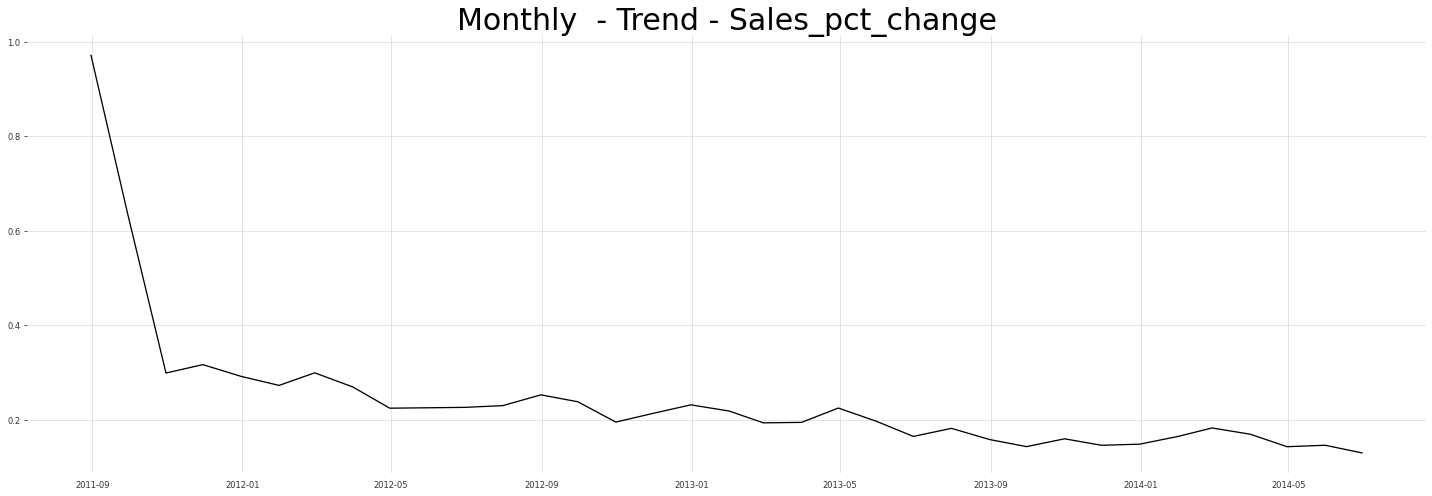

In [216]:
vs.trend_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:],"Monthly")

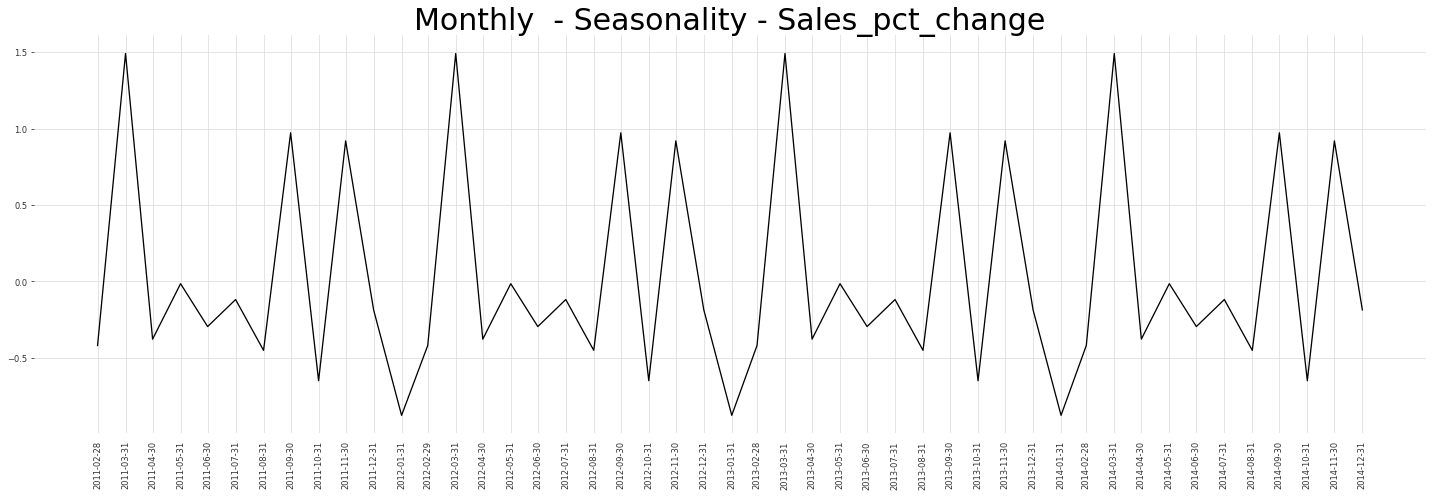

In [217]:
vs.seasonality_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:],"Monthly")

### Calculate the ACF & PACF plots on the stationary data


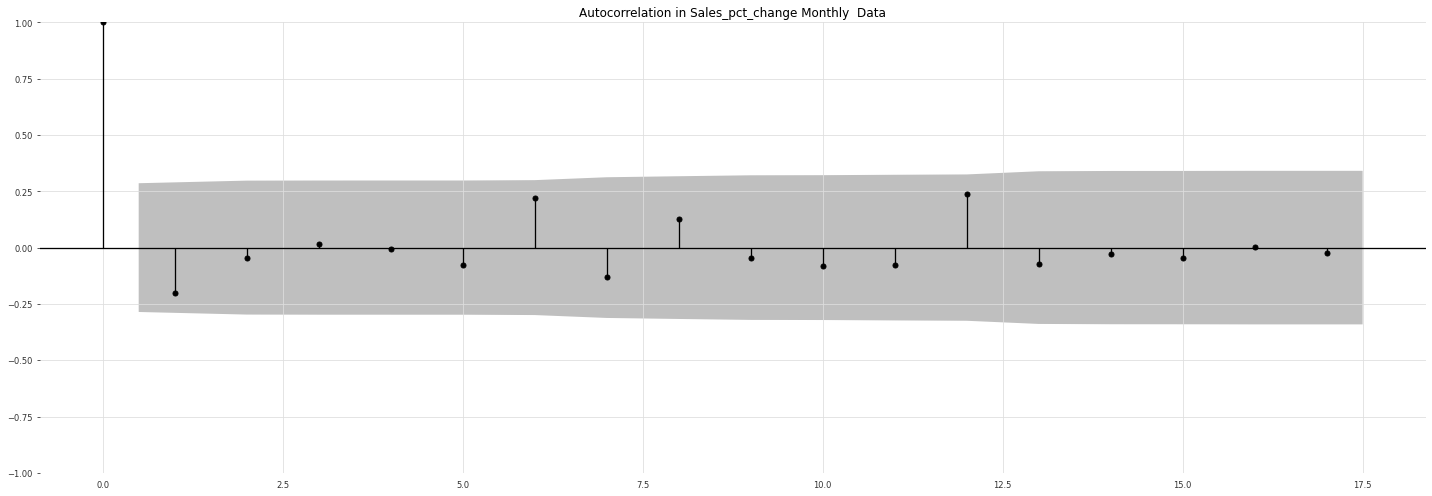

In [218]:
vs.acf_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:],"Monthly")

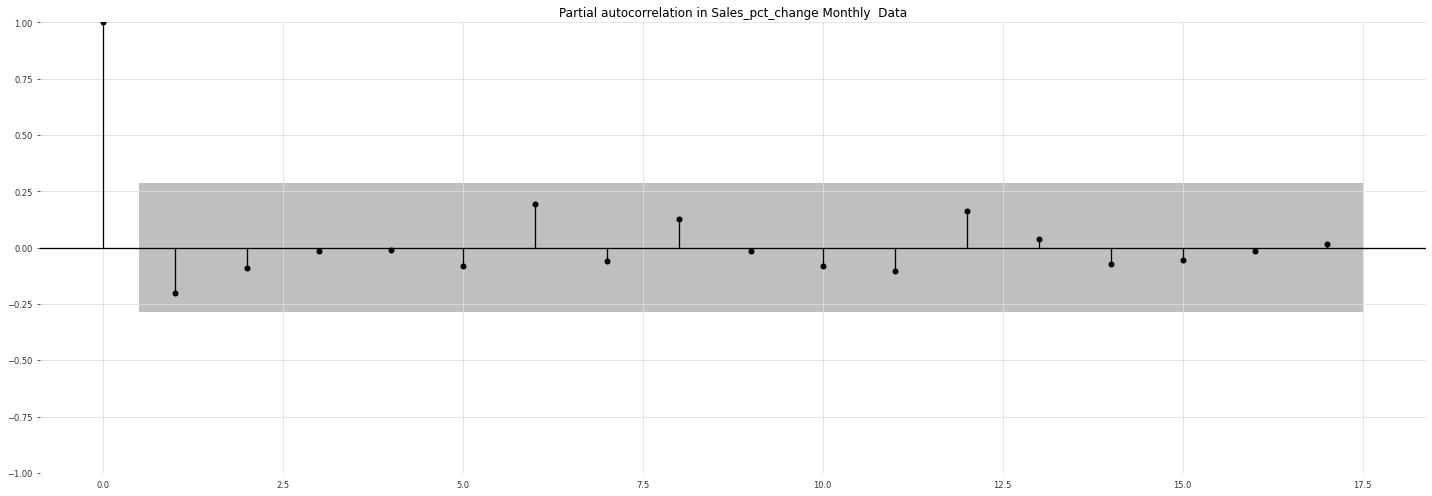

In [219]:
vs.pacf_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:],"Monthly")

In [220]:
#after diffrenciating (trend and seasonality )

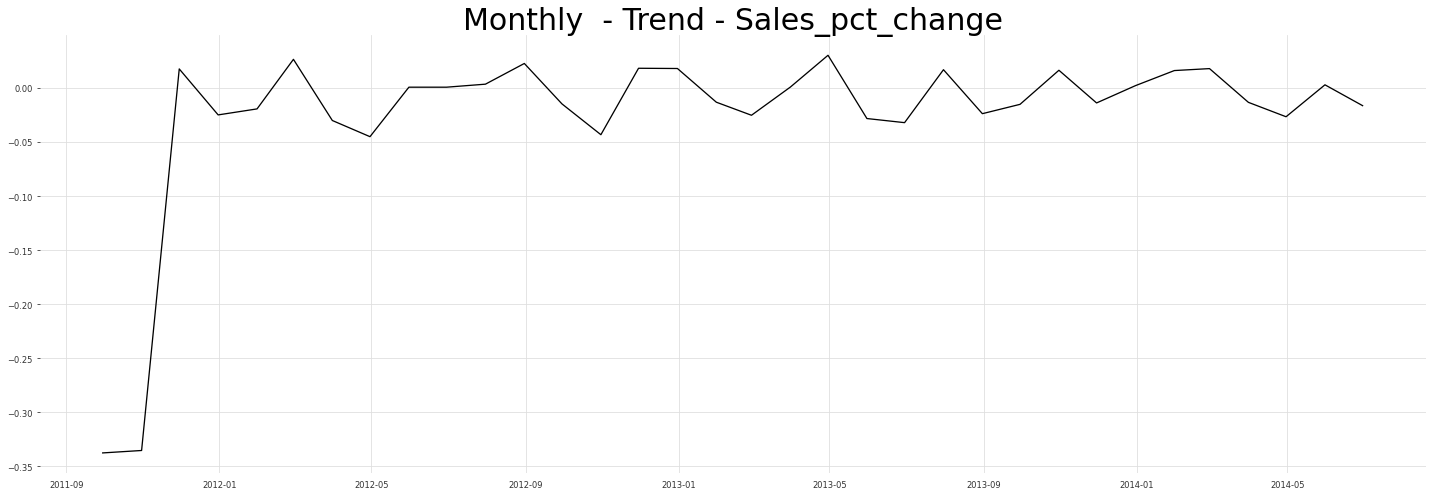

In [221]:
vs.trend_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:].diff().dropna(),"Monthly")

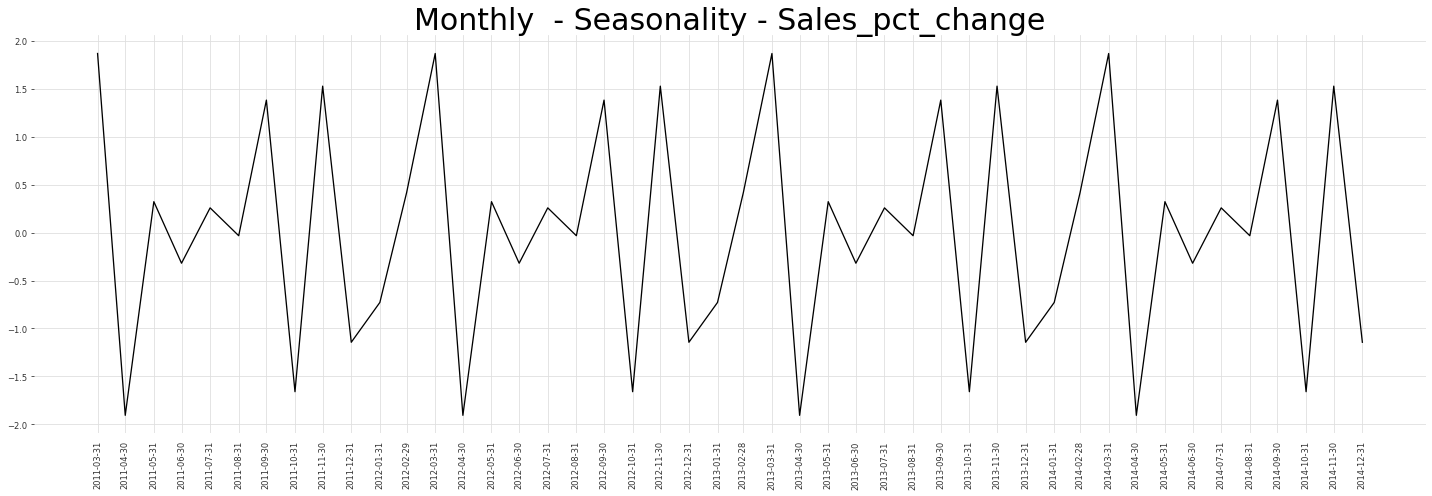

In [222]:
vs.seasonality_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:].diff().dropna(),"Monthly")

=> seasnality : mars -> mars  => S = 12

#### ADF test (Augmented Dickey-Fuller test)

In [223]:
data_train_pct , data_test_pct = train.split_data(general_data,0.75)

In [224]:
result_pct_change = train.adf_test(general_data["Sales_pct_change"][1:])
result_pct_change

Statistical test  P-values  Lags used  Number of observations
0         -1.731106  0.415161         10                      36

H0: data is not stationnary                         
H1: data is stationnary                             
p value > 0.05 => fail to reject H0 => so based on ADF test data is not stationnary                      
we'll differenciate the data and check acf and pacf plot again 

##### differenciate the data  perform the ADF test again 

In [225]:
result_pct_change_diff = train.adf_test(general_data["Sales_pct_change"][1:].diff().dropna())
result_pct_change_diff

Statistical test  P-values  Lags used  Number of observations
0         -4.987877  0.000023          9                      36

=> p-value < 0.05 => the date is stationnary (d=1)

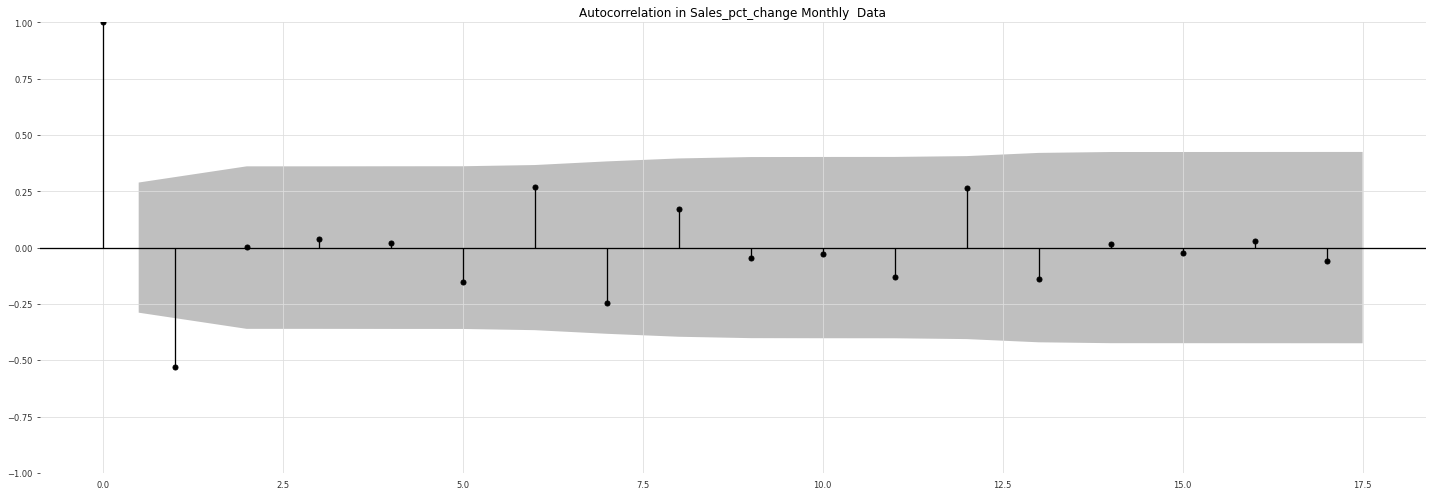

In [226]:
vs.acf_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:].diff().dropna(),"Monthly")

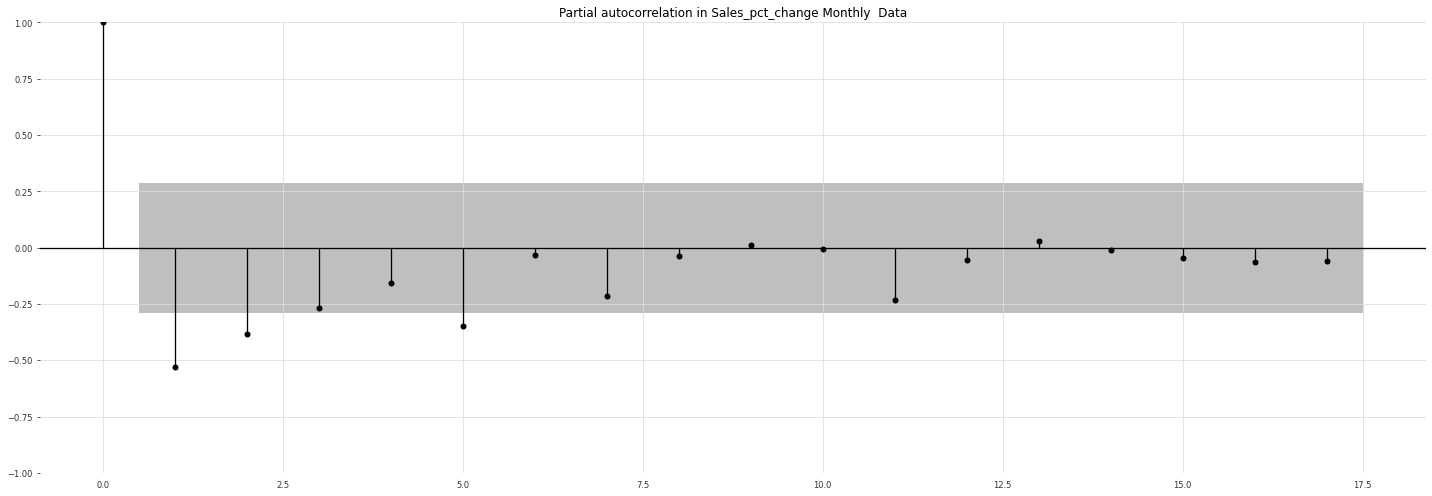

In [227]:
vs.pacf_plot(general_data.drop(["Sales","is_outlier"],axis=1)[1:].diff().dropna(),"Monthly")

In [228]:
"""pacf_segment , _ = pacf(general_data.drop(["Sales","is_outlier"],axis=1)[1:].diff().dropna(),alpha=0.05)
print("before")
print(pacf_segment)
pacf_segment = [lag for lag,value in enumerate(pacf_segment) if abs(value)> 0.25]
pacf_segment"""

'pacf_segment , _ = pacf(general_data.drop(["Sales","is_outlier"],axis=1)[1:].diff().dropna(),alpha=0.05)\nprint("before")\nprint(pacf_segment)\npacf_segment = [lag for lag,value in enumerate(pacf_segment) if abs(value)> 0.25]\npacf_segment'

## ARIMA

In [229]:
models_arima_pct = train.train_arima(general_data.drop(["Sales","is_outlier"],axis=1)[1:],0.75)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

ADF Statistic: -1.7311063266224096
p-value: 0.4151609992562723
acf [0, 1, 6, 12]
pacf [0, 1, 2, 3, 5, 7, 11, 12, 13, 14, 15, 16]
(ar,d,ma) : (0, 1, 0)
(ar,d,ma) : (0, 1, 1)
(ar,d,ma) : (0, 1, 6)
(ar,d,ma) : (0, 1, 12)
(ar,d,ma) : (1, 1, 0)
(ar,d,ma) : (1, 1, 1)
(ar,d,ma) : (1, 1, 6)
(ar,d,ma) : (1, 1, 12)
(ar,d,ma) : (2, 1, 0)
(ar,d,ma) : (2, 1, 1)
(ar,d,ma) : (2, 1, 6)
(ar,d,ma) : (2, 1, 12)
(ar,d,ma) : (3, 1, 0)
(ar,d,ma) : (3, 1, 1)
(ar,d,ma) : (3, 1, 6)
(ar,d,ma) : (3, 1, 12)
(ar,d,ma) : (5, 1, 0)
(ar,d,ma) : (5, 1, 1)
(ar,d,ma) : (5, 1, 6)
(ar,d,ma) : (5, 1, 12)
(ar,d,ma) : (7, 1, 0)
(ar,d,ma) : (7, 1, 1)
(ar,d,ma) : (7, 1, 6)
(ar,d,ma) : (7, 1, 12)
(ar,d,ma) : (11, 1, 0)
(ar,d,ma) : (11, 1, 1)
(ar,d,ma) : (11, 1, 6)
(ar,d,ma) : (11, 1, 12)
(ar,d,ma) : (12, 1, 0)
(ar,d,ma) : (12, 1, 1)
(ar,d,ma) : (12, 1, 6)
(ar,d,ma) : (12, 1, 12)
(ar,d,ma) : (13, 1, 0)
(ar,d,ma) : (13, 1, 1)
(ar,d,ma) : (13, 1, 6)
(ar,d,ma) : (13, 1, 12)
(ar,d,ma) : (14, 1, 0)
(ar,d,ma) : (14, 1, 1)
(ar,d,ma) : 



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:41<00:00, 101.63s/it]


In [230]:
max_r2score_train_pct = max(models_arima_pct["R2_Score_train"])
max_r2score_test_pct = max(models_arima_pct["R2_Score"])
min_mape_train_pct =min(models_arima_pct["MAPE_train"])
min_mape_test_pct = min(models_arima_pct["MAPE"])
print(f"the hightest R2_score (on train data , to test how much the model fits the training data ): {max_r2score_train_pct}")
print(f"the hightest R2_score on test data : {max_r2score_test_pct}")
print()
print(f"the lowest mean absolute percentage error on trainset: {min_mape_train_pct}")
print(f"the lowest mean absolute percentage error on test set: {min_mape_test_pct}")


the hightest R2_score (on train data , to test how much the model fits the training data ): -1.2765190841612815
the hightest R2_score on test data : 0.6851646812647361

the lowest mean absolute percentage error on trainset: 1.2305482507603642
the lowest mean absolute percentage error on test set: 1.3890398092636291


In [231]:
print("the model that best fits the training set :")

models_arima_pct[models_arima_pct["R2_Score_train"] == max_r2score_train_pct]

the model that best fits the training set :


Model           Segment  ACF  \
1  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  Sales_pct_change    1   

   d  PACF      Order       MAE     MAPE      RMSE  R2_Score  MAE_train  \
1  1     0  (0, 1, 1)  0.643857  1.38904  0.933977 -0.003621   1.936415   

   MAPE_train  R2_Score_train  RMSE_train  \
1    1.230548       -1.276519    4.459963   

                                              Y_test  \
1  2014-01-31   -0.540268
2014-02-28   -0.546262
...   

                                        Y_prediction  \
1  2014-01-31    0.207683
2014-02-28    0.232318
...   

                                  Y_prediction_train  
1  2011-03-31    -0.655064
2011-04-30    10.57672...

In [232]:
print("The model with best performance on test set :")
models_arima_pct[models_arima_pct["R2_Score"] == max_r2score_test_pct]

The model with best performance on test set :


Model           Segment  ACF  \
21  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  Sales_pct_change    1   

    d  PACF      Order       MAE      MAPE     RMSE  R2_Score  MAE_train  \
21  1     7  (7, 1, 1)  0.471725  6.513956  0.52311  0.685165   2.147307   

    MAPE_train  R2_Score_train  RMSE_train  \
21    3.009751       -1.555854    4.725672   

                                               Y_test  \
21  2014-01-31   -0.540268
2014-02-28   -0.546262
...   

                                         Y_prediction  \
21  2014-01-31   -0.004319
2014-02-28   -0.348517
...   

                                   Y_prediction_train  
21  2011-03-31    -0.655064
2011-04-30    10.57657...

## SARIMA 

In [233]:
results_sarima_pct = train.train_sarima(general_data.drop(["Sales","is_outlier"],axis=1)[1:],0.75)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

ADF Statistic: -1.7311063266224096
p-value: 0.4151609992562723
acf [0, 1, 6, 12]
pacf [0, 1, 2, 3, 5, 7, 11, 12, 13, 14, 15, 16]
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((0, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((0, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((1, 1, 0, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((1, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((1, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((2, 1, 0, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((2, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 0))((2, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((0, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((0, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((1, 1, 0, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((1, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((1, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((2, 1, 0, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((2, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 1))((2, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 6))((0, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((0, 1, 6))((0, 1, 2, 12))
(ar,d,m

(ar,d,ma)(P,D,Q,S) : ((7, 1, 0))((2, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 0))((2, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((0, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((0, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((1, 1, 0, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((1, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((1, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((2, 1, 0, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((2, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 1))((2, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((0, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((0, 1, 2, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((1, 1, 0, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((1, 1, 1, 12))
failed
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((1, 1, 2, 12))
failed
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((2, 1, 0, 12))
failed
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((2, 1, 1, 12))
failed
(ar,d,ma)(P,D,Q,S) : ((7, 1, 6))((2, 1, 2, 12))
failed
(ar,d,ma)(P,D,Q,S) : ((7, 1, 11))((0, 1, 1, 12))
(ar,d,ma)(P,D,Q,S) : ((7, 1, 11))((0, 1, 2, 12))
(ar



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [14:05<00:00, 845.04s/it]


In [234]:
max_r2score_sarima_train_pct = max(results_sarima_pct["R2_Score_train"])
max_r2score_sarima_test_pct = max(results_sarima_pct["R2_Score"])
min_mape_sarima_train_pct =min(results_sarima_pct["MAPE_train"])
min_mape_sarima_test_pct = min(results_sarima_pct["MAPE"])
print(f"the hightest R2_score (on train data , to test how much the model fits the training data ): {max_r2score_sarima_train_pct}")
print(f"the hightest R2_score on test data : {max_r2score_sarima_test_pct}")
print()
print(f"the lowest mean absolute percentage error on trainset: {min_mape_sarima_train_pct}")
print(f"the lowest mean absolute percentage error on test set: {min_mape_sarima_test_pct}")


the hightest R2_score (on train data , to test how much the model fits the training data ): -10.55856709875193
the hightest R2_score on test data : 0.5204471015367813

the lowest mean absolute percentage error on trainset: 4.1633515437696955
the lowest mean absolute percentage error on test set: 3.161813943989401


In [235]:
print("the model that best fits the training set :")

results_sarima_pct[results_sarima_pct["R2_Score_train"] == max_r2score_sarima_train_pct]

the model that best fits the training set :


Model           Segment  ACF  \
0  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  Sales_pct_change  1.0   

     d  PACF      Order    P    D    Q     S  ...     MAPE      RMSE  \
0  1.0   0.0  (0, 1, 1)  2.0  1.0  2.0  12.0  ...  18.5326  1.820453   

   R2_Score  MAE_train  MAPE_train  R2_Score_train  RMSE_train  \
0 -2.812906   1.623677    4.163352      -10.558567    3.909592   

                                              Y_test  \
0  2014-01-31   -0.540268
2014-02-28   -0.546262
...   

                                        Y_prediction  \
0  2014-01-31   -0.584346
2014-02-28    0.541102
...   

                                  Y_prediction_train  
0  2012-03-31     5.371631
2012-04-30   -14.45074...  

[1 rows x 21 columns]

In [236]:
print("The model with best performance on test set :")
results_sarima_pct[results_sarima_pct["R2_Score"] == max_r2score_sarima_test_pct]

The model with best performance on test set :


Model           Segment  ACF  \
0  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  Sales_pct_change  6.0   

     d  PACF      Order    P    D    Q     S  ...       MAPE      RMSE  \
0  1.0   1.0  (1, 1, 6)  0.0  1.0  1.0  12.0  ...  10.286225  0.645609   

   R2_Score  MAE_train  MAPE_train  R2_Score_train  RMSE_train  \
0  0.520447   1.858955    6.672035      -11.355593    4.042139   

                                              Y_test  \
0  2014-01-31   -0.540268
2014-02-28   -0.546262
...   

                                        Y_prediction  \
0  2014-01-31   -0.840695
2014-02-28   -0.203079
...   

                                  Y_prediction_train  
0  2012-03-31     5.371844
2012-04-30   -14.45064...  

[1 rows x 21 columns]

## auto ARIMA


In [237]:
from pmdarima import auto_arima

auto_arima_pctchange = auto_arima(data_train_pct["Sales_pct_change"][1:],m=12,
                                 max_order=None, max_p=12,max_d=2,max_q=12,
                                 max_P=4,max_D=2,max_Q=4,
                                 maxiter=500, alpha=0.05, n_jobs= -1,trend=[1,1,1,1])

In [238]:
auto_arima_pctchange.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -65.119
Date:                Sun, 23 Jun 2024   AIC                            142.238
Time:                        13:18:39   BIC                            151.570
Sample:                    02-28-2011   HQIC                           145.460
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.1531      0.635      9.684      0.000       4.908       7.398
drift         -1.1241      0.279     -4.029      0.000      -1.671      -0.577
trend.2        0.0611      0.023      2.674      0.008       0.016       0.106
trend.3       -0.0010      0.000     -2.050      0.040      -0.002   -4.36e-05
ar.L1         -0.4409      0.173     -2.546      0.011      -0.780      -0.101
sigma2         2.0270      0.394      5.144      0.000       1.255       2.799
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                16.21
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**=> so based on auto_arima the best model is  ARIMA(1, 0, 0)**

In [239]:
model_pct = ARIMA(data_train_pct['Sales_pct_change'][1:], order=(1, 0, 0)).fit()

In [240]:
model_pct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Sales_pct_change   No. Observations:                   35
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -70.936
Date:                Sun, 23 Jun 2024   AIC                            147.872
Time:                        13:18:39   BIC                            152.538
Sample:                    02-28-2011   HQIC                           149.483
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4947      0.670      0.738      0.461      -0.819       1.809
ar.L1         -0.2063      0.296     -0.696      0.486      -0.787       0.374
sigma2         3.3681      0.688      4.897      0.000       2.020       4.716
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               742.42
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             4.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**=> we observe that the p-value of ar.L1 = 0.48 > 0.05 => this means that this model will return a misleading result**

In [241]:
y_pred_train_best_AAM_pct = model_pct.predict()
y_pred_test_best_AAM_pct = model_pct.forecast(len(data_test_pct["Sales_pct_change"]))
#y_pred_test_arima_pct =train.reverse_diff(data_train_pct["Sales"][1:],y_pred_test_arima_pct,0,"test")


In [242]:
r2_score(data_train_pct["Sales_pct_change"][1:],y_pred_train_best_AAM_pct)

0.04402237321798519

In [243]:
#train
best_auto_arima_model_pct_r2score_train = r2_score(data_train_pct["Sales_pct_change"][1:],y_pred_train_best_AAM_pct)
best_auto_arima_model_pct_mae_train = mean_absolute_error(data_train_pct["Sales_pct_change"][1:],y_pred_train_best_AAM_pct)
best_auto_arima_model_pct_mape_train = mean_absolute_percentage_error(data_train_pct["Sales_pct_change"][1:],y_pred_train_best_AAM_pct)
best_auto_arima_model_pct_rmse_train = mean_squared_error(data_train_pct["Sales_pct_change"][1:],y_pred_train_best_AAM_pct)

#test 
best_auto_arima_model_pct_r2score_test = r2_score(data_test_pct["Sales_pct_change"],y_pred_test_best_AAM_pct)
best_auto_arima_model_pct_mae_test = mean_absolute_error(data_test_pct["Sales_pct_change"],y_pred_test_best_AAM_pct)
best_auto_arima_model_pct_mape_test = mean_absolute_percentage_error(data_test_pct["Sales_pct_change"],y_pred_test_best_AAM_pct)
best_auto_arima_model_pct_rmse_test = mean_squared_error(data_test_pct["Sales_pct_change"],y_pred_test_best_AAM_pct)


In [244]:
evaluation_best_auto_arima_model_pct = {
    "Models":["ARIMA(1, 0, 0)"],
    "R2_score_train":[best_auto_arima_model_pct_r2score_train],
    "R2_score_test":[best_auto_arima_model_pct_r2score_test],
    "MAE_train":[best_auto_arima_model_pct_mae_train],
    "MAE_test":[best_auto_arima_model_pct_mae_test],
    "RMSE_train":[best_auto_arima_model_pct_rmse_train],
    "RMSE_test":[best_auto_arima_model_pct_rmse_test],
    "MAPE_train":[best_auto_arima_model_pct_mape_train],
    "MAPE_test":[best_auto_arima_model_pct_mape_test],
}
evaluation_best_auto_arima_model_pct = pd.DataFrame(evaluation_best_auto_arima_model_pct).set_index("Models")
evaluation_best_auto_arima_model_pct

R2_score_train  R2_score_test  MAE_train  MAE_test  \
Models                                                               
ARIMA(1, 0, 0)        0.044022      -0.482695   0.960065    0.5788   

                RMSE_train  RMSE_test  MAPE_train  MAPE_test  
Models                                                        
ARIMA(1, 0, 0)     3.36977   0.472072    4.147281  13.952267

## Conclusion 

**using pct_change to standarize data does not improve the model's performance**